<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Aegon/Aegon_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AGNNLEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-03 01:51:26,325 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-03 01:51:26,327 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AGNNLEUR
2019-09-03 01:51:35,327 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-03 01:54:30,812 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-03 02:00:45,356 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-03 02:04:02,590 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-03 02:07:13,442 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-03 02:10:30,920 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-03 02:13:40,662 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-03 02:16:56,434 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-09-03 02:30:07,691 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AGNNLEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AGNNLEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AGNNLEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.05317  0.05328  0.05250  0.05279  2.087652
2018-01-02 09:00:00  0.05280  0.05284  0.05251  0.05255  1.473801
2018-01-02 10:00:00  0.05256  0.05280  0.05255  0.05263  1.428694
2018-01-02 11:00:00  0.05263  0.05270  0.05257  0.05268  1.150541
2018-01-02 12:00:00  0.05267  0.05276  0.05257  0.05273  0.683843
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.03961  0.04086  0.03961  0.04058  2.578431
2018-12-31 09:00:00  0.04057  0.04074  0.04036  0.04067  2.037865
2018-12-31 10:00:00  0.04068  0.04076  0.04047  0.04056  1.846822
2018-12-31 11:00:00  0.04056  0.04073  0.04038  0.04043  1.499202
2018-12-31 12:00:00  0.04042  0.04071  0.04038  0.04068  1.566626

[2280 rows x 5 columns]

Open         High          Low        Close       Volume
count  2280.000000  2280.000000  2280.000000  2280.000000  2280.000000
mean      0.053920     0.054086     0.053748     0.053920     3.509422
std       0.003829     0.003827     0.003841     0.003838     2.181474
min       0.039250     0.039560     0.037470     0.037470     0.011360
25%       0.052420     0.052540     0.052280     0.052418     2.197868
50%       0.054310     0.054495     0.054130     0.054320     2.971132
75%       0.056200     0.056360     0.056042     0.056200     4.137280
max       0.061260     0.061320     0.061070     0.061240    23.124201

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.05520  0.05544  0.05515  0.05538  1.540018    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.055025  0.053900  0.054279  0.055413  0.054965  0.055091    0.054700    0.054655  0.054187  0.054928  0.055494  0.055044  0.055157  0.054928  0.055270  0.054152                0.056015                 0.054928                0.053840                0.056558                 0.054928                0.053297                0.057102                 0.054928                0.052753                0.057646                 0.054928                0.052209  0.054965  0.055286  0.054231                0.056053                 0.054965                0.053878                0.056596                 0.054965                0.053334                0.057140                 0.054965                0.052791                0.057684                 0.054965   
2018-01-09 14:00:00  0.05537  0.05540  0.05513  0.05536  4.097800    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.055041  0.053929  0.054423  0.055469  0.055053  0.055161    0.054700    0.054715  0.054290  0.055095  0.055508  0.055192  0.055253  0.055095  0.055370  0.054260                0.055962                 0.055095                0.054228                0.056396                 0.055095                0.053794                0.056829                 0.055095                0.053361                0.057263                 0.055095                0.052927  0.055053  0.055349  0.054347                0.055920                 0.055053                0.054186                0.056354                 0.055053                0.053752                0.056787                 0.055053                0.053319                0.057221                 0.055053   
2018-01-09 15:00:00  0.05536  0.05554  0.05521  0.05526 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000    2230.000000  2230.000000   2230.000000     2230.000000     2230.000000       2230.000000  2230.000000  2230.000000  2230.000000  2230.000000   2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000  2230.000000  2230.000000  2230.000000             2230.000000              2230.000000             2230.000000             2230.000000              2230.000000             2230.000000             2230.000000   
mean      0.053929     0.054095     0.053756     0.053928     3.550028    16.000897     2.016143   185.556054      30.424664    11.376682      0.034081        0.023767        0.002242          0.004036     6.601345     2.535426    26.960538     2.016143      2.004933    26.960538     0.053952     0.054004     0.000156     0.053929     0.053951     0.053928     0.053936     0.053919     0.053934     0.053951     0.053928     0.053951     0.053943     0.053951     0.053932     0.053994                0.054470                 0.053951                0.053432                0.054729                 0.053951                0.053173                0.054988                 0.053951                0.052914                0.055248                 0.053951                0.052655     0.053951     0.053933     0.053988                0.054469                 0.053951                0.053432                0.054729                 0.053951                0.053173                0.054988   
std       0.003870     0.003868     0.003883     0.003879     2.186682     8.583687     1.412534   101.928116       0.853789     2.619729      0.181477        0.152356        0.047309          0.063414     3.353724     1.103586    14.561984     1.412534      1.405135    14.561984     0.003831     0.003711     0.054070     0.003885     0.003824     0.003807     0.003842     0.003852     0.003824     0.003830     0.003882     0.003833     0.003844     0.003830     0.003869     0.003729                0.003826                 0.003830                0.003868                0.003837                 0.003830                0.003899                0.003855                 0.003830                0.003937                0.003882                 0.003830                0.003984     0.003824     0.003867     0.003745                0.003819                 0.003824                0.003861                0.003829                 0.003824                0.003893                0.003848   
min       0.039250     0.039560     0.0374

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.724671  0.729779  0.749152  0.753471  0.066139    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.727081  0.668191  0.948123  0.740467  0.718018  0.731196    0.716091    0.710255  0.700908  0.717448  0.748827  0.720876  0.726006  0.717448  0.734248  0.680641                0.738599                 0.717448                0.694497                0.736312                 0.717448                0.683441                0.733175                 0.717448                0.674801                0.728908                 0.717448                0.666853  0.718018  0.743031  0.684238                0.742230                 0.718018                0.698123                0.747123                 0.718018                0.688580                0.743813                 0.718018                0.679825                0.739120                 0.718018   
2018-01-09 14:00:00  0.732394  0.727941  0.748305  0.752629  0.176804    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.727841  0.669561  0.949304  0.743033  0.722122  0.734545    0.716091    0.713008  0.705247  0.725255  0.749461  0.727786  0.730484  0.725255  0.738749  0.685803                0.736142                 0.725255                0.711405                0.728891                 0.725255                0.704318                0.721174                 0.725255                0.699232                0.712693                 0.725255                0.694554  0.722122  0.745823  0.689774                0.736063                 0.722122                0.711459                0.735975                 0.722122                0.705907                0.728199                 0.722122                0.700812                0.719400                 0.722122   
2018-01-09 15:00:00  0.731940  0.734375  

138666

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6vi85yv3
  JVM stdout: /tmp/tmp6vi85yv3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6vi85yv3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_4wjh49
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.710789  0.628866              0.336039  0.464871  0.216105
1  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.703546  0.663254              0.385240  0.481792  0.232123
2  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.699384  0.647620              0.319181  0.464722  0.215967
3  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.679570  0.852891              0.374459  0.522652  0.273165
4  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.668165  0.709158              0.394730  0.507611  0.257669
5  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.658342  4.230395              0.404179  0.634798  0.402968
6              DeepLearning_1_AutoML_20190903_023957  0.657343  1.107368              0.357809  0.634932  0.403139
7  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.637446  1.079589              0.428988  0.533158  0.284258
8  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.636613  0.777664              0.419331  0.516687  0.266966
9  DeepLearning_grid_1_AutoML_20190903_023957_mod...  0.589910  1.071699              0.436938  0.620547  0.385079

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.009736
1           CDLCLOSINGMARUBOZU             0.609562           0.609562    0.005935
2                  CDLLONGLINE             0.489503           0.489503    0.004766
3                          SUB             0.482868           0.482868    0.004701
4                          DIV             0.460446           0.460446    0.004483
...                        ...                  ...                ...         ...
1022  BBANDS_middleband_14_7_5             0.068745           0.068745    0.000669
1023  BBANDS_middleband_14_5_4             0.068719           0.068719    0.000669
1024   BBANDS_lowerband_20_0_2             0.068227           0.068227    0.000664
1025  BBANDS_middleband_20_1_2             0.068104           0.068104    0.000663
1026                    EMA_24             0.067876           0.067876    0.000661

[1027 rows x 4 columns]

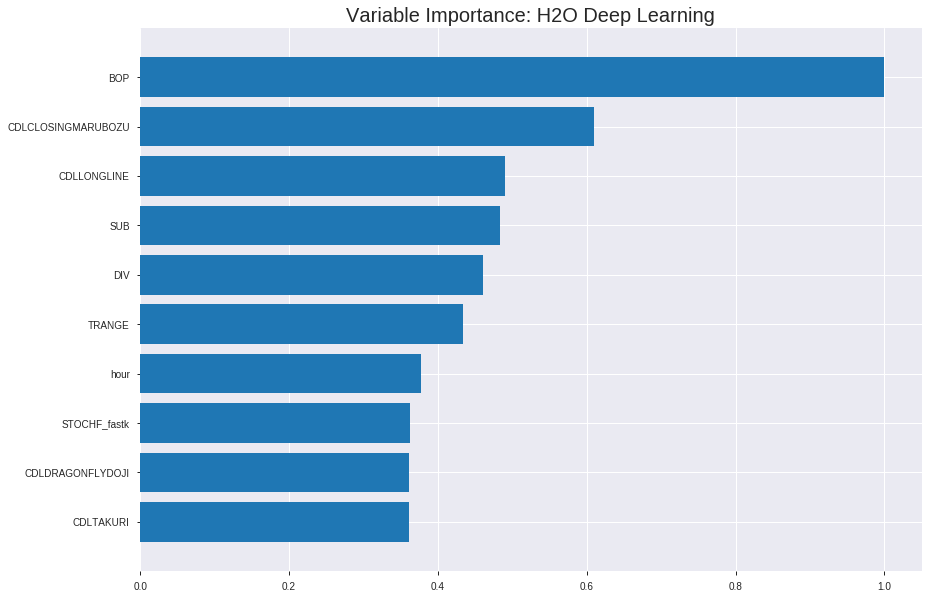

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_023957_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1846317734739372
RMSE: 0.4296879954966594
LogLoss: 0.5477038484031717
Mean Per-Class Error: 0.2511769811420004
AUC: 0.8189454511980222
pr_auc: 0.8169464237594224
Gini: 0.6378909023960444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45753213522809144: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      474  314  0.3985   (314.0/788.0)
1      114  658  0.1477   (114.0/772.0)
Total  588  972  0.2744   (428.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457532     0.754587  223
max f2                       0.285931     0.857078  308
max f0point5                 0.506134     0.743655  192
max accuracy                 0.506134     0.748718  192
max precision                0.964674     1         0
max recall                   0.144902     1         361
max specificity              0.964674     1         0
max absolute_mcc             0.506134     0.497679  192
max min_per_class_accuracy   0.508639     0.742228  190
max mean_per_class_accuracy  0.506134     0.748823  192

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 48.82 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.917878           2.02073    2.02073            1                0.943054  1                           0.943054            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.882961           2.02073    2.02073            1                0.90172   1                           0.922387            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.840757           2.02073    2.02073            1                0.859126  1                           0.902197            0.0194301       0.0608808                  102.073   102.073
    4        0.0403846                   0.813519           1.89443    1.98865            0.9375           0.826103  0.984127                    0.882872            0.0194301       0.0803109                  89.443    98.865
    5        0.05                        0.790599           1.88601    1.96891            0.933333         0.800747  0.974359                    0.867079            0.0181347       0.0984456                  88.601    96.8912
    6        0.1                         0.711702           1.89119    1.93005            0.935897         0.747627  0.955128                    0.807353            0.0945596       0.193005                   89.1192   93.0052
    7        0.15                        0.655598           1.70984    1.85665            0.846154         0.681829  0.918803                    0.765511            0.0854922       0.278497                   70.9845   85.6649
    8        0.2                         0.626155           1.5285     1.77461            0.75641          0.640695  0.878205                    0.734307            0.0764249       0.354922                   52.8497   77.4611
    9        0.3                         0.575344           1.43782    1.66235            0.711538         0.598205  0.82265                     0.68894             0.143782        0.498705                   43.7824   66.2349
    10       0.4                         0.540079           1.26943    1.56412            0.628205         0.557428  0.774038                    0.656062            0.126943        0.625648                   26.943    56.4119
    11       0.503205                    0.507343           1.24256    1.49817            0.614907         0.52301   0.741401                    0.628774            0.128238        0.753886                   24.2558   49.8168
    12       0.6                         0.468907           0.789555   1.38385            0.390728         0.488033  0.684829                    0.606069            0.0764249       0.830311                   -21.0445  38.3851
    13       0.7                         0.414764           0.699482   1.28608            0.346154         0.442953  0.636447                    0.582766            0.0699482       0.900259                   -30.0518  28.6084
    14       0.8                         0.327903           0.505181   1.18847            0.25             0.375351  0.588141                    0.556839            0.0505181       0.950777                   -49.4819  18.8472
    15       0.9                         0.23583            0.414508   1.10248            0.205128         0.286463  0.545584                    0.526797            0.0414508       0.992228                   -58.5492  10.2476
    16       1                           0.00254766         0.0777202  1                  0.0384615        0.141115  0.494872                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20507025006672883
RMSE: 0.45284682848257735
LogLoss: 0.5977284350286237
Mean Per-Class Error: 0.3001820388349514
AUC: 0.7511326860841424
pr_auc: 0.6854270679020984
Gini: 0.5022653721682848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3310265437626344: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      99   141  0.5875   (141.0/240.0)
1      17   189  0.0825   (17.0/206.0)
Total  116  330  0.3543   (158.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331027     0.705224  294
max f2                       0.31184      0.823328  305
max f0point5                 0.459808     0.668761  206
max accuracy                 0.459808     0.697309  206
max precision                0.954027     1         0
max recall                   0.0831909    1         391
max specificity              0.954027     1         0
max absolute_mcc             0.444611     0.400252  221
max min_per_class_accuracy   0.471622     0.684466  195
max mean_per_class_accuracy  0.444611     0.699818  221

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 45.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.89559            1.73204   1.73204            0.8              0.928125  0.8                         0.928125            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.835566           1.62379   1.68393            0.75             0.863921  0.777778                    0.89959             0.0145631       0.0339806                  62.3786   68.3927
    3        0.0313901                   0.812008           1.73204   1.70111            0.8              0.822649  0.785714                    0.872111            0.0194175       0.0533981                  73.2039   70.111
    4        0.0403587                   0.776383           1.08252   1.56365            0.5              0.799577  0.722222                    0.855992            0.00970874      0.0631068                  8.25243   56.3646
    5        0.0515695                   0.756522           1.73204   1.60025            0.8              0.764344  0.73913                     0.836069            0.0194175       0.0825243                  73.2039   60.0253
    6        0.100897                    0.684532           1.7714    1.68393            0.818182         0.723445  0.777778                    0.781008            0.0873786       0.169903                   77.1403   68.3927
    7        0.150224                    0.628698           1.47617   1.61571            0.681818         0.654893  0.746269                    0.739597            0.0728155       0.242718                   47.6169   61.5708
    8        0.201794                    0.588734           1.60025   1.61176            0.73913          0.604172  0.744444                    0.704989            0.0825243       0.325243                   60.0253   61.1758
    9        0.300448                    0.547326           1.47617   1.56724            0.681818         0.567686  0.723881                    0.659904            0.145631        0.470874                   47.6169   56.7237
    10       0.403587                    0.507343           1.17666   1.46742            0.543478         0.523906  0.677778                    0.625149            0.121359        0.592233                   17.6657   46.7422
    11       0.5                         0.462668           1.15805   1.40777            0.534884         0.487224  0.650224                    0.598554            0.11165         0.703883                   15.8049   40.7767
    12       0.600897                    0.414761           0.866019  1.3168             0.4              0.43824   0.608209                    0.571635            0.0873786       0.791262                   -13.3981  31.6802
    13       0.699552                    0.352352           0.934907  1.26294            0.431818         0.384512  0.583333                    0.545246            0.092233        0.883495                   -6.50927  26.2945
    14       0.800448                    0.286197           0.481122  1.1644             0.222222         0.322111  0.537815                    0.51712             0.0485437       0.932039                   -51.8878  16.4396
    15       0.899103                    0.206666           0.442851  1.08522            0.204545         0.248529  0.501247                    0.487649            0.0436893       0.975728                   -55.7149  8.52238
    16       1                           0.00544119         0.240561  1                  0.111111         0.124141  0.461883                    0.450972          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:00:17  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:00:19  3 min  3.992 sec  269 obs/sec       0.373077  1             582        0.599752         1.63826             -0.438959      0.546096        0.53858            1.13666          0.505128                         0.563852           1.11963               -0.279149        0.562905          0.503662             0.866019           0.535874
    2019-09-03 03:00:43  3 min 28.367 sec  350 obs/sec       5.41474   14            8447       0.494336         0.681614            0.0224261      0.591895        0.564164           1.26295          0.486538                         0.497621           0.68829               0.00370161       0.56432           0.520253             1.29903            0.524664
    2019-09-03 03:01:08  3 min 53.549 sec  374 obs/sec       11.2359   29            17528      0.484011         0.659791            0.0628358      0.624074        0.576131           1.13666          0.395513                         0.490963           0.675284              0.0301841        0.595914          0.54371              1.73204            0.473094
    2019-09-03 03:01:33  4 min 18.545 sec  384 obs/sec       17.1051   44            26684      0.45858          0.607607            0.158729       0.755919        0.736919           2.02073          0.346795                         0.467849           0.625857              0.11935          0.717769          0.639298             1.29903            0.343049
    2019-09-03 03:01:58  4 min 43.418 sec  389 obs/sec       22.9365   59            35781      0.452817         0.594904            0.179742       0.751299        0.731229           1.89443          0.328205                         0.461396           0.614073              0.143477         0.725243          0.670546             2.16505            0.347534
    2019-09-03 03:02:23  5 min  7.915 sec  394 obs/sec       28.7564   74            44860      0.450756         0.58544             0.18719        0.785472        0.778953           2.02073          0.303846                         0.46731            0.627625              0.121379         0.734628          0.678527             1.73204            0.376682
    2019-09-03 03:02:48  5 min 33.555 sec  397 obs/sec       34.9147   90            54467      0.439385         0.566224            0.227682       0.789115        0.780159           2.02073          0.30641                          0.4558             0.605651              0.164127         0.747907          0.682045             1.73204            0.365471
    2019-09-03 03:03:14  5 min 59.452 sec  401 obs/sec       41.2859   106           64406      0.433752         0.553993            0.247356       0.808399        0.792589           2.02073          0.277564                         0.460873           0.624294              0.145419         0.744185          0.664569             1.73204            0.320628
    2019-09-03 03:03:38

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.009736185105978113
CDLCLOSINGMARUBOZU        0.6095616221427917     0.6095616221427917   0.0059348047866825075
CDLLONGLINE               0.4895029664039612     0.4895029664039612   0.004765891490834352
SUB                       0.48286837339401245    0.48286837339401245  0.004701295865186662
DIV                       0.4604456424713135     0.4604456424713135   0.0044829840063417255
---                       ---                    ---                  ---
BBANDS_middleband_14_7_5  0.06874494254589081    0.06874494254589081  0.0006693134857266232
BBANDS_middleband_14_5_4  0.06871949136257172    0.06871949136257172  0.0006690656882946624
BBANDS_lowerband_20_0_2   0.06822681427001953    0.06822681427001953  0.0006642688929240992
BBANDS_middleband_20_1_2  0.06810411065816879    0.06810411065816879  0.0006630742278459483
EMA_24                    0.06787632405757904    0.06787632405757904  0.000660856455337945


See the whole table with table.as_data_frame()


('accuracy', 0.6905829596412556)

('F1', 0.6280193236714975)

('auc', 0.7107892107892108)

('logloss', 0.6288658402382136)

('mean_per_class_error', 0.33187645687645695)

('rmse', 0.4648709449715757)

('mse', 0.21610499547876577)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


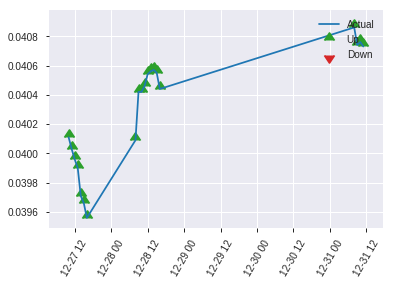


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21610499547876577
RMSE: 0.4648709449715757
LogLoss: 0.6288658402382136
Mean Per-Class Error: 0.33187645687645695
AUC: 0.7107892107892108
pr_auc: 0.6194663652859483
Gini: 0.4215784215784215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48540792863664367: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   51   0.3864   (51.0/132.0)
1      26   65   0.2857   (26.0/91.0)
Total  107  116  0.3453   (77.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485408     0.628019  115
max f2                       0.212203     0.782918  197
max f0point5                 0.567077     0.619946  69
max accuracy                 0.608068     0.690583  53
max precision                0.679221     0.9       19
max recall                   0.0122857    1         222
max specificity              0.802766     0.992424  0
max absolute_mcc             0.567077     0.342787  69
max min_per_class_accuracy   0.504781     0.651515  105
max mean_per_class_accuracy  0.499485     0.668124  109

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 46.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.773177           0.81685   0.81685            0.333333         0.785376  0.333333                    0.785376            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.761274           2.45055   1.47033            1                0.765408  0.6                         0.777389            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.735153           2.45055   1.75039            1                0.751842  0.714286                    0.77009             0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.72436            2.45055   1.90598            1                0.729515  0.777778                    0.761073            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.719451           2.45055   2.04212            1                0.72168   0.833333                    0.751225            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.656042           1.78222   1.91782            0.727273         0.680478  0.782609                    0.71739             0.0879121       0.197802                   78.2218   91.7821
    7        0.152466                    0.645878           1.55944   1.80187            0.636364         0.651845  0.735294                    0.696184            0.0769231       0.274725                   55.9441   80.1875
    8        0.201794                    0.622028           1.33666   1.68816            0.545455         0.633704  0.688889                    0.680911            0.0659341       0.340659                   33.6663   68.8156
    9        0.300448                    0.578289           1.44805   1.60932            0.590909         0.60385   0.656716                    0.655608            0.142857        0.483516                   44.8052   60.9316
    10       0.399103                    0.53072            0.77972   1.40425            0.318182         0.552894  0.573034                    0.630218            0.0769231       0.56044                    -22.028   40.4247
    11       0.502242                    0.49138            1.27855   1.37843            0.521739         0.512548  0.5625                      0.606053            0.131868        0.692308                   27.8548   37.8434
    12       0.600897                    0.456342           0.556943  1.24356            0.227273         0.472492  0.507463                    0.584125            0.0549451       0.747253                   -44.3057  24.3562
    13       0.699552                    0.387475           0.891109  1.19386            0.363636         0.427732  0.487179                    0.56207             0.0879121       0.835165                   -10.8891  19.3857
    14       0.798206                    0.320154           0.77972   1.14267            0.318182         0.352165  0.466292                    0.536127            0.0769231       0.912088                   -22.028   14.2672
    15       0.896861                    0.199068           0.556943  1.07824            0.227273         0.249802  0.44                        0.504631            0.0549451       0.967033                   -44.3057  7.82418
    16       1                           0.0122857          0.319637  1                  0.130435         0.135698  0.408072                    0.466579          

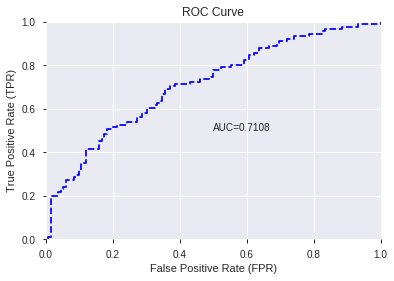

This function is available for GLM models only


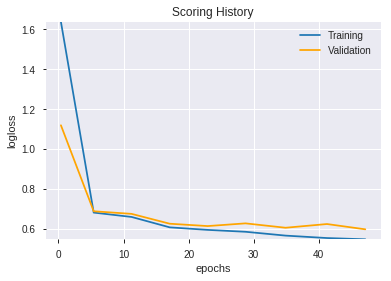

--2019-09-03 03:09:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.7MB/s    in 23s     

2019-09-03 03:10:07 (15.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_023957_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_023957_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_031022_model_9  0.753080  0.598486              0.325591  0.447674  0.200412
1  DeepLearning_grid_1_AutoML_20190903_031022_model_8  0.748252  0.604270              0.318223  0.447325  0.200100
2  DeepLearning_grid_1_AutoML_20190903_031022_model_6  0.748168  0.630593              0.337329  0.456004  0.207940
3  DeepLearning_grid_1_AutoML_20190903_031022_model_5  0.745921  0.599820              0.312729  0.454297  0.206386
4               DeepLearning_1_AutoML_20190903_031022  0.737512  0.761236              0.319722  0.506038  0.256075
5  DeepLearning_grid_1_AutoML_20190903_031022_model_2  0.727939  0.819808              0.301199  0.508972  0.259052
6  DeepLearning_grid_1_AutoML_20190903_031022_model_7  0.726357  0.765483              0.381077  0.511131  0.261255
7  DeepLearning_grid_1_AutoML_20190903_031022_model_3  0.724192  0.857843              0.307443  0.484798  0.235029
8  DeepLearning_grid_1_AutoML_20190903_031022_model_4  0.724026  0.887483              0.370463  0.502946  0.252955
9  DeepLearning_grid_1_AutoML_20190903_031022_model_1  0.664918  1.256675              0.396062  0.546564  0.298732

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.038453
1   CDLCLOSINGMARUBOZU             0.937305           0.937305    0.036042
2          CDLLONGLINE             0.778259           0.778259    0.029927
3               TRANGE             0.686673           0.686673    0.026405
4            CDLTAKURI             0.636427           0.636427    0.024473
5                  SUB             0.616505           0.616505    0.023707
6        CDLHANGINGMAN             0.615184           0.615184    0.023656
7                  DIV             0.604353           0.604353    0.023239
8     CDLDRAGONFLYDOJI             0.602985           0.602985    0.023187
9               ULTOSC             0.600543           0.600543    0.023093
10             CDLDOJI             0.573236           0.573236    0.022043
11        CDLSHORTLINE             0.572600           0.572600    0.022018
12        STOCHF_fastk             0.544484           0.544484    0.020937
13             WILLR_8             0.537130           0.537130    0.020654
14   CDLGRAVESTONEDOJI             0.532913           0.532913    0.020492
15           CDLHARAMI             0.531196           0.531196    0.020426
16                hour             0.526474           0.526474    0.020245
17                 day             0.509255           0.509255    0.019582
18         CDL3OUTSIDE             0.506171           0.506171    0.019464
19         CDLMARUBOZU             0.505276           0.505276    0.019429
20           PLUS_DI_8             0.486092           0.486092    0.018692
21         AROONOSC_12             0.482584           0.482584    0.018557
22        aroondown_12             0.482474           0.482474    0.018553
23      CDLHARAMICROSS             0.479269           0.479269    0.018429
24                DX_8             0.477992           0.477992    0.018380
25        aroondown_30             0.475006           0.475006    0.018266
26         CDLBELTHOLD             0.474176           0.474176    0.018234
27        aroondown_24             0.471305           0.471305    0.018123
28              SAREXT             0.468490           0.468490    0.018015
29            WILLR_12             0.464906           0.464906    0.017877
30   HT_PHASOR_inphase             0.461822           0.461822    0.017759
31           aroonup_8             0.461402           0.461402    0.017742
32      STOCHRSI_fastk             0.460720           0.460720    0.017716
33               MFI_8             0.459679           0.459679    0.017676
34               DX_12             0.459084           0.459084    0.017653
35               DX_14             0.453444           0.453444    0.017436
36          aroonup_12             0.453419           0.453419    0.017435
37      STOCHRSI_fastd             0.452908           0.452908    0.017416
38        STOCHF_fastd             0.449409           0.449409    0.017281
39        CDLENGULFING             0.448863           0.448863    0.017260
40            WILLR_14             0.442388           0.442388    0.017011
41           dayofweek             0.442164           0.442164    0.017003
42         STOCH_slowd             0.439660           0.439660    0.016906
43         STOCH_slowk             0.439345           0.439345    0.016894
44              MOM_12             0.435721           0.435721    0.016755
45         CDLDOJISTAR             0.425667           0.425667    0.016368
46            WILLR_24             0.422021           0.422021    0.016228
47             weekday             0.418429           0.418429    0.016090
48               RSI_8             0.401287           0.401287    0.015431
49               CMO_8             0.398954           0.398954    0.015341

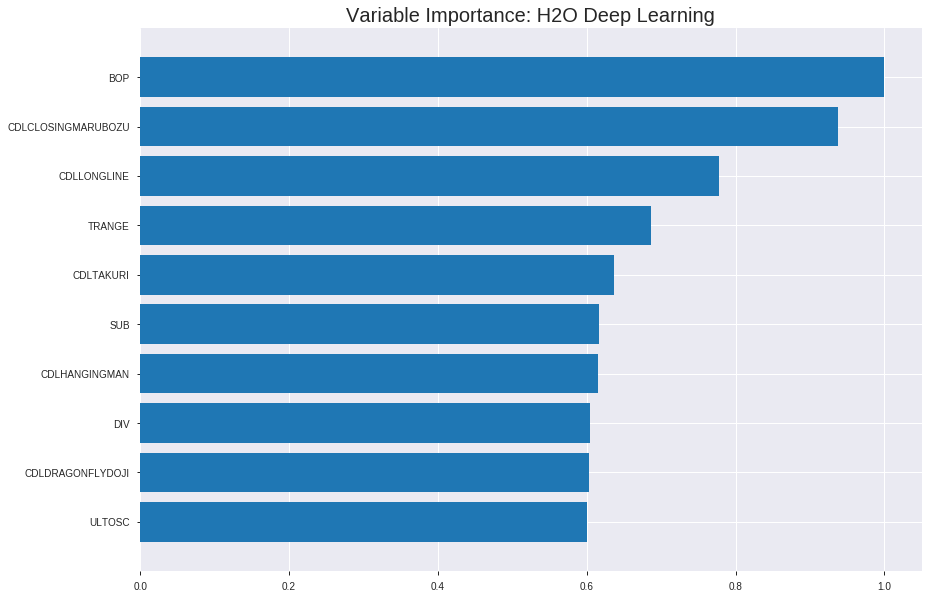

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_031022_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18453597030657096
RMSE: 0.4295765011107695
LogLoss: 0.5479333907370492
Mean Per-Class Error: 0.27242181952079114
AUC: 0.797726092159596
pr_auc: 0.7840287240048159
Gini: 0.595452184319192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40862302456153415: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      492  296  0.3756   (296.0/788.0)
1      136  636  0.1762   (136.0/772.0)
Total  628  932  0.2769   (432.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408623     0.746479  244
max f2                       0.163473     0.847458  359
max f0point5                 0.544693     0.728666  175
max accuracy                 0.472361     0.726923  212
max precision                0.967534     1         0
max recall                   0.0928031    1         392
max specificity              0.967534     1         0
max absolute_mcc             0.436456     0.458619  229
max min_per_class_accuracy   0.492768     0.718274  202
max mean_per_class_accuracy  0.436456     0.727578  229

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.945142           1.89443   1.89443            0.9375           0.955867  0.9375                      0.955867            0.0194301       0.0194301                  89.443    89.443
    2        0.0205128                   0.935929           1.89443   1.89443            0.9375           0.939779  0.9375                      0.947823            0.0194301       0.0388601                  89.443    89.443
    3        0.0301282                   0.928876           1.7513    1.84875            0.866667         0.93257   0.914894                    0.942955            0.0168394       0.0556995                  75.1295   84.8749
    4        0.0403846                   0.914177           2.02073   1.89243            1                0.920929  0.936508                    0.937361            0.0207254       0.0764249                  102.073   89.2425
    5        0.05                        0.903476           1.48187   1.81347            0.733333         0.909989  0.897436                    0.932097            0.0142487       0.0906736                  48.1865   81.3472
    6        0.1                         0.83046            1.9171    1.86528            0.948718         0.870165  0.923077                    0.901131            0.0958549       0.186528                   91.7098   86.5285
    7        0.15                        0.724045           1.76166   1.83074            0.871795         0.777712  0.905983                    0.859991            0.0880829       0.274611                   76.1658   83.0743
    8        0.2                         0.667022           1.45078   1.73575            0.717949         0.69246   0.858974                    0.818108            0.0725389       0.34715                    45.0777   73.5751
    9        0.3                         0.588865           1.34715   1.60622            0.666667         0.61968   0.794872                    0.751966            0.134715        0.481865                   34.715    60.6218
    10       0.4                         0.54942            1.32124   1.53497            0.653846         0.56959   0.759615                    0.706372            0.132124        0.61399                    32.1244   53.4974
    11       0.5                         0.491115           1.08808   1.4456             0.538462         0.524016  0.715385                    0.6699              0.108808        0.722798                   8.80829   44.5596
    12       0.6                         0.406069           1.01036   1.37306            0.5              0.447732  0.679487                    0.632872            0.101036        0.823834                   1.03627   37.3057
    13       0.7                         0.307682           0.647668  1.26943            0.320513         0.358656  0.628205                    0.593699            0.0647668       0.888601                   -35.2332  26.943
    14       0.8                         0.221488           0.544041  1.17876            0.269231         0.260095  0.583333                    0.551998            0.0544041       0.943005                   -45.5959  17.8756
    15       0.9                         0.160148           0.414508  1.09384            0.205128         0.18778   0.541311                    0.511529            0.0414508       0.984456                   -58.5492  9.384
    16       1                           0.0620063          0.15544   1                  0.0769231        0.133279  0.494872                    0.473704            0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2024144784706595
RMSE: 0.4499049660435629
LogLoss: 0.5913629816246675
Mean Per-Class Error: 0.3032160194174758
AUC: 0.7525687702265372
pr_auc: 0.6999584274312851
Gini: 0.5051375404530745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3770400294110009: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  97   0.4042   (97.0/240.0)
1      43   163  0.2087   (43.0/206.0)
Total  186  260  0.3139   (140.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37704      0.699571  236
max f2                       0.163008     0.827842  349
max f0point5                 0.509027     0.681342  168
max accuracy                 0.509027     0.701794  168
max precision                0.963783     1         0
max recall                   0.109051     1         393
max specificity              0.963783     1         0
max absolute_mcc             0.509027     0.397638  168
max min_per_class_accuracy   0.457977     0.679167  196
max mean_per_class_accuracy  0.509027     0.696784  168

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 44.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.943558           1.73204   1.73204            0.8              0.953083  0.8                         0.953083            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.928755           1.62379   1.68393            0.75             0.93472   0.777778                    0.944922            0.0145631       0.0339806                  62.3786   68.3927
    3        0.0313901                   0.922188           1.73204   1.70111            0.8              0.925712  0.785714                    0.938061            0.0194175       0.0533981                  73.2039   70.111
    4        0.0403587                   0.9                2.16505   1.80421            1                0.907967  0.833333                    0.931374            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.88443            1.73204   1.78852            0.8              0.893125  0.826087                    0.923059            0.0194175       0.092233                   73.2039   78.8518
    6        0.100897                    0.791922           1.96823   1.87638            0.909091         0.841359  0.866667                    0.883117            0.0970874       0.18932                    96.8226   87.6375
    7        0.150224                    0.693873           1.27935   1.68034            0.590909         0.742774  0.776119                    0.837034            0.0631068       0.252427                   27.9347   68.0336
    8        0.201794                    0.631794           1.60025   1.65987            0.73913          0.663584  0.766667                    0.792708            0.0825243       0.334951                   60.0253   65.9871
    9        0.300448                    0.569834           1.27935   1.53492            0.590909         0.59151   0.708955                    0.726643            0.126214        0.461165                   27.9347   53.4922
    10       0.401345                    0.532475           1.34714   1.48771            0.622222         0.549729  0.687151                    0.682167            0.135922        0.597087                   34.7141   48.7715
    11       0.5                         0.446067           1.08252   1.40777            0.5              0.489222  0.650224                    0.644097            0.106796        0.703883                   8.25243   40.7767
    12       0.600897                    0.363789           0.962244  1.33296            0.444444         0.408546  0.615672                    0.604546            0.0970874       0.800971                   -3.77562  33.2959
    13       0.699552                    0.26119            0.688879  1.24213            0.318182         0.307747  0.573718                    0.56269             0.0679612       0.868932                   -31.1121  24.2127
    14       0.800448                    0.191193           0.721683  1.17652            0.333333         0.222892  0.543417                    0.519858            0.0728155       0.941748                   -27.8317  17.6525
    15       0.899103                    0.152921           0.34444   1.08522            0.159091         0.171326  0.501247                    0.481615            0.0339806       0.975728                   -65.556   8.52238
    16       1                           0.0541964          0.240561  1                  0.111111         0.126925  0.461883                    0.445828          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:16:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:16:13  1 min 54.707 sec  517 obs/sec       0.776923  1             1212       0.468545         0.703769            0.121771       0.7699          0.740476           1.89443          0.324359                         0.490432           0.761558              0.0322808        0.737055          0.688234             1.73204            0.365471
    2019-09-03 03:16:22  2 min  3.918 sec  789 obs/sec       5.43141   7             8473       0.441322         0.574007            0.220856       0.781193        0.772655           2.02073          0.298718                         0.467024           0.632924              0.122456         0.736782          0.683535             1.73204            0.334081
    2019-09-03 03:16:31  2 min 12.324 sec  928 obs/sec       10.8968   14            16999      0.435932         0.562425            0.239774       0.789378        0.779262           1.89443          0.282692                         0.452615           0.59839               0.175769         0.744053          0.694324             1.73204            0.331839
    2019-09-03 03:16:40  2 min 21.278 sec  1054 obs/sec      17.8526   23            27850      0.429577         0.547933            0.261778       0.797726        0.784029           1.89443          0.276923                         0.449905           0.591363              0.185609         0.752569          0.699958             1.73204            0.313901
    2019-09-03 03:16:49  2 min 30.311 sec  1157 obs/sec      25.6494   33            40013      0.427441         0.543979            0.269098       0.800574        0.790215           1.89443          0.276923                         0.452493           0.59698               0.176214         0.746713          0.691529             2.16505            0.318386
    2019-09-03 03:16:58  2 min 39.371 sec  1246 obs/sec      34.2      44            53352      0.425519         0.540654            0.275657       0.80533         0.792343           1.89443          0.283333                         0.449565           0.59158               0.186841         0.75001           0.699297             1.73204            0.349776
    2019-09-03 03:17:07  2 min 48.105 sec  1314 obs/sec      42.725    55            66651      0.422405         0.534064            0.286222       0.810072        0.797295           1.89443          0.267949                         0.453143           0.600806              0.173846         0.748028          0.693035             1.73204            0.345291
    2019-09-03 03:17:08  2 min 48.958 sec  1313 obs/sec      42.725    55            66651      0.429577         0.547933            0.261778       0.797726        0.784029           1.89443          0.276923                         0.449905           0.591363              0.185609         0.752569          0.699958             1.73204            0.313901

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03845318182832647
CDLCLOSINGMARUBOZU  0.9373045563697815     0.9373045563697815   0.03604234253460609
CDLLONGLINE         0.7782593965530396     0.7782593965530396   0.029926550085257665
TRANGE              0.6866734027862549     0.6866734027862549   0.026404777214015518
CDLTAKURI           0.6364266872406006     0.6364266872406006   0.024472631124862275
---                 ---                    ---                  ---
CDLDOJISTAR         0.425667405128479      0.425667405128479    0.01636826612779731
WILLR_24            0.42202073335647583    0.42202073335647583  0.016228039995080247
weekday             0.4184294641017914     0.4184294641017914   0.016089944265435387
RSI_8               0.40128666162490845    0.40128666162490845  0.015430748964744723
CMO_8               0.39895448088645935    0.39895448088645935  0.015341069194752619


See the whole table with table.as_data_frame()


('accuracy', 0.726457399103139)

('F1', 0.6639004149377594)

('auc', 0.7530802530802531)

('logloss', 0.5984861788085233)

('mean_per_class_error', 0.3061521811521811)

('rmse', 0.4476743436040281)

('mse', 0.2004123179212974)

deeplearning prediction progress: |███████████████████████████████████████| 100%


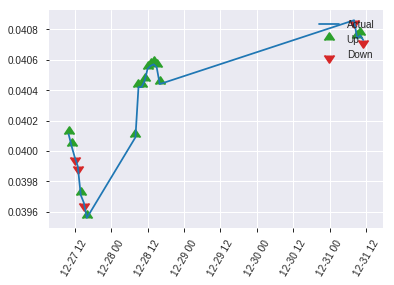


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2004123179212974
RMSE: 0.4476743436040281
LogLoss: 0.5984861788085233
Mean Per-Class Error: 0.3061521811521811
AUC: 0.7530802530802531
pr_auc: 0.668247511344022
Gini: 0.5061605061605061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28768238798238144: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   70   0.5303   (70.0/132.0)
1      11   80   0.1209   (11.0/91.0)
Total  73   150  0.3632   (81.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287682     0.6639    149
max f2                       0.167261     0.791367  191
max f0point5                 0.608118     0.677233  63
max accuracy                 0.608118     0.726457  63
max precision                0.843838     0.92      24
max recall                   0.00846061   1         222
max specificity              0.967515     0.992424  0
max absolute_mcc             0.608118     0.421221  63
max min_per_class_accuracy   0.474081     0.651515  105
max mean_per_class_accuracy  0.608118     0.693848  63

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 47.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.963933           0.81685   0.81685            0.333333         0.966378  0.333333                    0.966378            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.95363            2.45055   1.47033            1                0.959276  0.6                         0.963538            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.943559           2.45055   1.75039            1                0.94719   0.714286                    0.958867            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.936925           2.45055   1.90598            1                0.940518  0.777778                    0.954789            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.933694           2.45055   2.04212            1                0.935599  0.833333                    0.949991            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.853147           2.45055   2.23746            1                0.899346  0.913043                    0.92577             0.120879        0.230769                   145.055   123.746
    7        0.152466                    0.793404           1.78222   2.09017            0.727273         0.817261  0.852941                    0.890664            0.0879121       0.318681                   78.2218   109.017
    8        0.201794                    0.746384           1.11389   1.85153            0.454545         0.771633  0.755556                    0.861567            0.0549451       0.373626                   11.3886   85.1526
    9        0.300448                    0.598782           1.44805   1.71904            0.590909         0.680585  0.701493                    0.80214             0.142857        0.516484                   44.8052   71.9042
    10       0.399103                    0.542996           0.77972   1.48685            0.318182         0.567733  0.606742                    0.744197            0.0769231       0.593407                   -22.028   48.685
    11       0.502242                    0.455662           1.172     1.42219            0.478261         0.494647  0.580357                    0.69295             0.120879        0.714286                   17.2002   42.2194
    12       0.600897                    0.3658             1.0025    1.35329            0.409091         0.408572  0.552239                    0.646261            0.0989011       0.813187                   0.24975   35.3289
    13       0.699552                    0.267309           0.77972   1.2724             0.318182         0.308016  0.519231                    0.59856             0.0769231       0.89011                    -22.028   27.2401
    14       0.798206                    0.199423           0.334166  1.15644            0.136364         0.233146  0.47191                     0.553396            0.032967        0.923077                   -66.5834  15.6439
    15       0.896861                    0.149229           0.445554  1.07824            0.181818         0.173098  0.44                        0.511564            0.043956        0.967033                   -55.4446  7.82418
    16       1                           0.00846061         0.319637  1                  0.130435         0.117182  0.408072                    0.470888           

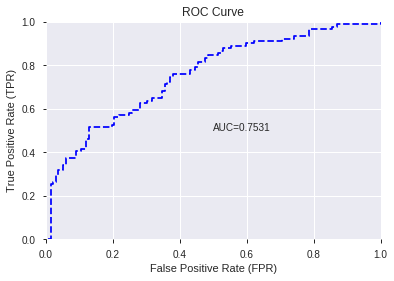

This function is available for GLM models only


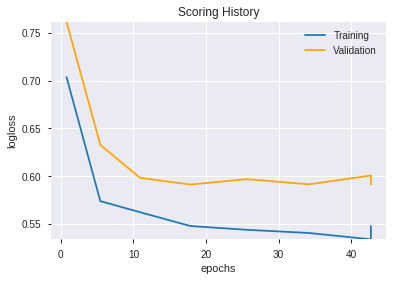

--2019-09-03 03:17:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_031022_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_031022_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'CDLTAKURI',
 'SUB',
 'CDLHANGINGMAN',
 'DIV',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'CDLDOJI',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLGRAVESTONEDOJI',
 'CDLHARAMI',
 'hour',
 'day',
 'CDL3OUTSIDE',
 'CDLMARUBOZU',
 'PLUS_DI_8',
 'AROONOSC_12',
 'aroondown_12',
 'CDLHARAMICROSS',
 'DX_8',
 'aroondown_30',
 'CDLBELTHOLD',
 'aroondown_24',
 'SAREXT',
 'WILLR_12',
 'HT_PHASOR_inphase',
 'aroonup_8',
 'STOCHRSI_fastk',
 'MFI_8',
 'DX_12',
 'DX_14',
 'aroonup_12',
 'STOCHRSI_fastd',
 'STOCHF_fastd',
 'CDLENGULFING',
 'WILLR_14',
 'dayofweek',
 'STOCH_slowd',
 'STOCH_slowk',
 'MOM_12',
 'CDLDOJISTAR',
 'WILLR_24',
 'weekday',
 'RSI_8',
 'CMO_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031726_model_1  0.747835  0.625484              0.330128  0.454629  0.206688

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.495346           1.000000    0.114151
1   CDLCLOSINGMARUBOZU             0.225012           0.454253    0.051854
2               ULTOSC             0.198710           0.401154    0.045792
3            PLUS_DI_8             0.181113           0.365629    0.041737
4         STOCHF_fastk             0.154237           0.311373    0.035544
5              WILLR_8             0.153517           0.309919    0.035378
6             WILLR_12             0.146520           0.295793    0.033765
7                 hour             0.144500           0.291715    0.033300
8         aroondown_12             0.129482           0.261398    0.029839
9                  SUB             0.128484           0.259383    0.029609
10              TRANGE             0.116046           0.234274    0.026743
11   CDLGRAVESTONEDOJI             0.115048           0.232258    0.026513
12         STOCH_slowd             0.113562           0.229257    0.026170
13      CDLHARAMICROSS             0.112241           0.226590    0.025866
14         AROONOSC_12             0.107684           0.217392    0.024816
15    CDLDRAGONFLYDOJI             0.105352           0.212683    0.024278
16           CDLTAKURI             0.105174           0.212325    0.024237
17        STOCHF_fastd             0.103182           0.208303    0.023778
18         STOCH_slowk             0.102316           0.206555    0.023579
19              MOM_12             0.090648           0.183000    0.020890
20         CDLLONGLINE             0.087398           0.176438    0.020141
21       CDLHANGINGMAN             0.086780           0.175191    0.019998
22                 DIV             0.078677           0.158833    0.018131
23                 day             0.077444           0.156342    0.017847
24           CDLHARAMI             0.065238           0.131703    0.015034
25             CDLDOJI             0.062928           0.127039    0.014502
26          aroonup_12             0.062053           0.125272    0.014300
27         CDLDOJISTAR             0.057373           0.115824    0.013221
28               DX_12             0.057075           0.115223    0.013153
29   HT_PHASOR_inphase             0.054362           0.109746    0.012528
30           aroonup_8             0.053045           0.107086    0.012224
31      STOCHRSI_fastk             0.052690           0.106371    0.012142
32                DX_8             0.051138           0.103236    0.011785
33            WILLR_14             0.049854           0.100645    0.011489
34         CDLMARUBOZU             0.049386           0.099701    0.011381
35        aroondown_30             0.049198           0.099320    0.011338
36               MFI_8             0.046861           0.094603    0.010799
37               DX_14             0.041602           0.083985    0.009587
38               RSI_8             0.041031           0.082834    0.009456
39               CMO_8             0.039808           0.080365    0.009174
40         CDLBELTHOLD             0.034615           0.069880    0.007977
41            WILLR_24             0.028565           0.057666    0.006583
42      STOCHRSI_fastd             0.026281           0.053056    0.006056
43              SAREXT             0.025512           0.051504    0.005879
44        CDLENGULFING             0.015475           0.031242    0.003566
45         CDL3OUTSIDE             0.006593           0.013310    0.001519
46             weekday             0.003918           0.007909    0.000903
47           dayofweek             0.003862           0.007796    0.000890
48        CDLSHORTLINE             0.001479           0.002985    0.000341
49        aroondown_24             0.000957           0.001932    0.000221

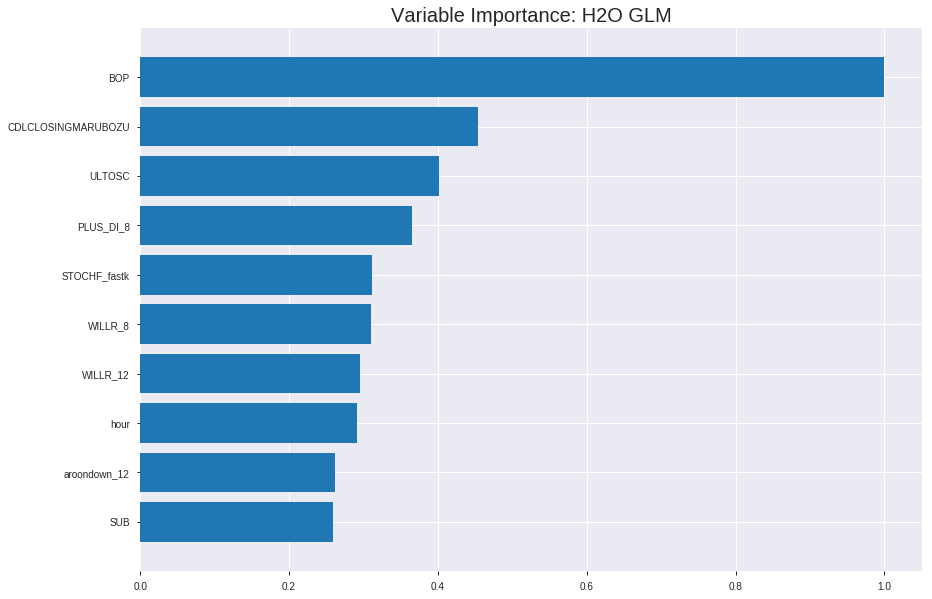

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031726_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18644660267606736
RMSE: 0.43179463020754133
LogLoss: 0.5527626481742801
Null degrees of freedom: 1559
Residual degrees of freedom: 1509
Null deviance: 2162.4550979057067
Residual deviance: 1724.619462303754
AIC: 1826.619462303754
AUC: 0.7928669353778175
pr_auc: 0.7798645794170352
Gini: 0.585733870755635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4252178446798922: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      484  304  0.3858   (304.0/788.0)
1      140  632  0.1813   (140.0/772.0)
Total  624  936  0.2846   (444.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425218     0.740047  239
max f2                       0.210181     0.847001  336
max f0point5                 0.572359     0.725904  168
max accuracy                 0.52717      0.726282  193
max precision                0.973438     1         0
max recall                   0.0650882    1         391
max specificity              0.973438     1         0
max absolute_mcc             0.481608     0.453212  214
max min_per_class_accuracy   0.51875      0.72335   197
max mean_per_class_accuracy  0.52717      0.726115  193

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.919075           2.02073   2.02073            1                0.937688  1                           0.937688            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.888817           2.02073   2.02073            1                0.90286   1                           0.920274            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.875204           1.7513    1.93474            0.866667         0.881516  0.957447                    0.907905            0.0168394       0.0582902                  75.1295   93.4737
    4        0.0403846                   0.865367           1.89443   1.9245             0.9375           0.870755  0.952381                    0.89847             0.0194301       0.0777202                  89.443    92.45
    5        0.05                        0.850798           1.61658   1.86528            0.8              0.857159  0.923077                    0.890525            0.015544        0.0932642                  61.658    86.5285
    6        0.1                         0.796944           1.76166   1.81347            0.871795         0.821785  0.897436                    0.856155            0.0880829       0.181347                   76.1658   81.3472
    7        0.15                        0.746224           1.5285    1.71848            0.75641          0.768965  0.850427                    0.827092            0.0764249       0.257772                   52.8497   71.848
    8        0.2                         0.706941           1.58031   1.68394            0.782051         0.727031  0.833333                    0.802077            0.0790155       0.336788                   58.0311   68.3938
    9        0.3                         0.644448           1.46373   1.61054            0.724359         0.676491  0.797009                    0.760215            0.146373        0.483161                   46.3731   61.0535
    10       0.4                         0.577001           1.26943   1.52526            0.628205         0.61513   0.754808                    0.723943            0.126943        0.610104                   26.943    52.5259
    11       0.5                         0.51601            1.15285   1.45078            0.570513         0.547134  0.717949                    0.688582            0.115285        0.725389                   15.285    45.0777
    12       0.6                         0.42313            0.932642  1.36442            0.461538         0.466636  0.675214                    0.651591            0.0932642       0.818653                   -6.73575  36.4421
    13       0.7                         0.347934           0.699482  1.26943            0.346154         0.38116   0.628205                    0.612958            0.0699482       0.888601                   -30.0518  26.943
    14       0.8                         0.270678           0.544041  1.17876            0.269231         0.309635  0.583333                    0.575042            0.0544041       0.943005                   -45.5959  17.8756
    15       0.9                         0.180322           0.388601  1.09096            0.192308         0.228482  0.539886                    0.536536            0.0388601       0.981865                   -61.1399  9.09614
    16       1                           0.0128484          0.181347  1                  0.0897436        0.119897  0.494872                    0.494872            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20303199303671354
RMSE: 0.45059071565747283
LogLoss: 0.5918137938175232
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 617.6367436752857
Residual deviance: 527.8979040852307
AIC: 629.8979040852307
AUC: 0.7481492718446602
pr_auc: 0.6956964758834716
Gini: 0.49629854368932036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3684846289743311: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  110  0.4583   (110.0/240.0)
1      35   171  0.1699   (35.0/206.0)
Total  165  281  0.3251   (145.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368485     0.702259  252
max f2                       0.104139     0.820717  385
max f0point5                 0.521544     0.671717  171
max accuracy                 0.521544     0.695067  171
max precision                0.969993     1         0
max recall                   0.104139     1         385
max specificity              0.969993     1         0
max absolute_mcc             0.459312     0.388974  202
max min_per_class_accuracy   0.48822      0.683333  190
max mean_per_class_accuracy  0.459312     0.694984  202

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 46.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.897052           1.73204   1.73204            0.8              0.915748  0.8                         0.915748            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.883324           2.16505   1.92449            1                0.89044   0.888889                    0.9045              0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.862436           2.16505   2.0104             1                0.87368   0.928571                    0.893493            0.0242718       0.0631068                  116.505   101.04
    4        0.0403587                   0.836896           1.62379   1.92449            0.75             0.853543  0.888889                    0.884615            0.0145631       0.0776699                  62.3786   92.4488
    5        0.0515695                   0.833812           1.73204   1.88265            0.8              0.835011  0.869565                    0.873831            0.0194175       0.0970874                  73.2039   88.2651
    6        0.100897                    0.767484           1.67299   1.78015            0.772727         0.798828  0.822222                    0.837163            0.0825243       0.179612                   67.2992   78.0151
    7        0.150224                    0.714348           1.27935   1.61571            0.590909         0.737882  0.746269                    0.804563            0.0631068       0.242718                   27.9347   61.5708
    8        0.201794                    0.680589           1.50612   1.5877             0.695652         0.6975    0.733333                    0.777203            0.0776699       0.320388                   50.6121   58.7702
    9        0.300448                    0.613759           1.62379   1.59955            0.75             0.641811  0.738806                    0.732746            0.160194        0.480583                   62.3786   59.9551
    10       0.401345                    0.555575           1.05847   1.46352            0.488889         0.583085  0.675978                    0.695122            0.106796        0.587379                   5.84682   46.3524
    11       0.5                         0.475278           1.18094   1.40777            0.545455         0.51538   0.650224                    0.659657            0.116505        0.703883                   18.0936   40.7767
    12       0.600897                    0.391735           0.962244  1.33296            0.444444         0.429844  0.615672                    0.621069            0.0970874       0.800971                   -3.77562  33.2959
    13       0.699552                    0.314955           0.688879  1.24213            0.318182         0.355409  0.573718                    0.583604            0.0679612       0.868932                   -31.1121  24.2127
    14       0.800448                    0.253863           0.625458  1.1644             0.288889         0.285745  0.537815                    0.546059            0.0631068       0.932039                   -37.4542  16.4396
    15       0.899103                    0.155162           0.34444   1.07443            0.159091         0.211366  0.496259                    0.509335            0.0339806       0.966019                   -65.556   7.44256
    16       1                           0.0158946          0.336785  1                  0.155556         0.112046  0.461883                    0.469249          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:17:26  0.000 sec   2            21        51            1.36477           1.36835
    2019-09-03 03:17:26  0.041 sec   4            13        51            1.35399           1.36
    2019-09-03 03:17:26  0.069 sec   6            7.9       51            1.33917           1.34841
    2019-09-03 03:17:26  0.103 sec   8            4.9       51            1.31982           1.33306
    2019-09-03 03:17:26  0.129 sec   10           3.1       51            1.296             1.31386
    2019-09-03 03:17:26  0.158 sec   12           1.9       51            1.26849           1.29135
    2019-09-03 03:17:27  0.188 sec   14           1.2       51            1.23905           1.26713
    2019-09-03 03:17:27  0.215 sec   16           0.73      51            1.20986           1.24349
    2019-09-03 03:17:27  0.243 sec   18           0.46      51            1.18306           1.22279
    2019-09-03 03:17:27  0.263 sec   20           0.28      51            1.16001           1.20659
    2019-09-03 03:17:27  0.279 sec   22           0.18      51            1.14111           1.19528
    2019-09-03 03:17:27  0.299 sec   24           0.11      51            1.1261            1.18834
    2019-09-03 03:17:27  0.318 sec   26           0.068     51            1.11443           1.18478
    2019-09-03 03:17:27  0.340 sec   28           0.042     51            1.10553           1.18363
    2019-09-03 03:17:27  0.370 sec   30           0.026     51            1.09889           1.18407
    2019-09-03 03:17:27  0.394 sec   32           0.016     51            1.09403           1.1855
    2019-09-03 03:17:27  0.420 sec   34           0.01      51            1.09055           1.18744
    2019-09-03 03:17:27  0.448 sec   36           0.0063    51            1.08806           1.18968
    2019-09-03 03:17:27  0.473 sec   38           0.0039    51            1.08631           1.19198

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.6666666666666667)

('auc', 0.7478354978354977)

('logloss', 0.6254844103981756)

('mean_per_class_error', 0.3026973026973028)

('rmse', 0.4546294309599472)

('mse', 0.20668791949496537)

glm prediction progress: |████████████████████████████████████████████████| 100%


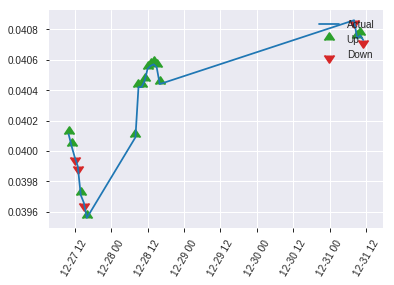


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20668791949496537
RMSE: 0.4546294309599472
LogLoss: 0.6254844103981756
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.326046881648
Residual deviance: 278.9660470375863
AIC: 380.9660470375863
AUC: 0.7478354978354977
pr_auc: 0.6470712270863068
Gini: 0.4956709956709955
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32769175027517194: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   77   0.5833   (77.0/132.0)
1      7    84   0.0769   (7.0/91.0)
Total  62   161  0.3767   (84.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327692     0.666667  160
max f2                       0.327692     0.8       160
max f0point5                 0.637067     0.6469    69
max accuracy                 0.637067     0.70852   69
max precision                0.971422     1         0
max recall                   0.000775755  1         222
max specificity              0.971422     1         0
max absolute_mcc             0.462391     0.388351  116
max min_per_class_accuracy   0.524527     0.659341  102
max mean_per_class_accuracy  0.462391     0.697303  116

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 49.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.954283           0.81685   0.81685            0.333333         0.963896  0.333333                    0.963896            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.935559           2.45055   1.47033            1                0.94347   0.6                         0.955726            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.88947            2.45055   1.75039            1                0.910787  0.714286                    0.942886            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.873507           2.45055   1.90598            1                0.885623  0.777778                    0.930161            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.865106           2.45055   2.04212            1                0.869618  0.833333                    0.915025            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.814388           2.22777   2.13091            0.909091         0.838242  0.869565                    0.878303            0.10989         0.21978                    122.777   113.091
    7        0.152466                    0.738257           1.33666   1.87395            0.545455         0.763577  0.764706                    0.841186            0.0659341       0.285714                   33.6663   87.395
    8        0.201794                    0.7103             1.11389   1.68816            0.454545         0.724461  0.688889                    0.812653            0.0549451       0.340659                   11.3886   68.8156
    9        0.300448                    0.638032           1.55944   1.64589            0.636364         0.673445  0.671642                    0.766943            0.153846        0.494505                   55.9441   64.5891
    10       0.399103                    0.555721           1.11389   1.51438            0.454545         0.608124  0.617978                    0.727685            0.10989         0.604396                   11.3886   51.4384
    11       0.502242                    0.475255           1.06546   1.42219            0.434783         0.518833  0.580357                    0.684795            0.10989         0.714286                   6.54563   42.2194
    12       0.600897                    0.413324           0.891109  1.335              0.363636         0.444745  0.544776                    0.645384            0.0879121       0.802198                   -10.8891  33.5001
    13       0.699552                    0.351327           1.0025    1.28811            0.409091         0.382873  0.525641                    0.608363            0.0989011       0.901099                   0.24975   28.8109
    14       0.798206                    0.276289           0.334166  1.17021            0.136364         0.306348  0.477528                    0.571036            0.032967        0.934066                   -66.5834  17.0206
    15       0.896861                    0.171926           0.222777  1.06599            0.0909091        0.234131  0.435                       0.533976            0.021978        0.956044                   -77.7223  6.5989
    16       1                           0.000775755        0.426183  1                  0.173913         0.117723  0.408072                    0.491044            

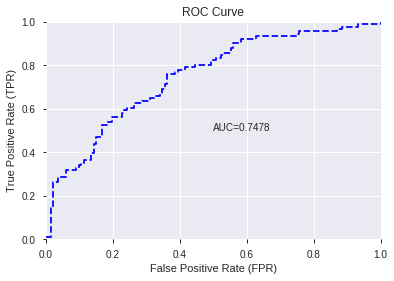

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


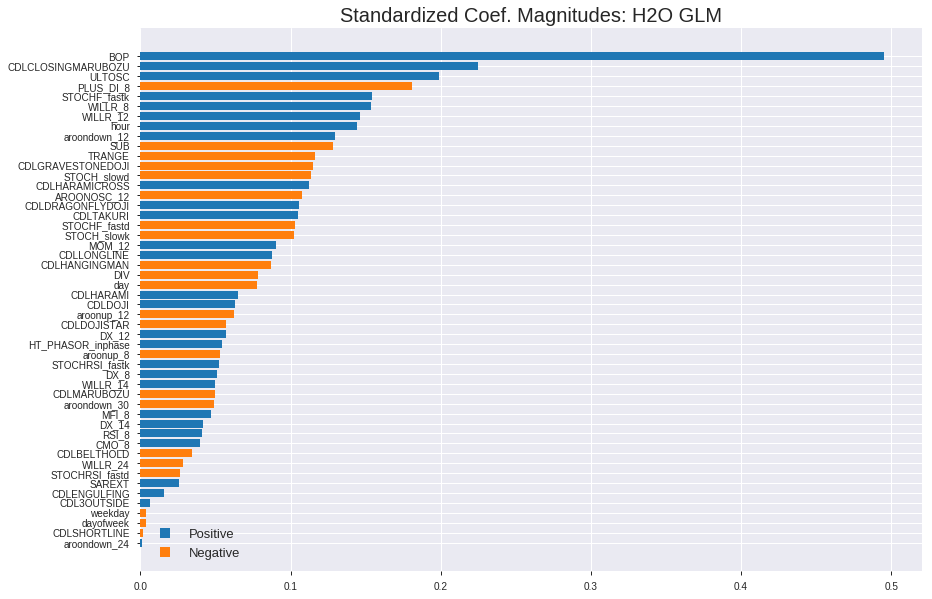

'log_likelihood'
--2019-09-03 03:17:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031726_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031726_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'WILLR_8',
 'WILLR_12',
 'hour',
 'aroondown_12',
 'SUB',
 'TRANGE',
 'CDLGRAVESTONEDOJI',
 'STOCH_slowd',
 'CDLHARAMICROSS',
 'AROONOSC_12',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MOM_12',
 'CDLLONGLINE',
 'CDLHANGINGMAN',
 'DIV',
 'day',
 'CDLHARAMI',
 'CDLDOJI',
 'aroonup_12',
 'CDLDOJISTAR',
 'DX_12',
 'HT_PHASOR_inphase',
 'aroonup_8',
 'STOCHRSI_fastk',
 'DX_8',
 'WILLR_14',
 'CDLMARUBOZU',
 'aroondown_30',
 'MFI_8',
 'DX_14',
 'RSI_8',
 'CMO_8',
 'CDLBELTHOLD',
 'WILLR_24',
 'STOCHRSI_fastd',
 'SAREXT',
 'CDLENGULFING',
 'CDL3OUTSIDE',
 'weekday',
 'dayofweek',
 'CDLSHORTLINE',
 'aroondown_24']

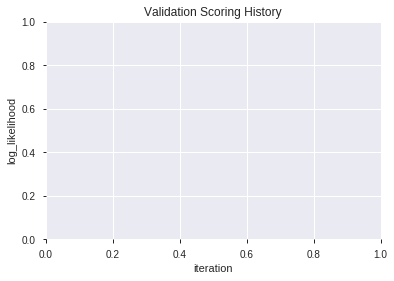

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031743_model_1  0.756202  0.589706              0.323510  0.451584  0.203928
1  XGBoost_grid_1_AutoML_20190903_031743_model_6  0.751499  0.597544              0.324259  0.455168  0.207178
2  XGBoost_grid_1_AutoML_20190903_031743_model_2  0.750083  0.592467              0.318390  0.452770  0.205000
3               XGBoost_3_AutoML_20190903_031743  0.749500  0.592459              0.320097  0.452234  0.204516
4  XGBoost_grid_1_AutoML_20190903_031743_model_3  0.747586  0.598526              0.310440  0.454873  0.206910
5  XGBoost_grid_1_AutoML_20190903_031743_model_4  0.742424  0.608015              0.321054  0.459404  0.211052
6  XGBoost_grid_1_AutoML_20190903_031743_model_7  0.742091  0.605407              0.346029  0.458922  0.210610
7               XGBoost_2_AutoML_20190903_031743  0.736097  0.612149              0.331086  0.461015  0.212535
8               XGBoost_1_AutoML_20190903_031743  0.730103  0.616116              0.339411  0.462019  0.213462
9  XGBoost_grid_1_AutoML_20190903_031743_model_5  0.708375  0.661041              0.336414  0.481511  0.231853

variable  relative_importance  scaled_importance  percentage
0                  BOP          2955.582031           1.000000    0.372920
1         STOCHF_fastk           381.478119           0.129070    0.048133
2                  DIV           372.888092           0.126164    0.047049
3   CDLCLOSINGMARUBOZU           368.029938           0.124520    0.046436
4               TRANGE           323.899811           0.109589    0.040868
5                 hour           295.636871           0.100027    0.037302
6               ULTOSC           278.898163           0.094363    0.035190
7             WILLR_12           210.622345           0.071263    0.026575
8            PLUS_DI_8           188.998138           0.063946    0.023847
9       STOCHRSI_fastd           183.851501           0.062205    0.023197
10            WILLR_14           183.276489           0.062010    0.023125
11           aroonup_8           168.439972           0.056990    0.021253
12             WILLR_8           145.990326           0.049395    0.018420
13      STOCHRSI_fastk           129.668610           0.043872    0.016361
14               DX_14           125.678741           0.042523    0.015857
15   HT_PHASOR_inphase           121.775215           0.041202    0.015365
16                DX_8           116.004051           0.039249    0.014637
17            WILLR_24           113.054718           0.038251    0.014265
18        aroondown_30           107.751724           0.036457    0.013596
19                 SUB           104.417824           0.035329    0.013175
20          aroonup_12            94.477051           0.031966    0.011921
21         STOCH_slowd            84.673721           0.028649    0.010684
22    CDLDRAGONFLYDOJI            81.978783           0.027737    0.010344
23               DX_12            79.653534           0.026950    0.010050
24              MOM_12            78.263168           0.026480    0.009875
25         STOCH_slowk            69.223015           0.023421    0.008734
26        aroondown_24            69.071938           0.023370    0.008715
27               CMO_8            66.140869           0.022378    0.008345
28        aroondown_12            65.056320           0.022011    0.008208
29                 day            62.188381           0.021041    0.007847
30              SAREXT            59.816490           0.020238    0.007547
31         AROONOSC_12            53.322643           0.018041    0.006728
32               MFI_8            48.855385           0.016530    0.006164
33           dayofweek            36.210621           0.012252    0.004569
34   CDLGRAVESTONEDOJI            28.713873           0.009715    0.003623
35         CDLBELTHOLD            24.802595           0.008392    0.003129
36        STOCHF_fastd            22.354580           0.007564    0.002821
37           CDLTAKURI            18.007910           0.006093    0.002272
38           CDLHARAMI             5.134235           0.001737    0.000648
39               RSI_8             1.624748           0.000550    0.000205

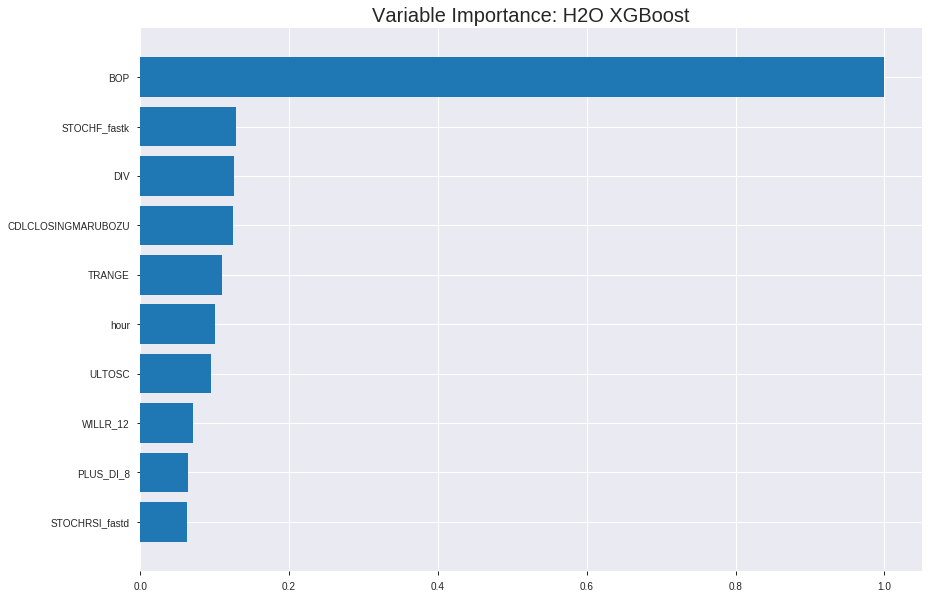

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031743_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1413204447833881
RMSE: 0.3759261161230862
LogLoss: 0.445824116536476
Mean Per-Class Error: 0.18178112095946974
AUC: 0.9043932958102101
pr_auc: 0.9019707009948574
Gini: 0.8087865916204202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5151497721672058: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      616  172  0.2183   (172.0/788.0)
1      114  658  0.1477   (114.0/772.0)
Total  730  830  0.1833   (286.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51515      0.821473  200
max f2                       0.309869     0.895434  288
max f0point5                 0.600878     0.830292  155
max accuracy                 0.525212     0.817949  196
max precision                0.957145     1         0
max recall                   0.20207      1         331
max specificity              0.957145     1         0
max absolute_mcc             0.525212     0.637083  196
max min_per_class_accuracy   0.54445      0.813472  186
max mean_per_class_accuracy  0.525212     0.818219  196

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.924811           2.02073    2.02073            1                0.937232   1                           0.937232            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.912664           2.02073    2.02073            1                0.918302   1                           0.927767            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.900379           2.02073    2.02073            1                0.906311   1                           0.92092             0.0194301       0.0608808                  102.073   102.073
    4        0.0403846                   0.886146           2.02073    2.02073            1                0.895957   1                           0.91458             0.0207254       0.0816062                  102.073   102.073
    5        0.05                        0.87137            2.02073    2.02073            1                0.880256   1                           0.907979            0.0194301       0.101036                   102.073   102.073
    6        0.1                         0.783917           1.96891    1.99482            0.974359         0.826913   0.987179                    0.867446            0.0984456       0.199482                   96.8912   99.4819
    7        0.15                        0.733846           1.96891    1.98618            0.974359         0.753566   0.982906                    0.829486            0.0984456       0.297927                   96.8912   98.6183
    8        0.2                         0.70633            1.89119    1.96244            0.935897         0.719476   0.971154                    0.801984            0.0945596       0.392487                   89.1192   96.2435
    9        0.3                         0.654301           1.68394    1.8696             0.833333         0.681163   0.925214                    0.76171             0.168394        0.560881                   68.3938   86.9603
    10       0.4                         0.601298           1.41192    1.75518            0.698718         0.628723   0.86859                     0.728463            0.141192        0.702073                   41.1917   75.5181
    11       0.5                         0.539319           1.1399     1.63212            0.564103         0.575724   0.807692                    0.697916            0.11399         0.816062                   13.9896   63.2124
    12       0.6                         0.452832           0.790155   1.4918             0.391026         0.499202   0.738248                    0.664797            0.0790155       0.895078                   -20.9845  49.1796
    13       0.7                         0.348723           0.686528   1.37676            0.339744         0.40278    0.681319                    0.627366            0.0686528       0.963731                   -31.3472  37.6758
    14       0.8                         0.228141           0.336788   1.24676            0.166667         0.285556   0.616987                    0.584639            0.0336788       0.997409                   -66.3212  24.6762
    15       0.9                         0.13636            0.0259067  1.11111            0.0128205        0.178267   0.549858                    0.539487            0.00259067      1                          -97.4093  11.1111
    16       1                           0.0481797          0          1                  0                0.0965406  0.494872 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.204629302815328
RMSE: 0.4523597051189772
LogLoss: 0.5927343406739602
Mean Per-Class Error: 0.313794498381877
AUC: 0.7426274271844661
pr_auc: 0.692531003833535
Gini: 0.4852548543689321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41028907895088196: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  118  0.4917   (118.0/240.0)
1      28   178  0.1359   (28.0/206.0)
Total  150  296  0.3274   (146.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410289     0.709163  255
max f2                       0.156141     0.831967  351
max f0point5                 0.643244     0.663717  99
max accuracy                 0.643244     0.67713   99
max precision                0.951716     1         0
max recall                   0.0859284    1         381
max specificity              0.951716     1         0
max absolute_mcc             0.410289     0.39298   255
max min_per_class_accuracy   0.525874     0.660194  184
max mean_per_class_accuracy  0.410289     0.686206  255

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 48.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.919114           1.73204   1.73204            0.8              0.928429   0.8                         0.928429            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.895987           2.16505   1.92449            1                0.910097   0.888889                    0.920281            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.861025           2.16505   2.0104             1                0.874007   0.928571                    0.903755            0.0242718       0.0631068                  116.505   101.04
    4        0.0403587                   0.840163           2.16505   2.04477            1                0.848356   0.944444                    0.891444            0.0194175       0.0825243                  116.505   104.477
    5        0.0515695                   0.820213           0.866019  1.78852            0.4              0.829375   0.826087                    0.877951            0.00970874      0.092233                   -13.3981  78.8518
    6        0.100897                    0.748704           1.57458   1.68393            0.727273         0.782325   0.777778                    0.8312              0.0776699       0.169903                   57.4581   68.3927
    7        0.150224                    0.711637           1.47617   1.61571            0.681818         0.727831   0.746269                    0.797258            0.0728155       0.242718                   47.6169   61.5708
    8        0.201794                    0.67654            1.60025   1.61176            0.73913          0.690758   0.744444                    0.770042            0.0825243       0.325243                   60.0253   61.1758
    9        0.300448                    0.622447           1.37776   1.53492            0.636364         0.650319   0.708955                    0.73073             0.135922        0.461165                   37.7758   53.4922
    10       0.401345                    0.572642           1.10658   1.42724            0.511111         0.597093   0.659218                    0.697134            0.11165         0.572816                   10.658    42.7239
    11       0.5                         0.519389           1.13173   1.36893            0.522727         0.544002   0.632287                    0.66692             0.11165         0.684466                   13.173    36.8932
    12       0.600897                    0.456728           1.01036   1.30872            0.466667         0.492102   0.604478                    0.637566            0.101942        0.786408                   1.0356    30.8723
    13       0.699552                    0.355606           0.836496  1.24213            0.386364         0.412425   0.573718                    0.605815            0.0825243       0.868932                   -16.3504  24.2127
    14       0.800448                    0.233663           0.577346  1.15833            0.266667         0.291379   0.535014                    0.56618             0.0582524       0.927184                   -42.2654  15.8331
    15       0.899103                    0.141468           0.590468  1.09602            0.272727         0.186322   0.506234                    0.5245              0.0582524       0.985437                   -40.9532  9.60221
    16       1                           0.045263           0.144337  1                  0.0666667        0.0948546  0.461883                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:17:49  0.021 sec   0                  0.5              0.693147            0.5             0                  1                0.505128                         0.5                0.693147              0.5               0                    1                  0.538117
    2019-09-03 03:17:49  0.132 sec   5                  0.469499         0.63348             0.837566        0.800992           2.02073          0.270513                         0.481719           0.656919              0.708455          0.658275             2.16505            0.378924
    2019-09-03 03:17:49  0.199 sec   10                 0.449423         0.594496            0.844479        0.821369           2.02073          0.261538                         0.47132            0.635875              0.720459          0.674172             1.89442            0.338565
    2019-09-03 03:17:49  0.284 sec   15                 0.434215         0.564418            0.85149         0.840239           2.02073          0.267949                         0.465042           0.622558              0.724828          0.675454             2.16505            0.343049
    2019-09-03 03:17:49  0.381 sec   20                 0.42365          0.542592            0.856303        0.847724           2.02073          0.254487                         0.461095           0.613399              0.724848          0.671908             1.73204            0.336323
    2019-09-03 03:17:49  0.478 sec   25                 0.414133         0.522765            0.861729        0.855027           2.02073          0.226923                         0.458826           0.607872              0.724181          0.669414             1.73204            0.327354
    2019-09-03 03:17:50  0.601 sec   30                 0.405473         0.505251            0.873342        0.866741           2.02073          0.225                            0.455712           0.601127              0.734739          0.679078             1.73204            0.325112
    2019-09-03 03:17:50  0.692 sec   35                 0.399094         0.49194             0.879134        0.87441            2.02073          0.225                            0.454356           0.597916              0.737561          0.685628             2.16505            0.329596
    2019-09-03 03:17:50  0.811 sec   40                 0.393523         0.480411            0.884404        0.880263           2.02073          0.220513                         0.45308            0.594984              0.741151          0.689863             1.73204            0.329596
    2019-09-03 03:17:50  0.893 sec   45                 0.388215         0.469767            0.8902          0.887771           2.02073          0.214103                         0.453148           0.594694              0.741424          0.689805             1.73204            0.327354
    2019-09-03 03:17:50  0.964 sec   50                 0.383633         0.460808            0.896175        0.894155           2.02073          0.20641                          0.452417           0.592953              0.742547          0.690142             1.73204            0.32287
    2019-09-03 03:17:50  1.033 sec   55                 0.38023          0.453931            0.899485        0.896939           2.02073          0.199359                         0.45279            0.59368               0.741687          0.

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2955.58203125          1.0                    0.3729199866921449
STOCHF_fastk        381.4781188964844      0.12907038778251956    0.04813292729420717
DIV                 372.8880920410156      0.12616401375376837    0.04704908233008288
CDLCLOSINGMARUBOZU  368.0299377441406      0.12452029206189559    0.04643610565862409
TRANGE              323.8998107910156      0.10958917985234508    0.04086799549213959
---                 ---                    ---                    ---
CDLBELTHOLD         24.802595138549805     0.008391780324926417   0.0031294626070949624
STOCHF_fastd        22.35457992553711      0.007563511920554856   0.0028205847647591958
CDLTAKURI           18.007909774780273     0.006092847224126685   0.0022721445057385953
CDLHARAMI           5.134235382080078      0.0017371317486013622  0.0006478111485709223
RSI_8               1.6247482299804688     0.000549721920353304   0.00020500229122253442


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.6638655462184875)

('auc', 0.7562021312021312)

('logloss', 0.589706389842091)

('mean_per_class_error', 0.30044955044955046)

('rmse', 0.45158357161392443)

('mse', 0.20392772215158841)

xgboost prediction progress: |████████████████████████████████████████████| 100%


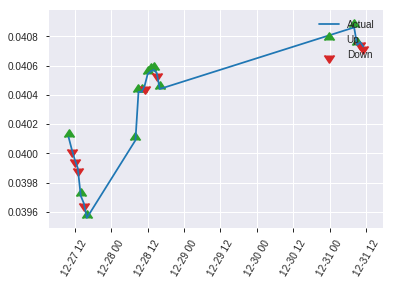


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20392772215158841
RMSE: 0.45158357161392443
LogLoss: 0.589706389842091
Mean Per-Class Error: 0.30044955044955046
AUC: 0.7562021312021312
pr_auc: 0.6886230527152297
Gini: 0.5124042624042624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3607562780380249: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   68   0.5152   (68.0/132.0)
1      12   79   0.1319   (12.0/91.0)
Total  76   147  0.3587   (80.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360756     0.663866  145
max f2                       0.230522     0.797774  173
max f0point5                 0.651647     0.652742  72
max accuracy                 0.651647     0.713004  72
max precision                0.910689     1         0
max recall                   0.10617      1         210
max specificity              0.910689     1         0
max absolute_mcc             0.61528      0.402125  85
max min_per_class_accuracy   0.562297     0.674242  103
max mean_per_class_accuracy  0.61528      0.69955   85

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 48.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.89142            2.45055   2.45055            1                0.900819  1                           0.900819            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.867832           2.45055   2.45055            1                0.874491  1                           0.890288            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.856366           2.45055   2.45055            1                0.862335  1                           0.882301            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.848486           2.45055   2.45055            1                0.853501  1                           0.875901            0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.837124           0.81685   2.04212            0.333333         0.841781  0.833333                    0.867371            0.010989        0.10989                    -18.315   104.212
    6        0.103139                    0.759546           2.45055   2.23746            1                0.794324  0.913043                    0.832436            0.120879        0.230769                   145.055   123.746
    7        0.152466                    0.727545           1.55944   2.0181             0.636364         0.742662  0.823529                    0.803391            0.0769231       0.307692                   55.9441   101.81
    8        0.201794                    0.713374           1.11389   1.79707            0.454545         0.719456  0.733333                    0.782874            0.0549451       0.362637                   11.3886   79.707
    9        0.300448                    0.666698           1.33666   1.64589            0.545455         0.691385  0.671642                    0.752833            0.131868        0.494505                   33.6663   64.5891
    10       0.399103                    0.610529           1.33666   1.56945            0.545455         0.636741  0.640449                    0.724136            0.131868        0.626374                   33.6663   56.9453
    11       0.502242                    0.544042           0.745819  1.40031            0.304348         0.574007  0.571429                    0.693306            0.0769231       0.703297                   -25.4181  40.0314
    12       0.600897                    0.411215           0.77972   1.29843            0.318182         0.475129  0.529851                    0.657486            0.0769231       0.78022                    -22.028   29.8425
    13       0.699552                    0.306186           0.891109  1.24098            0.363636         0.364472  0.50641                     0.616163            0.0879121       0.868132                   -10.8891  24.0983
    14       0.798206                    0.221594           0.77972   1.18397            0.318182         0.260256  0.483146                    0.572175            0.0769231       0.945055                   -22.028   18.3973
    15       0.896861                    0.140477           0.334166  1.09049            0.136364         0.177453  0.445                       0.528755            0.032967        0.978022                   -66.5834  9.04945
    16       1                           0.0801669          0.213091  1                  0.0869565        0.104587  0.408072                    0.485007           

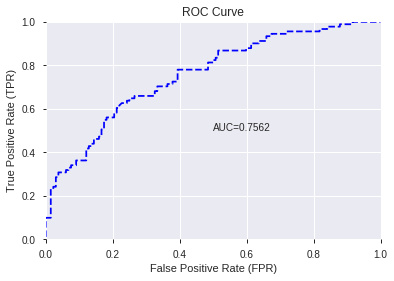

This function is available for GLM models only


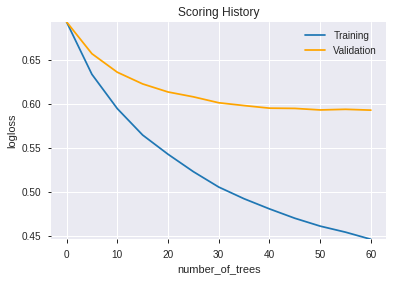

--2019-09-03 03:18:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.50.10
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.50.10|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedT

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031743_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031743_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'hour',
 'ULTOSC',
 'WILLR_12',
 'PLUS_DI_8',
 'STOCHRSI_fastd',
 'WILLR_14',
 'aroonup_8',
 'WILLR_8',
 'STOCHRSI_fastk',
 'DX_14',
 'HT_PHASOR_inphase',
 'DX_8',
 'WILLR_24',
 'aroondown_30',
 'SUB',
 'aroonup_12',
 'STOCH_slowd',
 'CDLDRAGONFLYDOJI',
 'DX_12',
 'MOM_12',
 'STOCH_slowk',
 'aroondown_24',
 'CMO_8',
 'aroondown_12',
 'day',
 'SAREXT',
 'AROONOSC_12',
 'MFI_8',
 'dayofweek',
 'CDLGRAVESTONEDOJI',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLTAKURI',
 'CDLHARAMI',
 'RSI_8']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031817_model_1  0.714952  0.689937              0.369339  0.484396  0.234639

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.337882           1.000000  3.567063e-02
1           CDLCLOSINGMARUBOZU             0.178517           0.528340  1.884624e-02
2                       ULTOSC             0.117015           0.346319  1.235342e-02
3                         hour             0.114720           0.339527  1.211113e-02
4                 STOCHF_fastk             0.107041           0.316801  1.130049e-02
...                        ...                  ...                ...           ...
1022  BBANDS_middleband_14_1_5             0.000019           0.000056  1.991257e-06
1023  BBANDS_middleband_14_1_4             0.000012           0.000037  1.316144e-06
1024   BBANDS_upperband_30_2_3             0.000007           0.000021  7.394612e-07
1025   BBANDS_upperband_12_2_2             0.000007           0.000020  7.241501e-07
1026                    WMA_24             0.000006           0.000018  6.515311e-07

[1027 rows x 4 columns]

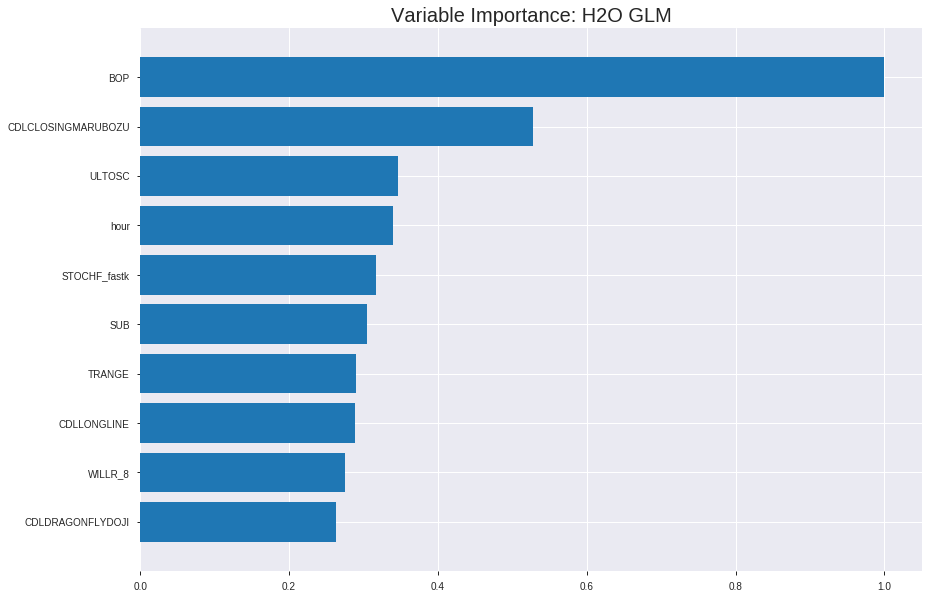

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031817_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18199572138387796
RMSE: 0.42660956550911744
LogLoss: 0.5429574618744238
Null degrees of freedom: 1559
Residual degrees of freedom: 532
Null deviance: 2162.4550979057067
Residual deviance: 1694.0272810482022
AIC: 3750.027281048202
AUC: 0.8061392059651246
pr_auc: 0.7922043681565658
Gini: 0.6122784119302491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.406167221931694: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      458  330  0.4188   (330.0/788.0)
1      111  661  0.1438   (111.0/772.0)
Total  569  991  0.2827   (441.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406167     0.749858  248
max f2                       0.23973      0.853548  323
max f0point5                 0.53959      0.74136   180
max accuracy                 0.501805     0.740385  201
max precision                0.959653     1         0
max recall                   0.0594049    1         392
max specificity              0.959653     1         0
max absolute_mcc             0.498074     0.481245  203
max min_per_class_accuracy   0.512719     0.739637  196
max mean_per_class_accuracy  0.498074     0.740548  203

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.908522           2.02073   2.02073            1                0.933525  1                           0.933525            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.884081           2.02073   2.02073            1                0.893949  1                           0.913737            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.862964           1.88601   1.97773            0.933333         0.874446  0.978723                    0.901197            0.0181347       0.0595855                  88.601    97.7731
    4        0.0403846                   0.84342            1.64184   1.89243            0.8125           0.853289  0.936508                    0.88903             0.0168394       0.0764249                  64.1839   89.2425
    5        0.05                        0.83047            1.7513    1.86528            0.866667         0.83646   0.923077                    0.878921            0.0168394       0.0932642                  75.1295   86.5285
    6        0.1                         0.780068           1.73575   1.80052            0.858974         0.803664  0.891026                    0.841292            0.0867876       0.180052                   73.5751   80.0518
    7        0.15                        0.735291           1.60622   1.73575            0.794872         0.757773  0.858974                    0.813453            0.0803109       0.260363                   60.6218   73.5751
    8        0.2                         0.704821           1.63212   1.70984            0.807692         0.719352  0.846154                    0.789927            0.0816062       0.341969                   63.2124   70.9845
    9        0.3                         0.63884            1.45078   1.62349            0.717949         0.67181   0.803419                    0.750555            0.145078        0.487047                   45.0777   62.3489
    10       0.4                         0.577499           1.37306   1.56088            0.679487         0.610611  0.772436                    0.715569            0.137306        0.624352                   37.3057   56.0881
    11       0.5                         0.510195           1.1658    1.48187            0.576923         0.543248  0.733333                    0.681105            0.11658         0.740933                   16.5803   48.1865
    12       0.6                         0.430211           0.777202  1.36442            0.384615         0.466559  0.675214                    0.645347            0.0777202       0.818653                   -22.2798  36.4421
    13       0.7                         0.360438           0.777202  1.28053            0.384615         0.395056  0.6337                      0.609591            0.0777202       0.896373                   -22.2798  28.0533
    14       0.8                         0.276833           0.556995  1.19009            0.275641         0.318662  0.588942                    0.573225            0.0556995       0.952073                   -44.3005  19.0091
    15       0.9                         0.191374           0.349741  1.09672            0.173077         0.235986  0.542735                    0.535754            0.0349741       0.987047                   -65.0259  9.67185
    16       1                           0.013611           0.129534  1                  0.0641026        0.126931  0.494872                    0.494872         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20289013829108632
RMSE: 0.45043327840101505
LogLoss: 0.5923893741236658
Null degrees of freedom: 445
Residual degrees of freedom: -582
Null deviance: 617.6367436752857
Residual deviance: 528.41132171831
AIC: 2584.41132171831
AUC: 0.7489077669902913
pr_auc: 0.7046464455909874
Gini: 0.49781553398058254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4038279111460782: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  91   0.3792   (91.0/240.0)
1      46   160  0.2233   (46.0/206.0)
Total  195  251  0.3072   (137.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403828     0.700219  223
max f2                       0.140257     0.821197  368
max f0point5                 0.518931     0.686813  159
max accuracy                 0.518931     0.704036  159
max precision                0.950036     1         0
max recall                   0.0612219    1         392
max specificity              0.950036     1         0
max absolute_mcc             0.518931     0.402183  159
max min_per_class_accuracy   0.45801      0.684466  191
max mean_per_class_accuracy  0.403828     0.698766  223

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 44.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.873905           1.73204   1.73204            0.8              0.894782  0.8                         0.894782            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.862663           2.16505   1.92449            1                0.868278  0.888889                    0.883003            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.836513           1.29903   1.70111            0.6              0.847576  0.785714                    0.87035             0.0145631       0.0533981                  29.9029   70.111
    4        0.0403587                   0.812603           2.16505   1.80421            1                0.8244    0.833333                    0.860139            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.797383           2.16505   1.88265            1                0.80345   0.869565                    0.847815            0.0242718       0.0970874                  116.505   88.2651
    6        0.100897                    0.725363           1.57458   1.73204            0.727273         0.760072  0.8                         0.804919            0.0776699       0.174757                   57.4581   73.2039
    7        0.150224                    0.673479           1.57458   1.68034            0.727273         0.696992  0.776119                    0.76948             0.0776699       0.252427                   57.4581   68.0336
    8        0.201794                    0.644729           1.60025   1.65987            0.73913          0.657429  0.766667                    0.740845            0.0825243       0.334951                   60.0253   65.9871
    9        0.300448                    0.575966           1.27935   1.53492            0.590909         0.607846  0.708955                    0.697174            0.126214        0.461165                   27.9347   53.4922
    10       0.401345                    0.515065           1.49148   1.524              0.688889         0.542819  0.703911                    0.658369            0.150485        0.61165                    49.1478   52.4001
    11       0.5                         0.443894           0.885702  1.39806            0.409091         0.480003  0.64574                     0.623176            0.0873786       0.699029                   -11.4298  39.8058
    12       0.600897                    0.377974           0.962244  1.32488            0.444444         0.410318  0.61194                     0.587435            0.0970874       0.796117                   -3.77562  32.488
    13       0.699552                    0.303941           0.639673  1.22825            0.295455         0.341939  0.567308                    0.552814            0.0631068       0.859223                   -36.0327  22.8249
    14       0.800448                    0.236417           0.577346  1.1462             0.266667         0.272039  0.529412                    0.517422            0.0582524       0.917476                   -42.2654  14.6202
    15       0.899103                    0.171949           0.492056  1.07443            0.227273         0.206781  0.496259                    0.483337            0.0485437       0.966019                   -50.7944  7.44256
    16       1                           0.0241858          0.336785  1                  0.155556         0.103531  0.461883                    0.445015           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 03:18:20  0.000 sec   2            .21E2     1028          1.3551426710620746  1.3668261055598798
     2019-09-03 03:18:22  1.929 sec   4            .15E2     1028          1.3472842827543374  1.3613696946288374
     2019-09-03 03:18:24  4.073 sec   6            .11E2     1028          1.3376418939283932  1.3542880293441297
     2019-09-03 03:18:26  6.063 sec   8            .79E1     1028          1.326079309682552   1.3453987662373175
     2019-09-03 03:18:28  7.991 sec   10           .58E1     1028          1.3124675727520791  1.3345604913555538
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 03:18:56  35.438 sec  38           .68E-1    1028          1.0753603164912033  1.1859325957753217
     2019-09-03 03:18:58  37.381 sec  40           .49E-1    1028          1.065766787112408   1.188813945628617
     2019-09-03 03:19:00  39.357 sec  42           .36E-1    1028          1.0570022517834494  1.1932356307211762
     2019-09-03 03:19:02  41.309 sec  44           .26E-1    1028          1.0489684980271463  1.1990251706994688
     2019-09-03 03:19:04  43.243 sec  46           .19E-1    1028          1.0415616230997577  1.2060024148445185


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6905829596412556)

('F1', 0.6352941176470588)

('auc', 0.714951714951715)

('logloss', 0.6899365079774084)

('mean_per_class_error', 0.3347485847485847)

('rmse', 0.48439595253160117)

('mse', 0.2346394388289972)

glm prediction progress: |████████████████████████████████████████████████| 100%


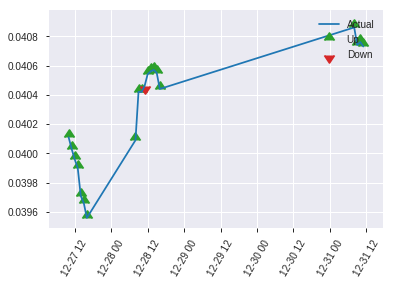


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2346394388289972
RMSE: 0.48439595253160117
LogLoss: 0.6899365079774084
Null degrees of freedom: 222
Residual degrees of freedom: -805
Null deviance: 308.326046881648
Residual deviance: 307.71168255792395
AIC: 2363.711682557924
AUC: 0.714951714951715
pr_auc: 0.6218779910624378
Gini: 0.4299034299034299
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3992878901947035: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   83   0.6288   (83.0/132.0)
1      10   81   0.1099   (10.0/91.0)
Total  59   164  0.417    (93.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399288     0.635294  163
max f2                       0.226344     0.790409  198
max f0point5                 0.676646     0.620155  73
max accuracy                 0.676646     0.690583  73
max precision                0.894732     0.846154  12
max recall                   0.000720889  1         222
max specificity              0.974147     0.992424  0
max absolute_mcc             0.676646     0.344964  73
max min_per_class_accuracy   0.600599     0.659091  104
max mean_per_class_accuracy  0.676646     0.665251  73

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 55.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.952122           0.81685   0.81685            0.333333         0.967382  0.333333                    0.967382            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.930481           2.45055   1.47033            1                0.941317  0.6                         0.956956            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.918723           2.45055   1.75039            1                0.920862  0.714286                    0.946643            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.906888           2.45055   1.90598            1                0.917793  0.777778                    0.940232            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.902118           2.45055   2.04212            1                0.904266  0.833333                    0.931241            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.848718           2.005     2.02437            0.818182         0.873447  0.826087                    0.9036              0.0989011       0.208791                   100.5     102.437
    7        0.152466                    0.803291           1.55944   1.87395            0.636364         0.826659  0.764706                    0.878707            0.0769231       0.285714                   55.9441   87.395
    8        0.201794                    0.771663           1.55944   1.79707            0.636364         0.788873  0.733333                    0.856748            0.0769231       0.362637                   55.9441   79.707
    9        0.300448                    0.700673           1.22527   1.60932            0.5              0.733706  0.656716                    0.816346            0.120879        0.483516                   22.5275   60.9316
    10       0.399103                    0.637906           0.891109  1.43178            0.363636         0.66745   0.58427                     0.77954             0.0879121       0.571429                   -10.8891  43.1782
    11       0.502242                    0.589271           1.06546   1.35655            0.434783         0.610019  0.553571                    0.744728            0.10989         0.681319                   6.54563   35.6554
    12       0.600897                    0.518997           0.668332  1.24356            0.272727         0.545152  0.507463                    0.711962            0.0659341       0.747253                   -33.1668  24.3562
    13       0.699552                    0.41396            0.891109  1.19386            0.363636         0.463838  0.487179                    0.67697             0.0879121       0.835165                   -10.8891  19.3857
    14       0.798206                    0.339482           0.891109  1.15644            0.363636         0.383183  0.47191                     0.640659            0.0879121       0.923077                   -10.8891  15.6439
    15       0.896861                    0.217164           0.556943  1.09049            0.227273         0.282672  0.445                       0.601281            0.0549451       0.978022                   -44.3057  9.04945
    16       1                           0.000720889        0.213091  1                  0.0869565        0.153884  0.408072                    0.555137            

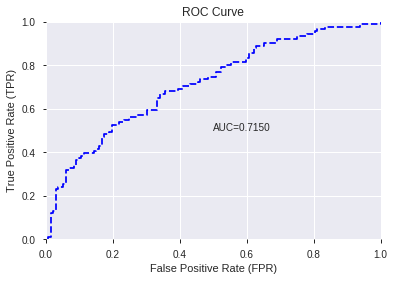

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


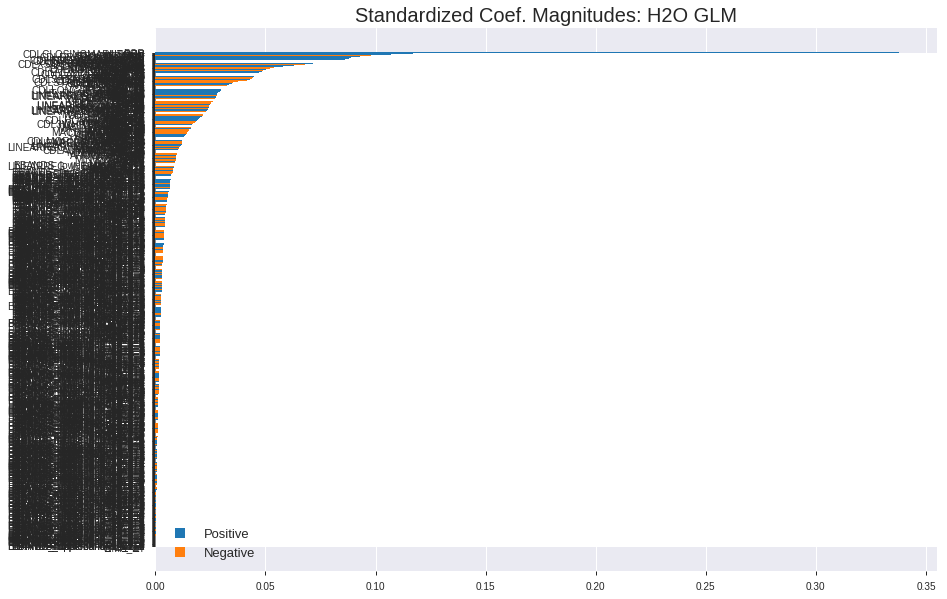

'log_likelihood'
--2019-09-03 03:19:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031817_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031817_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

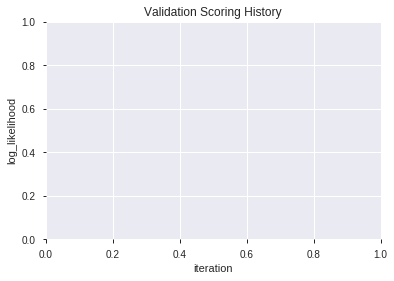

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031941_model_6  0.760490  0.603686              0.298909  0.458104  0.209859
1  XGBoost_grid_1_AutoML_20190903_031941_model_7  0.757160  0.593722              0.353230  0.454110  0.206216
2  XGBoost_grid_1_AutoML_20190903_031941_model_1  0.753663  0.616290              0.303655  0.465212  0.216422
3  XGBoost_grid_1_AutoML_20190903_031941_model_3  0.752581  0.625314              0.269938  0.466580  0.217697
4  XGBoost_grid_1_AutoML_20190903_031941_model_4  0.747336  0.603450              0.327298  0.457739  0.209525
5               XGBoost_3_AutoML_20190903_031941  0.744589  0.617310              0.297577  0.463520  0.214851
6               XGBoost_1_AutoML_20190903_031941  0.739011  0.600330              0.349068  0.456447  0.208344
7               XGBoost_2_AutoML_20190903_031941  0.728188  0.625071              0.339785  0.466835  0.217935
8  XGBoost_grid_1_AutoML_20190903_031941_model_5  0.716617  0.636257              0.335831  0.472739  0.223482
9  XGBoost_grid_1_AutoML_20190903_031941_model_2  0.716533  0.632208              0.343573  0.470256  0.221141

variable  relative_importance  scaled_importance  percentage
0                        BOP          2085.243164           1.000000    0.190369
1                     TRANGE           351.965973           0.168789    0.032132
2                        DIV           296.828278           0.142347    0.027099
3               STOCHF_fastk           251.261444           0.120495    0.022939
4                       hour           201.281693           0.096527    0.018376
..                       ...                  ...                ...         ...
338  BBANDS_upperband_14_1_5             2.611184           0.001252    0.000238
339   BBANDS_upperband_8_1_4             2.380269           0.001141    0.000217
340                  MACDEXT             2.337699           0.001121    0.000213
341                   KAMA_8             2.078717           0.000997    0.000190
342                dayofweek             2.055192           0.000986    0.000188

[343 rows x 4 columns]

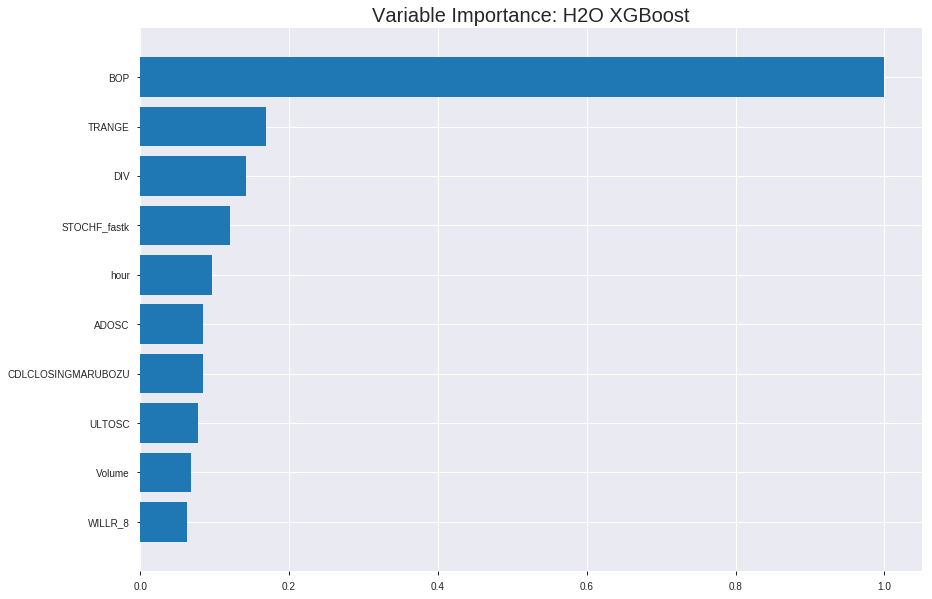

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031941_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11425523793860427
RMSE: 0.33801662376073205
LogLoss: 0.3858972915501471
Mean Per-Class Error: 0.12012769259093659
AUC: 0.9566177244154546
pr_auc: 0.9579155384052018
Gini: 0.9132354488309091
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5168538093566895: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      679  109  0.1383   (109.0/788.0)
1      81   691  0.1049   (81.0/772.0)
Total  760  800  0.1218   (190.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516854     0.879135  196
max f2                       0.344792     0.917874  266
max f0point5                 0.626281     0.904088  147
max accuracy                 0.576126     0.880128  171
max precision                0.948148     1         0
max recall                   0.232722     1         313
max specificity              0.948148     1         0
max absolute_mcc             0.576126     0.763011  171
max min_per_class_accuracy   0.540104     0.876943  187
max mean_per_class_accuracy  0.560641     0.879872  178

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.920392           2.02073    2.02073            1                0.932183   1                           0.932183            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.909979           2.02073    2.02073            1                0.914758   1                           0.92347             0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.894375           2.02073    2.02073            1                0.900941   1                           0.91628             0.0194301       0.0608808                  102.073   102.073
    4        0.0403846                   0.878826           2.02073    2.02073            1                0.88669    1                           0.908765            0.0207254       0.0816062                  102.073   102.073
    5        0.05                        0.863941           2.02073    2.02073            1                0.873398   1                           0.901964            0.0194301       0.101036                   102.073   102.073
    6        0.1                         0.810827           2.02073    2.02073            1                0.838402   1                           0.870183            0.101036        0.202073                   102.073   102.073
    7        0.15                        0.771886           2.02073    2.02073            1                0.790896   1                           0.843754            0.101036        0.303109                   102.073   102.073
    8        0.2                         0.746789           2.02073    2.02073            1                0.759523   1                           0.822696            0.101036        0.404145                   102.073   102.073
    9        0.3                         0.679201           1.96891    2.00345            0.974359         0.715063   0.991453                    0.786818            0.196891        0.601036                   96.8912   100.345
    10       0.4                         0.615744           1.61917    1.90738            0.801282         0.647644   0.94391                     0.752025            0.161917        0.762953                   61.9171   90.7383
    11       0.5                         0.533344           1.19171    1.76425            0.589744         0.576594   0.873077                    0.716939            0.119171        0.882124                   19.171    76.4249
    12       0.6                         0.431306           0.673575   1.58247            0.333333         0.479234   0.78312                     0.677321            0.0673575       0.949482                   -32.6425  58.247
    13       0.7                         0.317461           0.427461   1.41747            0.211538         0.372665   0.701465                    0.633799            0.0427461       0.992228                   -57.2539  41.7469
    14       0.8                         0.210957           0.0777202  1.25               0.0384615        0.26392    0.61859                     0.587564            0.00777202      1                          -92.228   25
    15       0.9                         0.132791           0          1.11111            0                0.167301   0.549858                    0.540868            0               1                          -100      11.1111
    16       1                           0.0443395          0          1                  0                0.0962895  0.494872       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1984202478735028
RMSE: 0.44544387735550117
LogLoss: 0.5796385149228108
Mean Per-Class Error: 0.2943365695792881
AUC: 0.7560780744336569
pr_auc: 0.7078901188492462
Gini: 0.5121561488673139
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4470185935497284: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  104  0.4333   (104.0/240.0)
1      32   174  0.1553   (32.0/206.0)
Total  168  278  0.3049   (136.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447019     0.719008  246
max f2                       0.203903     0.827759  332
max f0point5                 0.453012     0.660522  242
max accuracy                 0.453012     0.695067  242
max precision                0.934536     1         0
max recall                   0.0807323    1         390
max specificity              0.934536     1         0
max absolute_mcc             0.447019     0.423204  246
max min_per_class_accuracy   0.51515      0.674757  196
max mean_per_class_accuracy  0.447019     0.705663  246

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.889461           2.16505   2.16505            1                0.911743  1                           0.911743            0.0242718       0.0242718                  116.505   116.505
    2        0.0201794                   0.852897           1.62379   1.92449            0.75             0.872841  0.888889                    0.894453            0.0145631       0.038835                   62.3786   92.4488
    3        0.0313901                   0.832934           1.29903   1.70111            0.6              0.845762  0.785714                    0.877064            0.0145631       0.0533981                  29.9029   70.111
    4        0.0403587                   0.807109           2.16505   1.80421            1                0.814186  0.833333                    0.863091            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.801679           1.73204   1.78852            0.8              0.805032  0.826087                    0.850469            0.0194175       0.092233                   73.2039   78.8518
    6        0.100897                    0.750533           1.96823   1.87638            0.909091         0.771665  0.866667                    0.811943            0.0970874       0.18932                    96.8226   87.6375
    7        0.150224                    0.701461           1.57458   1.77728            0.727273         0.722372  0.820896                    0.782531            0.0776699       0.26699                    57.4581   77.7279
    8        0.201794                    0.668659           1.31786   1.65987            0.608696         0.682191  0.766667                    0.756889            0.0679612       0.334951                   31.7856   65.9871
    9        0.300448                    0.612028           1.27935   1.53492            0.590909         0.639344  0.708955                    0.718292            0.126214        0.461165                   27.9347   53.4922
    10       0.401345                    0.558874           1.15469   1.43933            0.533333         0.58484   0.664804                    0.684743            0.116505        0.57767                    15.4693   43.9334
    11       0.5                         0.507293           1.08252   1.36893            0.5              0.533294  0.632287                    0.65486             0.106796        0.684466                   8.25243   36.8932
    12       0.600897                    0.457027           1.25092   1.34912            0.577778         0.484238  0.623134                    0.626211            0.126214        0.81068                    25.0917   34.9116
    13       0.699552                    0.35089            0.885702  1.28376            0.409091         0.411076  0.592949                    0.595872            0.0873786       0.898058                   -11.4298  28.3763
    14       0.800448                    0.245922           0.481122  1.18259            0.222222         0.29759   0.546218                    0.558273            0.0485437       0.946602                   -51.8878  18.259
    15       0.899103                    0.152846           0.34444   1.09062            0.159091         0.191064  0.503741                    0.517981            0.0339806       0.980583                   -65.556   9.0623
    16       1                           0.0529187          0.192449  1                  0.0888889        0.106554  0.461883                    0.476469            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:20:32  31.730 sec  0                  0.5              0.693147            0.5             0                  1                0.505128                         0.5                0.693147              0.5               0                    1                  0.538117
    2019-09-03 03:20:33  32.798 sec  5                  0.469882         0.634265            0.844763        0.802219           2.02073          0.233974                         0.482928           0.659269              0.699778          0.619927             2.16505            0.363229
    2019-09-03 03:20:33  33.059 sec  10                 0.448106         0.592486            0.8674          0.857577           2.02073          0.216026                         0.473028           0.63941               0.721167          0.670511             2.16505            0.381166
    2019-09-03 03:20:33  33.273 sec  15                 0.429602         0.556962            0.880288        0.878057           2.02073          0.205769                         0.464262           0.621365              0.730613          0.690434             2.16505            0.35426
    2019-09-03 03:20:34  33.485 sec  20                 0.417112         0.532429            0.890838        0.890666           2.02073          0.192308                         0.45974            0.611497              0.735447          0.692654             2.16505            0.363229
    2019-09-03 03:20:34  33.704 sec  25                 0.403237         0.505932            0.904392        0.906529           2.02073          0.185256                         0.455569           0.602822              0.743801          0.700722             1.73204            0.32287
    2019-09-03 03:20:34  33.919 sec  30                 0.393462         0.486533            0.910205        0.910687           2.02073          0.175641                         0.453193           0.597108              0.744589          0.701631             1.73204            0.320628
    2019-09-03 03:20:34  34.139 sec  35                 0.384354         0.46857             0.916481        0.916919           2.02073          0.173718                         0.45242            0.594992              0.74199           0.699302             2.16505            0.340807
    2019-09-03 03:20:34  34.352 sec  40                 0.377576         0.45566             0.922281        0.924604           2.02073          0.167949                         0.451139           0.591976              0.744701          0.698675             2.16505            0.331839
    2019-09-03 03:20:35  34.570 sec  45                 0.370174         0.44215             0.9297          0.932531           2.02073          0.158974                         0.449201           0.588098              0.748362          0.705004             2.16505            0.334081
    2019-09-03 03:20:35  34.794 sec  50                 0.363225         0.429708            0.936935        0.939632           2.02073          0.142308                         0.448856           0.58679               0.747067          0.703951             2.16505            0.334081
    2019-09-03 03:20:35  35.029 sec  55                 0.35704          0.418522            0.942131        0.944412           2.02073          0.137179                         0.447395           0.583603              0.750607          0.7

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      2085.2431640625        1.0                    0.1903694956965292
TRANGE                   351.9659729003906      0.1687889350106707     0.03213226443713562
DIV                      296.8282775878906      0.14234708100402335    0.027098542024608912
STOCHF_fastk             251.26144409179688     0.12049503310793058    0.022938578686693335
hour                     201.2816925048828      0.09652672454407811    0.018375743872693934
---                      ---                    ---                    ---
BBANDS_upperband_14_1_5  2.6111836433410645     0.0012522202150534424  0.00023838453084072314
BBANDS_upperband_8_1_4   2.3802690505981445     0.001141482725669687   0.00021730349083203785
MACDEXT                  2.3376994132995605     0.0011210680143150411  0.00021341715252666375
KAMA_8                   2.078716516494751      0.000996870078425274   0.00018977365410477893
dayofweek                2.0551915168762207     0.000985588420715533   0.00018762597061595468


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6995515695067265)

('F1', 0.6666666666666666)

('auc', 0.7604895104895105)

('logloss', 0.6036862786615949)

('mean_per_class_error', 0.2989094239094239)

('rmse', 0.45810392507981007)

('mse', 0.20985920617352824)

xgboost prediction progress: |████████████████████████████████████████████| 100%


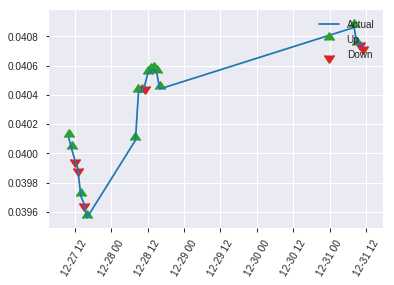


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20985920617352824
RMSE: 0.45810392507981007
LogLoss: 0.6036862786615949
Mean Per-Class Error: 0.2989094239094239
AUC: 0.7604895104895105
pr_auc: 0.6958014779157268
Gini: 0.520979020979021
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5633312463760376: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   47   0.3561   (47.0/132.0)
1      22   69   0.2418   (22.0/91.0)
Total  107  116  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.563331     0.666667  115
max f2                       0.277802     0.815412  193
max f0point5                 0.64934      0.634921  55
max accuracy                 0.64934      0.699552  55
max precision                0.883296     1         0
max recall                   0.277802     1         193
max specificity              0.883296     1         0
max absolute_mcc             0.563331     0.395648  115
max min_per_class_accuracy   0.582928     0.689394  103
max mean_per_class_accuracy  0.563331     0.701091  115

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 52.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.856256           2.45055   2.45055            1                0.872565  1                           0.872565            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.841511           2.45055   2.45055            1                0.845066  1                           0.861565            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.812937           2.45055   2.45055            1                0.835291  1                           0.854058            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.789422           2.45055   2.45055            1                0.802686  1                           0.842642            0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.778872           2.45055   2.45055            1                0.783776  1                           0.827926            0.032967        0.131868                   145.055   145.055
    6        0.103139                    0.73774            1.78222   2.13091            0.727273         0.756094  0.869565                    0.793571            0.0879121       0.21978                    78.2218   113.091
    7        0.152466                    0.701525           1.55944   1.94602            0.636364         0.723434  0.794118                    0.77088             0.0769231       0.296703                   55.9441   94.6025
    8        0.201794                    0.670797           1.33666   1.79707            0.545455         0.687579  0.733333                    0.750517            0.0659341       0.362637                   33.6663   79.707
    9        0.300448                    0.633871           1.33666   1.64589            0.545455         0.650548  0.671642                    0.717692            0.131868        0.494505                   33.6663   64.5891
    10       0.399103                    0.606079           1.22527   1.54192            0.5              0.620664  0.629213                    0.693707            0.120879        0.615385                   22.5275   54.1919
    11       0.502242                    0.570408           1.06546   1.44407            0.434783         0.590334  0.589286                    0.672479            0.10989         0.725275                   6.54563   44.4074
    12       0.600897                    0.502522           0.77972   1.335              0.318182         0.539726  0.544776                    0.650684            0.0769231       0.802198                   -22.028   33.5001
    13       0.699552                    0.444369           0.668332  1.24098            0.272727         0.478787  0.50641                     0.626442            0.0659341       0.868132                   -33.1668  24.0983
    14       0.798206                    0.35866            0.668332  1.17021            0.272727         0.400344  0.477528                    0.598497            0.0659341       0.934066                   -33.1668  17.0206
    15       0.896861                    0.255554           0.668332  1.115              0.272727         0.302884  0.455                       0.56598             0.0659341       1                          -33.1668  11.5
    16       1                           0.103042           0         1                  0                0.200349  0.408072                    0.528269            0

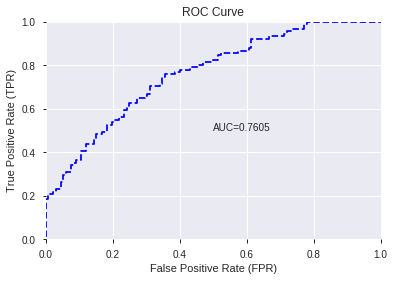

This function is available for GLM models only


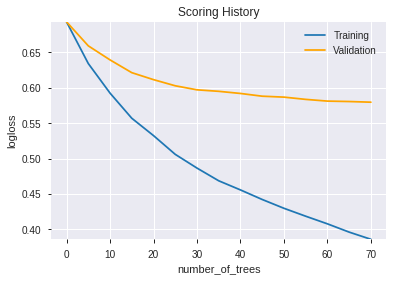

--2019-09-03 03:20:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031941_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031941_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_032056_model_6  0.756327  0.620798              0.339785  0.457841  0.209619
1  DeepLearning_grid_1_AutoML_20190903_032056_model_9  0.753413  0.606042              0.317641  0.453351  0.205527
2  DeepLearning_grid_1_AutoML_20190903_032056_model_8  0.748918  0.614458              0.329379  0.451227  0.203606
3  DeepLearning_grid_1_AutoML_20190903_032056_model_7  0.746587  0.729669              0.310648  0.491576  0.241647
4  DeepLearning_grid_1_AutoML_20190903_032056_model_5  0.737096  0.607144              0.329379  0.456814  0.208679
5               DeepLearning_1_AutoML_20190903_032056  0.736597  0.792514              0.339993  0.523605  0.274163
6  DeepLearning_grid_1_AutoML_20190903_032056_model_2  0.720779  0.829644              0.289086  0.515240  0.265472
7  DeepLearning_grid_1_AutoML_20190903_032056_model_3  0.718032  0.886478              0.328838  0.485191  0.235410
8  DeepLearning_grid_1_AutoML_20190903_032056_model_4  0.714952  0.935009              0.338120  0.507320  0.257373
9  DeepLearning_grid_1_AutoML_20190903_032056_model_1  0.674659  1.267188              0.395105  0.552127  0.304844

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.037271
1   CDLCLOSINGMARUBOZU             0.834458           0.834458    0.031101
2          CDLLONGLINE             0.701082           0.701082    0.026130
3               TRANGE             0.633341           0.633341    0.023605
4                  day             0.615726           0.615726    0.022949
5                  DIV             0.613322           0.613322    0.022859
6                  SUB             0.611717           0.611717    0.022799
7              CDLDOJI             0.600204           0.600204    0.022370
8         STOCHF_fastk             0.575507           0.575507    0.021450
9               ULTOSC             0.570476           0.570476    0.021262
10        CDLSHORTLINE             0.560209           0.560209    0.020880
11          aroonup_12             0.558366           0.558366    0.020811
12           CDLTAKURI             0.556117           0.556117    0.020727
13    CDLDRAGONFLYDOJI             0.550015           0.550015    0.020500
14                hour             0.540938           0.540938    0.020161
15                DX_8             0.533460           0.533460    0.019883
16               DX_12             0.524908           0.524908    0.019564
17       CDLHANGINGMAN             0.524614           0.524614    0.019553
18            WILLR_12             0.522395           0.522395    0.019470
19              SAREXT             0.517759           0.517759    0.019297
20      STOCHRSI_fastd             0.510656           0.510656    0.019033
21           PLUS_DI_8             0.510578           0.510578    0.019030
22        aroondown_24             0.510412           0.510412    0.019024
23         AROONOSC_12             0.508210           0.508210    0.018942
24             WILLR_8             0.507647           0.507647    0.018921
25           dayofweek             0.507401           0.507401    0.018911
26            WILLR_14             0.506754           0.506754    0.018887
27      STOCHRSI_fastk             0.506705           0.506705    0.018886
28         CDL3OUTSIDE             0.506428           0.506428    0.018875
29        aroondown_12             0.502210           0.502210    0.018718
30               DX_14             0.498870           0.498870    0.018593
31      CDLHARAMICROSS             0.498133           0.498133    0.018566
32         CDLBELTHOLD             0.496237           0.496237    0.018495
33        aroondown_30             0.492436           0.492436    0.018354
34         STOCH_slowk             0.488175           0.488175    0.018195
35               MFI_8             0.486820           0.486820    0.018144
36   HT_PHASOR_inphase             0.486784           0.486784    0.018143
37               CMO_8             0.486374           0.486374    0.018128
38              MOM_12             0.484580           0.484580    0.018061
39           CDLHARAMI             0.483924           0.483924    0.018036
40           aroonup_8             0.483832           0.483832    0.018033
41         CDLMARUBOZU             0.479037           0.479037    0.017854
42             weekday             0.476418           0.476418    0.017757
43         STOCH_slowd             0.476270           0.476270    0.017751
44        CDLENGULFING             0.474547           0.474547    0.017687
45        STOCHF_fastd             0.470604           0.470604    0.017540
46   CDLGRAVESTONEDOJI             0.468511           0.468511    0.017462
47            WILLR_24             0.467812           0.467812    0.017436
48               RSI_8             0.459061           0.459061    0.017110
49         CDLDOJISTAR             0.450334           0.450334    0.016784

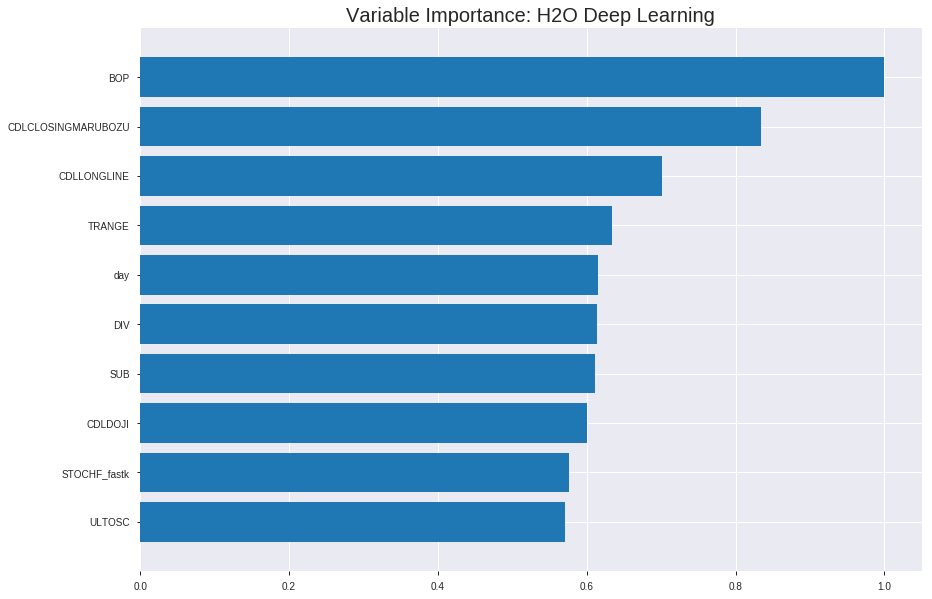

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_032056_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18041215016178513
RMSE: 0.4247495146104173
LogLoss: 0.5359851935466764
Mean Per-Class Error: 0.26701362404986717
AUC: 0.809117001130954
pr_auc: 0.7994132537450078
Gini: 0.6182340022619079
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41278135594877635: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  391   0.4962   (391.0/788.0)
1      65   707   0.0842   (65.0/772.0)
Total  462  1098  0.2923   (456.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412781     0.75615   255
max f2                       0.260534     0.857013  317
max f0point5                 0.608662     0.728312  157
max accuracy                 0.553427     0.732692  186
max precision                0.997036     1         0
max recall                   0.0884611    1         383
max specificity              0.997036     1         0
max absolute_mcc             0.553427     0.466593  186
max min_per_class_accuracy   0.570901     0.722798  176
max mean_per_class_accuracy  0.553427     0.732986  186

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 53.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.988128           2.02073   2.02073            1                0.991783  1                           0.991783            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.981099           1.89443   1.95758            0.9375           0.986354  0.96875                     0.989069            0.0194301       0.0401554                  89.443    95.7578
    3        0.0301282                   0.975985           1.88601   1.93474            0.933333         0.978731  0.957447                    0.985769            0.0181347       0.0582902                  88.601    93.4737
    4        0.0403846                   0.96831            1.89443   1.9245             0.9375           0.972364  0.952381                    0.982365            0.0194301       0.0777202                  89.443    92.45
    5        0.05                        0.949418           1.88601   1.9171             0.933333         0.960374  0.948718                    0.978136            0.0181347       0.0958549                  88.601    91.7098
    6        0.1                         0.857683           1.81347   1.86528            0.897436         0.901284  0.923077                    0.93971             0.0906736       0.186528                   81.3472   86.5285
    7        0.15                        0.784041           1.81347   1.84801            0.897436         0.817576  0.91453                     0.898999            0.0906736       0.277202                   81.3472   84.8014
    8        0.2                         0.734988           1.58031   1.78109            0.782051         0.758595  0.88141                     0.863898            0.0790155       0.356218                   58.0311   78.1088
    9        0.3                         0.666838           1.25648   1.60622            0.621795         0.695742  0.794872                    0.807846            0.125648        0.481865                   25.6477   60.6218
    10       0.4                         0.623012           1.3342    1.53821            0.660256         0.644483  0.761218                    0.767005            0.13342         0.615285                   33.4197   53.8212
    11       0.5                         0.568666           1.10104   1.45078            0.544872         0.593769  0.717949                    0.732358            0.110104        0.725389                   10.1036   45.0777
    12       0.6                         0.498915           1.03627   1.38169            0.512821         0.5356    0.683761                    0.699565            0.103627        0.829016                   3.62694   38.1693
    13       0.7                         0.417612           0.816062  1.30089            0.403846         0.460697  0.643773                    0.665441            0.0816062       0.910622                   -18.3938  30.0888
    14       0.8                         0.30891            0.492228  1.19981            0.24359          0.360735  0.59375                     0.627353            0.0492228       0.959845                   -50.7772  19.9806
    15       0.9                         0.18031            0.297927  1.0996             0.147436         0.246023  0.54416                     0.584983            0.0297927       0.989637                   -70.2073  9.9597
    16       1                           0.0222264          0.103627  1                  0.0512821        0.117157  0.494872                    0.5382              



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19807811414995743
RMSE: 0.4450596748189589
LogLoss: 0.5875992421737303
Mean Per-Class Error: 0.2932038834951456
AUC: 0.7646642394822006
pr_auc: 0.7149905312036546
Gini: 0.5293284789644013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41087266745876416: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  112  0.4667   (112.0/240.0)
1      31   175  0.1505   (31.0/206.0)
Total  159  287  0.3206   (143.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410873     0.709939  258
max f2                       0.18467      0.837438  351
max f0point5                 0.542794     0.679702  197
max accuracy                 0.542794     0.706278  197
max precision                0.854001     0.897436  37
max recall                   0.14629      1         369
max specificity              0.995981     0.995833  0
max absolute_mcc             0.539722     0.412455  199
max min_per_class_accuracy   0.542794     0.704167  197
max mean_per_class_accuracy  0.539722     0.706796  199

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 50.86 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.990308           1.73204    1.73204            0.8              0.992655  0.8                         0.992655            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.986282           1.62379    1.68393            0.75             0.988496  0.777778                    0.990806            0.0145631       0.0339806                  62.3786   68.3927
    3        0.0313901                   0.976925           1.73204    1.70111            0.8              0.984333  0.785714                    0.988494            0.0194175       0.0533981                  73.2039   70.111
    4        0.0403587                   0.957698           2.16505    1.80421            1                0.96392   0.833333                    0.983033            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.923334           2.16505    1.88265            1                0.941397  0.869565                    0.973982            0.0242718       0.0970874                  116.505   88.2651
    6        0.100897                    0.823058           1.86981    1.87638            0.863636         0.878395  0.866667                    0.927251            0.092233        0.18932                    86.9815   87.6375
    7        0.150224                    0.744414           1.57458    1.77728            0.727273         0.783919  0.820896                    0.880187            0.0776699       0.26699                    57.4581   77.7279
    8        0.201794                    0.694872           1.50612    1.70798            0.695652         0.719622  0.788889                    0.839153            0.0776699       0.34466                    50.6121   70.7983
    9        0.300448                    0.637286           1.37776    1.59955            0.636364         0.662684  0.738806                    0.781208            0.135922        0.480583                   37.7758   59.9551
    10       0.401345                    0.593634           1.10658    1.47562            0.511111         0.616428  0.681564                    0.739783            0.11165         0.592233                   10.658    47.562
    11       0.5                         0.532969           1.23014    1.42718            0.568182         0.564081  0.659193                    0.705115            0.121359        0.713592                   23.0141   42.7184
    12       0.600897                    0.465487           0.914132   1.34104            0.422222         0.502771  0.619403                    0.67114             0.092233        0.805825                   -8.58684  34.1038
    13       0.699552                    0.364853           0.590468   1.23519            0.272727         0.41066   0.570513                    0.634405            0.0582524       0.864078                   -40.9532  23.5188
    14       0.800448                    0.266128           0.769795   1.17652            0.355556         0.311518  0.543417                    0.593705            0.0776699       0.941748                   -23.0205  17.6525
    15       0.899103                    0.174293           0.541262   1.10682            0.25             0.21587   0.511222                    0.552247            0.0533981       0.995146                   -45.8738  10.682
    16       1                           0.0566372          0.0481122  1                  0.0222222        0.119827  0.461883                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:24:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:24:45  1 min 53.251 sec  877 obs/sec       1         1             1560       0.483397         0.771779            0.0652122      0.76195         0.74411            2.02073          0.333974                         0.49841            0.839877              0.000541833      0.741758          0.697303             2.16505            0.383408
    2019-09-03 03:24:50  1 min 58.676 sec  1390 obs/sec      6         6             9360       0.436316         0.561069            0.238434       0.797817        0.787848           1.89443          0.282051                         0.454173           0.604032              0.170085         0.756948          0.709439             1.73204            0.318386
    2019-09-03 03:24:56  2 min  3.930 sec  2032 obs/sec      15        15            23400      0.42475          0.535985            0.278275       0.809117        0.799413           2.02073          0.292308                         0.44506            0.587599              0.203056         0.764664          0.714991             1.73204            0.320628
    2019-09-03 03:25:01  2 min  9.183 sec  2393 obs/sec      25        25            39000      0.416822         0.52009             0.304964       0.819882        0.808912           2.02073          0.266026                         0.448502           0.594813              0.190679         0.75713           0.708924             2.16505            0.347534
    2019-09-03 03:25:06  2 min 14.539 sec  2600 obs/sec      35        35            54600      0.409919         0.50456             0.327794       0.831511        0.819325           2.02073          0.253205                         0.449516           0.596921              0.187016         0.75355           0.707092             1.73204            0.345291
    2019-09-03 03:25:13  2 min 21.291 sec  2801 obs/sec      49        49            76440      0.401541         0.487295            0.354993       0.846075        0.835651           2.02073          0.239103                         0.448718           0.595689              0.189899         0.75178           0.705191             1.73204            0.336323
    2019-09-03 03:25:18  2 min 26.545 sec  2919 obs/sec      60        60            93600      0.395639         0.476108            0.373815       0.855054        0.835676           2.02073          0.232051                         0.453442           0.608223              0.172753         0.74373           0.700492             1.73204            0.35426
    2019-09-03 03:25:19  2 min 27.027 sec  2916 obs/sec      60        60            93600      0.42475          0.535985            0.278275       0.809117        0.799413           2.02073          0.292308                         0.44506            0.587599              0.203056         0.764664          0.714991             1.73204            0.320628

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.037271196810828924
CDLCLOSINGMARUBOZU  0.834457516670227      0.834457516670227    0.03110123033409159
CDLLONGLINE         0.7010817527770996     0.7010817527770996   0.026130155988236186
TRANGE              0.6333409547805786     0.6333409547805786   0.023605375373985247
day                 0.6157264709472656     0.6157264709472656   0.022948862480312675
---                 ---                    ---                  ---
STOCHF_fastd        0.470603883266449      0.470603883266449    0.01753996995316418
CDLGRAVESTONEDOJI   0.46851083636283875    0.46851083636283875  0.017461959590085428
WILLR_24            0.4678117334842682     0.4678117334842682   0.017435903189107208
RSI_8               0.4590610861778259     0.4590610861778259   0.017109756091126648
CDLDOJISTAR         0.45033371448516846    0.45033371448516846  0.016784476503128355


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.66147859922179)

('auc', 0.7563270063270063)

('logloss', 0.6207978613914512)

('mean_per_class_error', 0.3137279387279387)

('rmse', 0.4578413963769278)

('mse', 0.2096187442363751)

deeplearning prediction progress: |███████████████████████████████████████| 100%


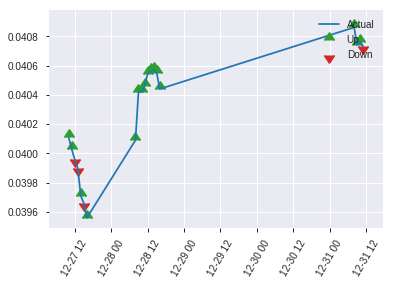


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2096187442363751
RMSE: 0.4578413963769278
LogLoss: 0.6207978613914512
Mean Per-Class Error: 0.3137279387279387
AUC: 0.7563270063270063
pr_auc: 0.6833852951566005
Gini: 0.5126540126540127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3254021894389789: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   81   0.6136   (81.0/132.0)
1      6    85   0.0659   (6.0/91.0)
Total  57   166  0.3901   (87.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325402     0.661479  165
max f2                       0.325402     0.801887  165
max f0point5                 0.807632     0.690377  36
max accuracy                 0.807632     0.721973  36
max precision                0.997118     1         0
max recall                   0.051731     1         222
max specificity              0.997118     1         0
max absolute_mcc             0.807632     0.439062  36
max min_per_class_accuracy   0.56802      0.674242  104
max mean_per_class_accuracy  0.680063     0.686272  65

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 53.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.993449           1.6337    1.6337             0.666667         0.995164  0.666667                    0.995164            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.990735           1.22527   1.47033            0.5              0.991977  0.6                         0.993889            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.987973           2.45055   1.75039            1                0.989744  0.714286                    0.992705            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.984895           2.45055   1.90598            1                0.986258  0.777778                    0.991272            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.973465           2.45055   2.04212            1                0.980185  0.833333                    0.9885              0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.90928            2.45055   2.23746            1                0.941775  0.913043                    0.966153            0.120879        0.230769                   145.055   123.746
    7        0.152466                    0.817346           2.005     2.16225            0.818182         0.857118  0.882353                    0.930877            0.0989011       0.32967                    100.5     116.225
    8        0.201794                    0.771477           1.33666   1.96044            0.545455         0.795746  0.8                         0.897845            0.0659341       0.395604                   33.6663   96.044
    9        0.300448                    0.66861            1.22527   1.71904            0.5              0.716363  0.701493                    0.838254            0.120879        0.516484                   22.5275   71.9042
    10       0.399103                    0.614646           0.891109  1.51438            0.363636         0.638092  0.617978                    0.788776            0.0879121       0.604396                   -10.8891  51.4384
    11       0.502242                    0.537289           0.958911  1.40031            0.391304         0.582267  0.571429                    0.746368            0.0989011       0.703297                   -4.10893  40.0314
    12       0.600897                    0.45434            1.0025    1.335              0.409091         0.48852   0.544776                    0.704035            0.0989011       0.802198                   0.24975   33.5001
    13       0.699552                    0.374993           0.445554  1.20957            0.181818         0.407187  0.49359                     0.662171            0.043956        0.846154                   -55.4446  20.9566
    14       0.798206                    0.267692           1.0025    1.18397            0.409091         0.319896  0.483146                    0.619868            0.0989011       0.945055                   0.24975   18.3973
    15       0.896861                    0.174875           0.334166  1.09049            0.136364         0.231059  0.445                       0.577099            0.032967        0.978022                   -66.5834  9.04945
    16       1                           0.051731           0.213091  1                  0.0869565        0.122454  0.408072                    0.530207            0

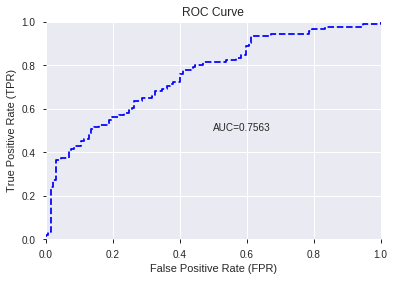

This function is available for GLM models only


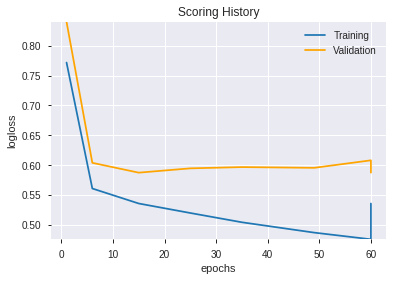

--2019-09-03 03:28:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.100|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_032056_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_032056_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'day',
 'DIV',
 'SUB',
 'CDLDOJI',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLSHORTLINE',
 'aroonup_12',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'hour',
 'DX_8',
 'DX_12',
 'CDLHANGINGMAN',
 'WILLR_12',
 'SAREXT',
 'STOCHRSI_fastd',
 'PLUS_DI_8',
 'aroondown_24',
 'AROONOSC_12',
 'WILLR_8',
 'dayofweek',
 'WILLR_14',
 'STOCHRSI_fastk',
 'CDL3OUTSIDE',
 'aroondown_12',
 'DX_14',
 'CDLHARAMICROSS',
 'CDLBELTHOLD',
 'aroondown_30',
 'STOCH_slowk',
 'MFI_8',
 'HT_PHASOR_inphase',
 'CMO_8',
 'MOM_12',
 'CDLHARAMI',
 'aroonup_8',
 'CDLMARUBOZU',
 'weekday',
 'STOCH_slowd',
 'CDLENGULFING',
 'STOCHF_fastd',
 'CDLGRAVESTONEDOJI',
 'WILLR_24',
 'RSI_8',
 'CDLDOJISTAR']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_032827_model_1  0.747835  0.625484              0.330128  0.454629  0.206688

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.495346           1.000000    0.114151
1   CDLCLOSINGMARUBOZU             0.225012           0.454253    0.051854
2               ULTOSC             0.198710           0.401154    0.045792
3            PLUS_DI_8             0.181113           0.365629    0.041737
4         STOCHF_fastk             0.154237           0.311373    0.035544
5              WILLR_8             0.153517           0.309919    0.035378
6             WILLR_12             0.146520           0.295793    0.033765
7                 hour             0.144500           0.291715    0.033300
8         aroondown_12             0.129482           0.261398    0.029839
9                  SUB             0.128484           0.259383    0.029609
10              TRANGE             0.116046           0.234274    0.026743
11   CDLGRAVESTONEDOJI             0.115048           0.232258    0.026513
12         STOCH_slowd             0.113562           0.229257    0.026170
13      CDLHARAMICROSS             0.112241           0.226590    0.025866
14         AROONOSC_12             0.107684           0.217392    0.024816
15    CDLDRAGONFLYDOJI             0.105352           0.212683    0.024278
16           CDLTAKURI             0.105174           0.212325    0.024237
17        STOCHF_fastd             0.103182           0.208303    0.023778
18         STOCH_slowk             0.102316           0.206555    0.023579
19              MOM_12             0.090648           0.183000    0.020890
20         CDLLONGLINE             0.087398           0.176438    0.020141
21       CDLHANGINGMAN             0.086780           0.175191    0.019998
22                 DIV             0.078677           0.158833    0.018131
23                 day             0.077444           0.156342    0.017847
24           CDLHARAMI             0.065238           0.131703    0.015034
25             CDLDOJI             0.062928           0.127039    0.014502
26          aroonup_12             0.062053           0.125272    0.014300
27         CDLDOJISTAR             0.057373           0.115824    0.013221
28               DX_12             0.057075           0.115223    0.013153
29   HT_PHASOR_inphase             0.054362           0.109746    0.012528
30           aroonup_8             0.053045           0.107086    0.012224
31      STOCHRSI_fastk             0.052690           0.106371    0.012142
32                DX_8             0.051138           0.103236    0.011785
33            WILLR_14             0.049854           0.100645    0.011489
34         CDLMARUBOZU             0.049386           0.099701    0.011381
35        aroondown_30             0.049198           0.099320    0.011338
36               MFI_8             0.046861           0.094603    0.010799
37               DX_14             0.041602           0.083985    0.009587
38               RSI_8             0.041031           0.082834    0.009456
39               CMO_8             0.039808           0.080365    0.009174
40         CDLBELTHOLD             0.034615           0.069880    0.007977
41            WILLR_24             0.028565           0.057666    0.006583
42      STOCHRSI_fastd             0.026281           0.053056    0.006056
43              SAREXT             0.025512           0.051504    0.005879
44        CDLENGULFING             0.015475           0.031242    0.003566
45         CDL3OUTSIDE             0.006593           0.013310    0.001519
46             weekday             0.003918           0.007909    0.000903
47           dayofweek             0.003862           0.007796    0.000890
48        CDLSHORTLINE             0.001479           0.002985    0.000341
49        aroondown_24             0.000957           0.001932    0.000221

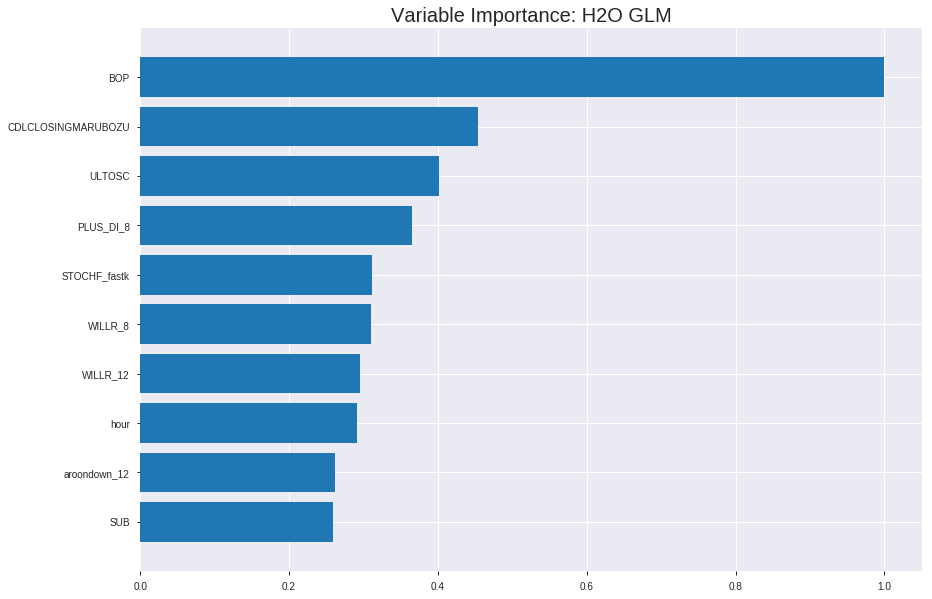

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_032827_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18644660267606736
RMSE: 0.43179463020754133
LogLoss: 0.5527626481742801
Null degrees of freedom: 1559
Residual degrees of freedom: 1509
Null deviance: 2162.4550979057067
Residual deviance: 1724.619462303754
AIC: 1826.619462303754
AUC: 0.7928669353778175
pr_auc: 0.7798645794170352
Gini: 0.585733870755635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4252178446798922: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      484  304  0.3858   (304.0/788.0)
1      140  632  0.1813   (140.0/772.0)
Total  624  936  0.2846   (444.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425218     0.740047  239
max f2                       0.210181     0.847001  336
max f0point5                 0.572359     0.725904  168
max accuracy                 0.52717      0.726282  193
max precision                0.973438     1         0
max recall                   0.0650882    1         391
max specificity              0.973438     1         0
max absolute_mcc             0.481608     0.453212  214
max min_per_class_accuracy   0.51875      0.72335   197
max mean_per_class_accuracy  0.52717      0.726115  193

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.919075           2.02073   2.02073            1                0.937688  1                           0.937688            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.888817           2.02073   2.02073            1                0.90286   1                           0.920274            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.875204           1.7513    1.93474            0.866667         0.881516  0.957447                    0.907905            0.0168394       0.0582902                  75.1295   93.4737
    4        0.0403846                   0.865367           1.89443   1.9245             0.9375           0.870755  0.952381                    0.89847             0.0194301       0.0777202                  89.443    92.45
    5        0.05                        0.850798           1.61658   1.86528            0.8              0.857159  0.923077                    0.890525            0.015544        0.0932642                  61.658    86.5285
    6        0.1                         0.796944           1.76166   1.81347            0.871795         0.821785  0.897436                    0.856155            0.0880829       0.181347                   76.1658   81.3472
    7        0.15                        0.746224           1.5285    1.71848            0.75641          0.768965  0.850427                    0.827092            0.0764249       0.257772                   52.8497   71.848
    8        0.2                         0.706941           1.58031   1.68394            0.782051         0.727031  0.833333                    0.802077            0.0790155       0.336788                   58.0311   68.3938
    9        0.3                         0.644448           1.46373   1.61054            0.724359         0.676491  0.797009                    0.760215            0.146373        0.483161                   46.3731   61.0535
    10       0.4                         0.577001           1.26943   1.52526            0.628205         0.61513   0.754808                    0.723943            0.126943        0.610104                   26.943    52.5259
    11       0.5                         0.51601            1.15285   1.45078            0.570513         0.547134  0.717949                    0.688582            0.115285        0.725389                   15.285    45.0777
    12       0.6                         0.42313            0.932642  1.36442            0.461538         0.466636  0.675214                    0.651591            0.0932642       0.818653                   -6.73575  36.4421
    13       0.7                         0.347934           0.699482  1.26943            0.346154         0.38116   0.628205                    0.612958            0.0699482       0.888601                   -30.0518  26.943
    14       0.8                         0.270678           0.544041  1.17876            0.269231         0.309635  0.583333                    0.575042            0.0544041       0.943005                   -45.5959  17.8756
    15       0.9                         0.180322           0.388601  1.09096            0.192308         0.228482  0.539886                    0.536536            0.0388601       0.981865                   -61.1399  9.09614
    16       1                           0.0128484          0.181347  1                  0.0897436        0.119897  0.494872                    0.494872            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20303199303671354
RMSE: 0.45059071565747283
LogLoss: 0.5918137938175232
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 617.6367436752857
Residual deviance: 527.8979040852307
AIC: 629.8979040852307
AUC: 0.7481492718446602
pr_auc: 0.6956964758834716
Gini: 0.49629854368932036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3684846289743311: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  110  0.4583   (110.0/240.0)
1      35   171  0.1699   (35.0/206.0)
Total  165  281  0.3251   (145.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368485     0.702259  252
max f2                       0.104139     0.820717  385
max f0point5                 0.521544     0.671717  171
max accuracy                 0.521544     0.695067  171
max precision                0.969993     1         0
max recall                   0.104139     1         385
max specificity              0.969993     1         0
max absolute_mcc             0.459312     0.388974  202
max min_per_class_accuracy   0.48822      0.683333  190
max mean_per_class_accuracy  0.459312     0.694984  202

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 46.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.897052           1.73204   1.73204            0.8              0.915748  0.8                         0.915748            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.883324           2.16505   1.92449            1                0.89044   0.888889                    0.9045              0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.862436           2.16505   2.0104             1                0.87368   0.928571                    0.893493            0.0242718       0.0631068                  116.505   101.04
    4        0.0403587                   0.836896           1.62379   1.92449            0.75             0.853543  0.888889                    0.884615            0.0145631       0.0776699                  62.3786   92.4488
    5        0.0515695                   0.833812           1.73204   1.88265            0.8              0.835011  0.869565                    0.873831            0.0194175       0.0970874                  73.2039   88.2651
    6        0.100897                    0.767484           1.67299   1.78015            0.772727         0.798828  0.822222                    0.837163            0.0825243       0.179612                   67.2992   78.0151
    7        0.150224                    0.714348           1.27935   1.61571            0.590909         0.737882  0.746269                    0.804563            0.0631068       0.242718                   27.9347   61.5708
    8        0.201794                    0.680589           1.50612   1.5877             0.695652         0.6975    0.733333                    0.777203            0.0776699       0.320388                   50.6121   58.7702
    9        0.300448                    0.613759           1.62379   1.59955            0.75             0.641811  0.738806                    0.732746            0.160194        0.480583                   62.3786   59.9551
    10       0.401345                    0.555575           1.05847   1.46352            0.488889         0.583085  0.675978                    0.695122            0.106796        0.587379                   5.84682   46.3524
    11       0.5                         0.475278           1.18094   1.40777            0.545455         0.51538   0.650224                    0.659657            0.116505        0.703883                   18.0936   40.7767
    12       0.600897                    0.391735           0.962244  1.33296            0.444444         0.429844  0.615672                    0.621069            0.0970874       0.800971                   -3.77562  33.2959
    13       0.699552                    0.314955           0.688879  1.24213            0.318182         0.355409  0.573718                    0.583604            0.0679612       0.868932                   -31.1121  24.2127
    14       0.800448                    0.253863           0.625458  1.1644             0.288889         0.285745  0.537815                    0.546059            0.0631068       0.932039                   -37.4542  16.4396
    15       0.899103                    0.155162           0.34444   1.07443            0.159091         0.211366  0.496259                    0.509335            0.0339806       0.966019                   -65.556   7.44256
    16       1                           0.0158946          0.336785  1                  0.155556         0.112046  0.461883                    0.469249          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:28:27  0.000 sec   2            21        51            1.36477           1.36835
    2019-09-03 03:28:27  0.015 sec   4            13        51            1.35399           1.36
    2019-09-03 03:28:27  0.027 sec   6            7.9       51            1.33917           1.34841
    2019-09-03 03:28:27  0.038 sec   8            4.9       51            1.31982           1.33306
    2019-09-03 03:28:27  0.050 sec   10           3.1       51            1.296             1.31386
    2019-09-03 03:28:27  0.062 sec   12           1.9       51            1.26849           1.29135
    2019-09-03 03:28:27  0.073 sec   14           1.2       51            1.23905           1.26713
    2019-09-03 03:28:27  0.085 sec   16           0.73      51            1.20986           1.24349
    2019-09-03 03:28:28  0.103 sec   18           0.46      51            1.18306           1.22279
    2019-09-03 03:28:28  0.121 sec   20           0.28      51            1.16001           1.20659
    2019-09-03 03:28:28  0.133 sec   22           0.18      51            1.14111           1.19528
    2019-09-03 03:28:28  0.144 sec   24           0.11      51            1.1261            1.18834
    2019-09-03 03:28:28  0.155 sec   26           0.068     51            1.11443           1.18478
    2019-09-03 03:28:28  0.171 sec   28           0.042     51            1.10553           1.18363
    2019-09-03 03:28:28  0.185 sec   30           0.026     51            1.09889           1.18407
    2019-09-03 03:28:28  0.201 sec   32           0.016     51            1.09403           1.1855
    2019-09-03 03:28:28  0.213 sec   34           0.01      51            1.09055           1.18744
    2019-09-03 03:28:28  0.229 sec   36           0.0063    51            1.08806           1.18968
    2019-09-03 03:28:28  0.242 sec   38           0.0039    51            1.08631           1.19198

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.6666666666666667)

('auc', 0.7478354978354977)

('logloss', 0.6254844103981756)

('mean_per_class_error', 0.3026973026973028)

('rmse', 0.4546294309599472)

('mse', 0.20668791949496537)

glm prediction progress: |████████████████████████████████████████████████| 100%


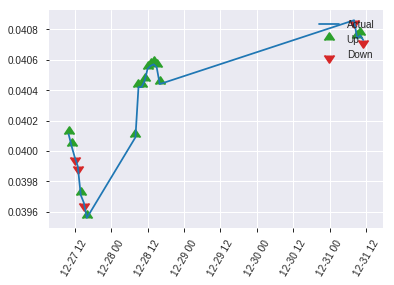


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20668791949496537
RMSE: 0.4546294309599472
LogLoss: 0.6254844103981756
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.326046881648
Residual deviance: 278.9660470375863
AIC: 380.9660470375863
AUC: 0.7478354978354977
pr_auc: 0.6470712270863068
Gini: 0.4956709956709955
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32769175027517194: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   77   0.5833   (77.0/132.0)
1      7    84   0.0769   (7.0/91.0)
Total  62   161  0.3767   (84.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327692     0.666667  160
max f2                       0.327692     0.8       160
max f0point5                 0.637067     0.6469    69
max accuracy                 0.637067     0.70852   69
max precision                0.971422     1         0
max recall                   0.000775755  1         222
max specificity              0.971422     1         0
max absolute_mcc             0.462391     0.388351  116
max min_per_class_accuracy   0.524527     0.659341  102
max mean_per_class_accuracy  0.462391     0.697303  116

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 49.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.954283           0.81685   0.81685            0.333333         0.963896  0.333333                    0.963896            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.935559           2.45055   1.47033            1                0.94347   0.6                         0.955726            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.88947            2.45055   1.75039            1                0.910787  0.714286                    0.942886            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.873507           2.45055   1.90598            1                0.885623  0.777778                    0.930161            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.865106           2.45055   2.04212            1                0.869618  0.833333                    0.915025            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.814388           2.22777   2.13091            0.909091         0.838242  0.869565                    0.878303            0.10989         0.21978                    122.777   113.091
    7        0.152466                    0.738257           1.33666   1.87395            0.545455         0.763577  0.764706                    0.841186            0.0659341       0.285714                   33.6663   87.395
    8        0.201794                    0.7103             1.11389   1.68816            0.454545         0.724461  0.688889                    0.812653            0.0549451       0.340659                   11.3886   68.8156
    9        0.300448                    0.638032           1.55944   1.64589            0.636364         0.673445  0.671642                    0.766943            0.153846        0.494505                   55.9441   64.5891
    10       0.399103                    0.555721           1.11389   1.51438            0.454545         0.608124  0.617978                    0.727685            0.10989         0.604396                   11.3886   51.4384
    11       0.502242                    0.475255           1.06546   1.42219            0.434783         0.518833  0.580357                    0.684795            0.10989         0.714286                   6.54563   42.2194
    12       0.600897                    0.413324           0.891109  1.335              0.363636         0.444745  0.544776                    0.645384            0.0879121       0.802198                   -10.8891  33.5001
    13       0.699552                    0.351327           1.0025    1.28811            0.409091         0.382873  0.525641                    0.608363            0.0989011       0.901099                   0.24975   28.8109
    14       0.798206                    0.276289           0.334166  1.17021            0.136364         0.306348  0.477528                    0.571036            0.032967        0.934066                   -66.5834  17.0206
    15       0.896861                    0.171926           0.222777  1.06599            0.0909091        0.234131  0.435                       0.533976            0.021978        0.956044                   -77.7223  6.5989
    16       1                           0.000775755        0.426183  1                  0.173913         0.117723  0.408072                    0.491044            

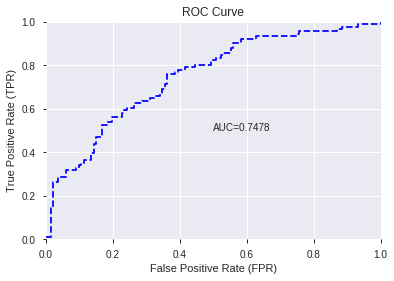

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


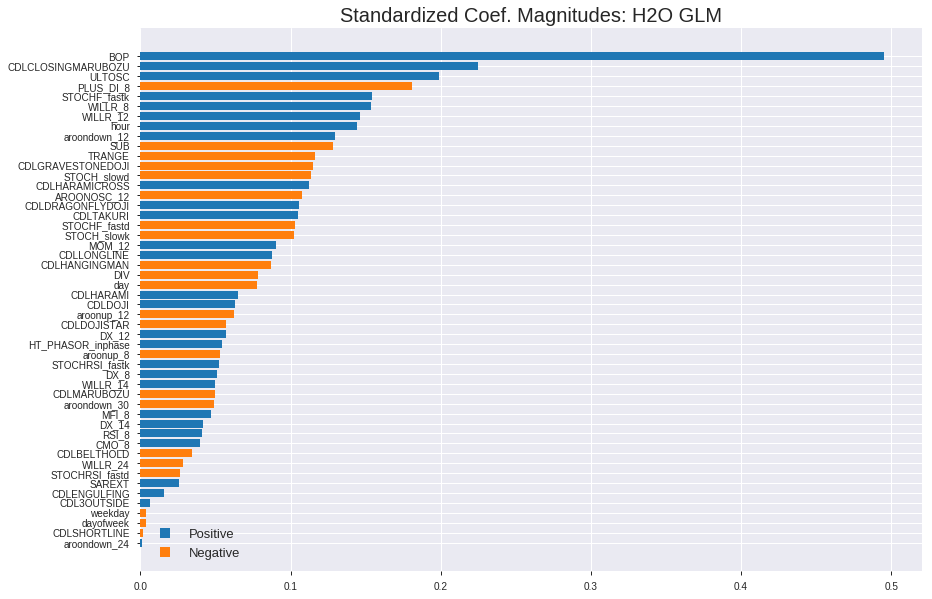

'log_likelihood'
--2019-09-03 03:28:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_032827_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_032827_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'WILLR_8',
 'WILLR_12',
 'hour',
 'aroondown_12',
 'SUB',
 'TRANGE',
 'CDLGRAVESTONEDOJI',
 'STOCH_slowd',
 'CDLHARAMICROSS',
 'AROONOSC_12',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MOM_12',
 'CDLLONGLINE',
 'CDLHANGINGMAN',
 'DIV',
 'day',
 'CDLHARAMI',
 'CDLDOJI',
 'aroonup_12',
 'CDLDOJISTAR',
 'DX_12',
 'HT_PHASOR_inphase',
 'aroonup_8',
 'STOCHRSI_fastk',
 'DX_8',
 'WILLR_14',
 'CDLMARUBOZU',
 'aroondown_30',
 'MFI_8',
 'DX_14',
 'RSI_8',
 'CMO_8',
 'CDLBELTHOLD',
 'WILLR_24',
 'STOCHRSI_fastd',
 'SAREXT',
 'CDLENGULFING',
 'CDL3OUTSIDE',
 'weekday',
 'dayofweek',
 'CDLSHORTLINE',
 'aroondown_24']

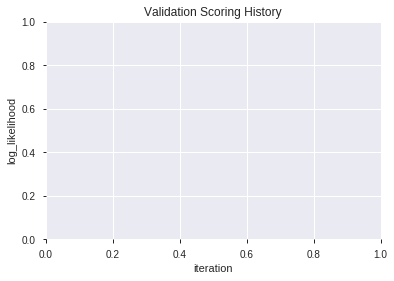

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_032844_model_1  0.756202  0.589706              0.323510  0.451584  0.203928
1  XGBoost_grid_1_AutoML_20190903_032844_model_6  0.751499  0.597544              0.324259  0.455168  0.207178
2  XGBoost_grid_1_AutoML_20190903_032844_model_2  0.750083  0.592467              0.318390  0.452770  0.205000
3               XGBoost_3_AutoML_20190903_032844  0.749500  0.592459              0.320097  0.452234  0.204516
4  XGBoost_grid_1_AutoML_20190903_032844_model_3  0.747586  0.598526              0.310440  0.454873  0.206910
5  XGBoost_grid_1_AutoML_20190903_032844_model_4  0.743964  0.606201              0.313478  0.458753  0.210454
6  XGBoost_grid_1_AutoML_20190903_032844_model_7  0.742091  0.605407              0.346029  0.458922  0.210610
7               XGBoost_2_AutoML_20190903_032844  0.736097  0.612149              0.331086  0.461015  0.212535
8               XGBoost_1_AutoML_20190903_032844  0.730103  0.616116              0.339411  0.462019  0.213462
9  XGBoost_grid_1_AutoML_20190903_032844_model_5  0.708375  0.661041              0.336414  0.481511  0.231853

variable  relative_importance  scaled_importance  percentage
0                  BOP          2955.582031           1.000000    0.372920
1         STOCHF_fastk           381.478119           0.129070    0.048133
2                  DIV           372.888092           0.126164    0.047049
3   CDLCLOSINGMARUBOZU           368.029938           0.124520    0.046436
4               TRANGE           323.899811           0.109589    0.040868
5                 hour           295.636871           0.100027    0.037302
6               ULTOSC           278.898163           0.094363    0.035190
7             WILLR_12           210.622345           0.071263    0.026575
8            PLUS_DI_8           188.998138           0.063946    0.023847
9       STOCHRSI_fastd           183.851501           0.062205    0.023197
10            WILLR_14           183.276489           0.062010    0.023125
11           aroonup_8           168.439972           0.056990    0.021253
12             WILLR_8           145.990326           0.049395    0.018420
13      STOCHRSI_fastk           129.668610           0.043872    0.016361
14               DX_14           125.678741           0.042523    0.015857
15   HT_PHASOR_inphase           121.775215           0.041202    0.015365
16                DX_8           116.004051           0.039249    0.014637
17            WILLR_24           113.054718           0.038251    0.014265
18        aroondown_30           107.751724           0.036457    0.013596
19                 SUB           104.417824           0.035329    0.013175
20          aroonup_12            94.477051           0.031966    0.011921
21         STOCH_slowd            84.673721           0.028649    0.010684
22    CDLDRAGONFLYDOJI            81.978783           0.027737    0.010344
23               DX_12            79.653534           0.026950    0.010050
24              MOM_12            78.263168           0.026480    0.009875
25         STOCH_slowk            69.223015           0.023421    0.008734
26        aroondown_24            69.071938           0.023370    0.008715
27               CMO_8            66.140869           0.022378    0.008345
28        aroondown_12            65.056320           0.022011    0.008208
29                 day            62.188381           0.021041    0.007847
30              SAREXT            59.816490           0.020238    0.007547
31         AROONOSC_12            53.322643           0.018041    0.006728
32               MFI_8            48.855385           0.016530    0.006164
33           dayofweek            36.210621           0.012252    0.004569
34   CDLGRAVESTONEDOJI            28.713873           0.009715    0.003623
35         CDLBELTHOLD            24.802595           0.008392    0.003129
36        STOCHF_fastd            22.354580           0.007564    0.002821
37           CDLTAKURI            18.007910           0.006093    0.002272
38           CDLHARAMI             5.134235           0.001737    0.000648
39               RSI_8             1.624748           0.000550    0.000205

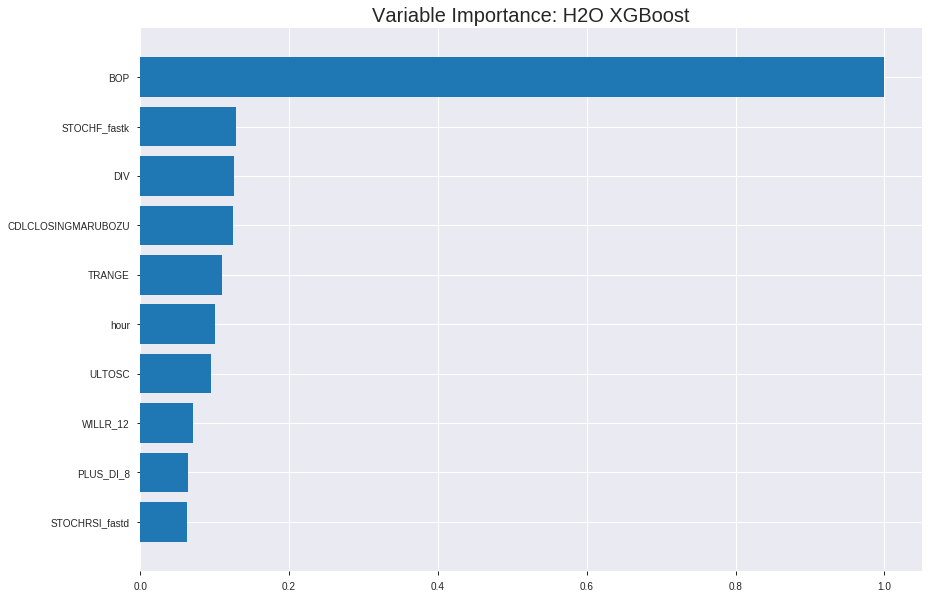

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_032844_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1413204447833881
RMSE: 0.3759261161230862
LogLoss: 0.445824116536476
Mean Per-Class Error: 0.18178112095946974
AUC: 0.9043932958102101
pr_auc: 0.9019707009948574
Gini: 0.8087865916204202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5151497721672058: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      616  172  0.2183   (172.0/788.0)
1      114  658  0.1477   (114.0/772.0)
Total  730  830  0.1833   (286.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51515      0.821473  200
max f2                       0.309869     0.895434  288
max f0point5                 0.600878     0.830292  155
max accuracy                 0.525212     0.817949  196
max precision                0.957145     1         0
max recall                   0.20207      1         331
max specificity              0.957145     1         0
max absolute_mcc             0.525212     0.637083  196
max min_per_class_accuracy   0.54445      0.813472  186
max mean_per_class_accuracy  0.525212     0.818219  196

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.924811           2.02073    2.02073            1                0.937232   1                           0.937232            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.912664           2.02073    2.02073            1                0.918302   1                           0.927767            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.900379           2.02073    2.02073            1                0.906311   1                           0.92092             0.0194301       0.0608808                  102.073   102.073
    4        0.0403846                   0.886146           2.02073    2.02073            1                0.895957   1                           0.91458             0.0207254       0.0816062                  102.073   102.073
    5        0.05                        0.87137            2.02073    2.02073            1                0.880256   1                           0.907979            0.0194301       0.101036                   102.073   102.073
    6        0.1                         0.783917           1.96891    1.99482            0.974359         0.826913   0.987179                    0.867446            0.0984456       0.199482                   96.8912   99.4819
    7        0.15                        0.733846           1.96891    1.98618            0.974359         0.753566   0.982906                    0.829486            0.0984456       0.297927                   96.8912   98.6183
    8        0.2                         0.70633            1.89119    1.96244            0.935897         0.719476   0.971154                    0.801984            0.0945596       0.392487                   89.1192   96.2435
    9        0.3                         0.654301           1.68394    1.8696             0.833333         0.681163   0.925214                    0.76171             0.168394        0.560881                   68.3938   86.9603
    10       0.4                         0.601298           1.41192    1.75518            0.698718         0.628723   0.86859                     0.728463            0.141192        0.702073                   41.1917   75.5181
    11       0.5                         0.539319           1.1399     1.63212            0.564103         0.575724   0.807692                    0.697916            0.11399         0.816062                   13.9896   63.2124
    12       0.6                         0.452832           0.790155   1.4918             0.391026         0.499202   0.738248                    0.664797            0.0790155       0.895078                   -20.9845  49.1796
    13       0.7                         0.348723           0.686528   1.37676            0.339744         0.40278    0.681319                    0.627366            0.0686528       0.963731                   -31.3472  37.6758
    14       0.8                         0.228141           0.336788   1.24676            0.166667         0.285556   0.616987                    0.584639            0.0336788       0.997409                   -66.3212  24.6762
    15       0.9                         0.13636            0.0259067  1.11111            0.0128205        0.178267   0.549858                    0.539487            0.00259067      1                          -97.4093  11.1111
    16       1                           0.0481797          0          1                  0                0.0965406  0.494872 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.204629302815328
RMSE: 0.4523597051189772
LogLoss: 0.5927343406739602
Mean Per-Class Error: 0.313794498381877
AUC: 0.7426274271844661
pr_auc: 0.692531003833535
Gini: 0.4852548543689321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41028907895088196: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  118  0.4917   (118.0/240.0)
1      28   178  0.1359   (28.0/206.0)
Total  150  296  0.3274   (146.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410289     0.709163  255
max f2                       0.156141     0.831967  351
max f0point5                 0.643244     0.663717  99
max accuracy                 0.643244     0.67713   99
max precision                0.951716     1         0
max recall                   0.0859284    1         381
max specificity              0.951716     1         0
max absolute_mcc             0.410289     0.39298   255
max min_per_class_accuracy   0.525874     0.660194  184
max mean_per_class_accuracy  0.410289     0.686206  255

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 48.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.919114           1.73204   1.73204            0.8              0.928429   0.8                         0.928429            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.895987           2.16505   1.92449            1                0.910097   0.888889                    0.920281            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.861025           2.16505   2.0104             1                0.874007   0.928571                    0.903755            0.0242718       0.0631068                  116.505   101.04
    4        0.0403587                   0.840163           2.16505   2.04477            1                0.848356   0.944444                    0.891444            0.0194175       0.0825243                  116.505   104.477
    5        0.0515695                   0.820213           0.866019  1.78852            0.4              0.829375   0.826087                    0.877951            0.00970874      0.092233                   -13.3981  78.8518
    6        0.100897                    0.748704           1.57458   1.68393            0.727273         0.782325   0.777778                    0.8312              0.0776699       0.169903                   57.4581   68.3927
    7        0.150224                    0.711637           1.47617   1.61571            0.681818         0.727831   0.746269                    0.797258            0.0728155       0.242718                   47.6169   61.5708
    8        0.201794                    0.67654            1.60025   1.61176            0.73913          0.690758   0.744444                    0.770042            0.0825243       0.325243                   60.0253   61.1758
    9        0.300448                    0.622447           1.37776   1.53492            0.636364         0.650319   0.708955                    0.73073             0.135922        0.461165                   37.7758   53.4922
    10       0.401345                    0.572642           1.10658   1.42724            0.511111         0.597093   0.659218                    0.697134            0.11165         0.572816                   10.658    42.7239
    11       0.5                         0.519389           1.13173   1.36893            0.522727         0.544002   0.632287                    0.66692             0.11165         0.684466                   13.173    36.8932
    12       0.600897                    0.456728           1.01036   1.30872            0.466667         0.492102   0.604478                    0.637566            0.101942        0.786408                   1.0356    30.8723
    13       0.699552                    0.355606           0.836496  1.24213            0.386364         0.412425   0.573718                    0.605815            0.0825243       0.868932                   -16.3504  24.2127
    14       0.800448                    0.233663           0.577346  1.15833            0.266667         0.291379   0.535014                    0.56618             0.0582524       0.927184                   -42.2654  15.8331
    15       0.899103                    0.141468           0.590468  1.09602            0.272727         0.186322   0.506234                    0.5245              0.0582524       0.985437                   -40.9532  9.60221
    16       1                           0.045263           0.144337  1                  0.0666667        0.0948546  0.461883                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:28:49  0.028 sec   0                  0.5              0.693147            0.5             0                  1                0.505128                         0.5                0.693147              0.5               0                    1                  0.538117
    2019-09-03 03:28:49  0.141 sec   5                  0.469499         0.63348             0.837566        0.800992           2.02073          0.270513                         0.481719           0.656919              0.708455          0.658275             2.16505            0.378924
    2019-09-03 03:28:49  0.219 sec   10                 0.449423         0.594496            0.844479        0.821369           2.02073          0.261538                         0.47132            0.635875              0.720459          0.674172             1.89442            0.338565
    2019-09-03 03:28:49  0.286 sec   15                 0.434215         0.564418            0.85149         0.840239           2.02073          0.267949                         0.465042           0.622558              0.724828          0.675454             2.16505            0.343049
    2019-09-03 03:28:49  0.349 sec   20                 0.42365          0.542592            0.856303        0.847724           2.02073          0.254487                         0.461095           0.613399              0.724848          0.671908             1.73204            0.336323
    2019-09-03 03:28:49  0.417 sec   25                 0.414133         0.522765            0.861729        0.855027           2.02073          0.226923                         0.458826           0.607872              0.724181          0.669414             1.73204            0.327354
    2019-09-03 03:28:49  0.491 sec   30                 0.405473         0.505251            0.873342        0.866741           2.02073          0.225                            0.455712           0.601127              0.734739          0.679078             1.73204            0.325112
    2019-09-03 03:28:49  0.562 sec   35                 0.399094         0.49194             0.879134        0.87441            2.02073          0.225                            0.454356           0.597916              0.737561          0.685628             2.16505            0.329596
    2019-09-03 03:28:49  0.626 sec   40                 0.393523         0.480411            0.884404        0.880263           2.02073          0.220513                         0.45308            0.594984              0.741151          0.689863             1.73204            0.329596
    2019-09-03 03:28:49  0.692 sec   45                 0.388215         0.469767            0.8902          0.887771           2.02073          0.214103                         0.453148           0.594694              0.741424          0.689805             1.73204            0.327354
    2019-09-03 03:28:49  0.756 sec   50                 0.383633         0.460808            0.896175        0.894155           2.02073          0.20641                          0.452417           0.592953              0.742547          0.690142             1.73204            0.32287
    2019-09-03 03:28:49  0.818 sec   55                 0.38023          0.453931            0.899485        0.896939           2.02073          0.199359                         0.45279            0.59368               0.741687          0.

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2955.58203125          1.0                    0.3729199866921449
STOCHF_fastk        381.4781188964844      0.12907038778251956    0.04813292729420717
DIV                 372.8880920410156      0.12616401375376837    0.04704908233008288
CDLCLOSINGMARUBOZU  368.0299377441406      0.12452029206189559    0.04643610565862409
TRANGE              323.8998107910156      0.10958917985234508    0.04086799549213959
---                 ---                    ---                    ---
CDLBELTHOLD         24.802595138549805     0.008391780324926417   0.0031294626070949624
STOCHF_fastd        22.35457992553711      0.007563511920554856   0.0028205847647591958
CDLTAKURI           18.007909774780273     0.006092847224126685   0.0022721445057385953
CDLHARAMI           5.134235382080078      0.0017371317486013622  0.0006478111485709223
RSI_8               1.6247482299804688     0.000549721920353304   0.00020500229122253442


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.6638655462184875)

('auc', 0.7562021312021312)

('logloss', 0.589706389842091)

('mean_per_class_error', 0.30044955044955046)

('rmse', 0.45158357161392443)

('mse', 0.20392772215158841)

xgboost prediction progress: |████████████████████████████████████████████| 100%


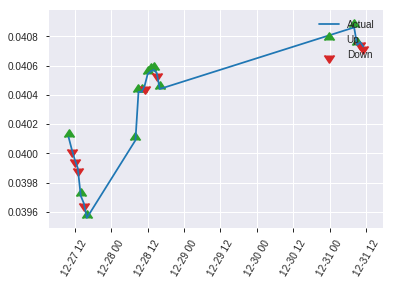


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20392772215158841
RMSE: 0.45158357161392443
LogLoss: 0.589706389842091
Mean Per-Class Error: 0.30044955044955046
AUC: 0.7562021312021312
pr_auc: 0.6886230527152297
Gini: 0.5124042624042624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3607562780380249: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   68   0.5152   (68.0/132.0)
1      12   79   0.1319   (12.0/91.0)
Total  76   147  0.3587   (80.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360756     0.663866  145
max f2                       0.230522     0.797774  173
max f0point5                 0.651647     0.652742  72
max accuracy                 0.651647     0.713004  72
max precision                0.910689     1         0
max recall                   0.10617      1         210
max specificity              0.910689     1         0
max absolute_mcc             0.61528      0.402125  85
max min_per_class_accuracy   0.562297     0.674242  103
max mean_per_class_accuracy  0.61528      0.69955   85

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 48.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.89142            2.45055   2.45055            1                0.900819  1                           0.900819            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.867832           2.45055   2.45055            1                0.874491  1                           0.890288            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.856366           2.45055   2.45055            1                0.862335  1                           0.882301            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.848486           2.45055   2.45055            1                0.853501  1                           0.875901            0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.837124           0.81685   2.04212            0.333333         0.841781  0.833333                    0.867371            0.010989        0.10989                    -18.315   104.212
    6        0.103139                    0.759546           2.45055   2.23746            1                0.794324  0.913043                    0.832436            0.120879        0.230769                   145.055   123.746
    7        0.152466                    0.727545           1.55944   2.0181             0.636364         0.742662  0.823529                    0.803391            0.0769231       0.307692                   55.9441   101.81
    8        0.201794                    0.713374           1.11389   1.79707            0.454545         0.719456  0.733333                    0.782874            0.0549451       0.362637                   11.3886   79.707
    9        0.300448                    0.666698           1.33666   1.64589            0.545455         0.691385  0.671642                    0.752833            0.131868        0.494505                   33.6663   64.5891
    10       0.399103                    0.610529           1.33666   1.56945            0.545455         0.636741  0.640449                    0.724136            0.131868        0.626374                   33.6663   56.9453
    11       0.502242                    0.544042           0.745819  1.40031            0.304348         0.574007  0.571429                    0.693306            0.0769231       0.703297                   -25.4181  40.0314
    12       0.600897                    0.411215           0.77972   1.29843            0.318182         0.475129  0.529851                    0.657486            0.0769231       0.78022                    -22.028   29.8425
    13       0.699552                    0.306186           0.891109  1.24098            0.363636         0.364472  0.50641                     0.616163            0.0879121       0.868132                   -10.8891  24.0983
    14       0.798206                    0.221594           0.77972   1.18397            0.318182         0.260256  0.483146                    0.572175            0.0769231       0.945055                   -22.028   18.3973
    15       0.896861                    0.140477           0.334166  1.09049            0.136364         0.177453  0.445                       0.528755            0.032967        0.978022                   -66.5834  9.04945
    16       1                           0.0801669          0.213091  1                  0.0869565        0.104587  0.408072                    0.485007           

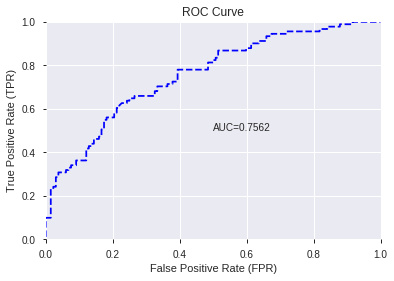

This function is available for GLM models only


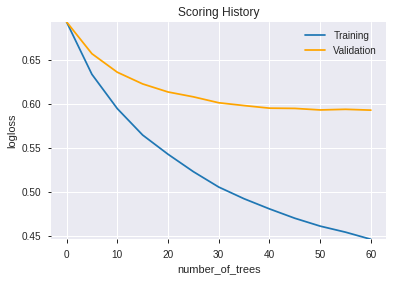

--2019-09-03 03:29:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.244
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.244|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedTreeSubgraph.java:82)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftChildNode(SharedTreeSubgraph.java:65)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constr

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_032844_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_032844_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'hour',
 'ULTOSC',
 'WILLR_12',
 'PLUS_DI_8',
 'STOCHRSI_fastd',
 'WILLR_14',
 'aroonup_8',
 'WILLR_8',
 'STOCHRSI_fastk',
 'DX_14',
 'HT_PHASOR_inphase',
 'DX_8',
 'WILLR_24',
 'aroondown_30',
 'SUB',
 'aroonup_12',
 'STOCH_slowd',
 'CDLDRAGONFLYDOJI',
 'DX_12',
 'MOM_12',
 'STOCH_slowk',
 'aroondown_24',
 'CMO_8',
 'aroondown_12',
 'day',
 'SAREXT',
 'AROONOSC_12',
 'MFI_8',
 'dayofweek',
 'CDLGRAVESTONEDOJI',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLTAKURI',
 'CDLHARAMI',
 'RSI_8']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 906] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


55

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MINUS_DM_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_032915_model_9  0.772727  0.595144              0.275599  0.445576  0.198538
1  DeepLearning_grid_1_AutoML_20190903_032915_model_7  0.772561  0.620068              0.275808  0.447107  0.199905
2  DeepLearning_grid_1_AutoML_20190903_032915_model_6  0.771562  0.589060              0.300033  0.445486  0.198458
3  DeepLearning_grid_1_AutoML_20190903_032915_model_8  0.768315  0.608709              0.280719  0.442132  0.195481
4  DeepLearning_grid_1_AutoML_20190903_032915_model_3  0.765485  0.745081              0.265568  0.443017  0.196264
5  DeepLearning_grid_1_AutoML_20190903_032915_model_5  0.764236  0.637327              0.294164  0.469177  0.220127
6               DeepLearning_1_AutoML_20190903_032915  0.756993  0.724516              0.301740  0.486365  0.236551
7  DeepLearning_grid_1_AutoML_20190903_032915_model_1  0.756161  0.796928              0.292458  0.465883  0.217047
8  DeepLearning_grid_1_AutoML_20190903_032915_model_2  0.756161  0.775327              0.298535  0.493719  0.243759
9  DeepLearning_grid_1_AutoML_20190903_032915_model_4  0.712204  1.317293              0.355519  0.570285  0.325225

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.045698
1   CDLCLOSINGMARUBOZU             0.944377           0.944377    0.043156
2          CDLLONGLINE             0.730935           0.730935    0.033402
3               TRANGE             0.567433           0.567433    0.025931
4                  SUB             0.565629           0.565629    0.025848
5     CDLDRAGONFLYDOJI             0.563936           0.563936    0.025771
6            CDLTAKURI             0.551036           0.551036    0.025181
7                  DIV             0.529839           0.529839    0.024213
8         CDLSHORTLINE             0.501944           0.501944    0.022938
9          CDLMARUBOZU             0.497232           0.497232    0.022723
10              ULTOSC             0.494606           0.494606    0.022603
11               ADOSC             0.467176           0.467176    0.021349
12        STOCHF_fastk             0.437173           0.437173    0.019978
13      STOCHRSI_fastk             0.411680           0.411680    0.018813
14              CCI_14             0.399809           0.399809    0.018271
15              CCI_20             0.390705           0.390705    0.017855
16         CDLBELTHOLD             0.388245           0.388245    0.017742
17            WILLR_12             0.387926           0.387926    0.017728
18              CCI_12             0.387832           0.387832    0.017723
19             WILLR_8             0.384104           0.384104    0.017553
20        STOCHF_fastd             0.379335           0.379335    0.017335
21         STOCH_slowk             0.376934           0.376934    0.017225
22               CCI_8             0.369806           0.369806    0.016900
23         MINUS_DM_12             0.362444           0.362444    0.016563
24          MINUS_DM_8             0.355556           0.355556    0.016248
25               MOM_8             0.351941           0.351941    0.016083
26        CDLENGULFING             0.345574           0.345574    0.015792
27         MINUS_DM_14             0.340817           0.340817    0.015575
28              ROCR_8             0.335395           0.335395    0.015327
29           ROCR100_8             0.334672           0.334672    0.015294
30              ROCP_8             0.334150           0.334150    0.015270
31      STOCHRSI_fastd             0.333744           0.333744    0.015252
32            WILLR_30             0.327528           0.327528    0.014967
33            WILLR_20             0.324994           0.324994    0.014852
34          ROCR100_12             0.319671           0.319671    0.014608
35             ROCP_12             0.317151           0.317151    0.014493
36               ROC_8             0.315402           0.315402    0.014413
37            WILLR_24             0.314092           0.314092    0.014353
38               RSI_8             0.311159           0.311159    0.014219
39              ROC_12             0.310730           0.310730    0.014200
40              RSI_20             0.309759           0.309759    0.014155
41              MOM_12             0.309419           0.309419    0.014140
42              CMO_14             0.308965           0.308965    0.014119
43            WILLR_14             0.307819           0.307819    0.014067
44              RSI_24             0.307355           0.307355    0.014046
45          MINUS_DI_8             0.304647           0.304647    0.013922
46              RSI_12             0.303724           0.303724    0.013880
47              CMO_30             0.300160           0.300160    0.013717
48             ROCR_12             0.300158           0.300158    0.013717
49              RSI_14             0.297824           0.297824    0.013610
50              CMO_24             0.297347           0.297347    0.013588
51              CMO_12             0.296195           0.296195    0.013536
52              RSI_30             0.29

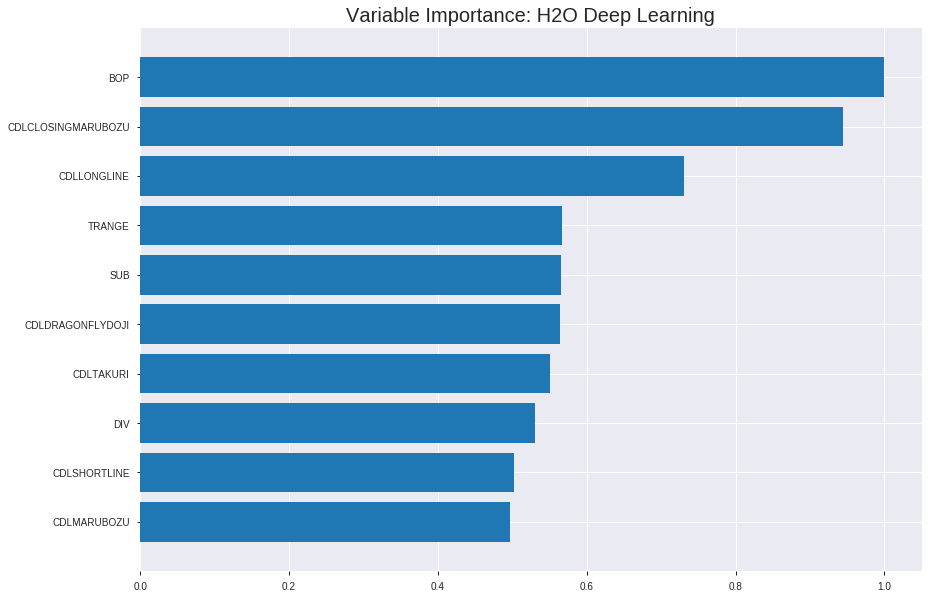

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_032915_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1904779866743897
RMSE: 0.4364378382706863
LogLoss: 0.5619577286631358
Mean Per-Class Error: 0.29083269771968123
AUC: 0.7847571079140474
pr_auc: 0.7739335060793543
Gini: 0.5695142158280948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4051195973646319: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      388  400   0.5076   (400.0/788.0)
1      79   693   0.1023   (79.0/772.0)
Total  467  1093  0.3071   (479.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40512      0.743164  262
max f2                       0.276039     0.845183  316
max f0point5                 0.55211      0.70593   179
max accuracy                 0.532371     0.708974  193
max precision                0.93955      1         0
max recall                   0.113316     1         392
max specificity              0.93955      1         0
max absolute_mcc             0.473118     0.429191  230
max min_per_class_accuracy   0.536625     0.707254  190
max mean_per_class_accuracy  0.52969      0.709167  195

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.932784           2.02073   2.02073            1                0.936364  1                           0.936364            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.926358           2.02073   2.02073            1                0.929782  1                           0.933073            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.922064           1.7513    1.93474            0.866667         0.924129  0.957447                    0.930219            0.0168394       0.0582902                  75.1295   93.4737
    4        0.0403846                   0.896573           1.64184   1.86035            0.8125           0.910702  0.920635                    0.925262            0.0168394       0.0751295                  64.1839   86.035
    5        0.05                        0.883891           1.88601   1.86528            0.933333         0.88943   0.923077                    0.918371            0.0181347       0.0932642                  88.601    86.5285
    6        0.1                         0.791047           1.83938   1.85233            0.910256         0.839452  0.916667                    0.878912            0.0919689       0.185233                   83.9378   85.2332
    7        0.15                        0.703897           1.60622   1.77029            0.794872         0.742584  0.876068                    0.833469            0.0803109       0.265544                   60.6218   77.0294
    8        0.2                         0.665717           1.47668   1.69689            0.730769         0.680088  0.839744                    0.795124            0.0738342       0.339378                   47.6684   69.6891
    9        0.3                         0.618781           1.32124   1.57168            0.653846         0.640893  0.777778                    0.743714            0.132124        0.471503                   32.1244   57.1675
    10       0.4                         0.583323           1.19171   1.47668            0.589744         0.601406  0.730769                    0.708137            0.119171        0.590674                   19.171    47.6684
    11       0.5                         0.534878           1.19171   1.41969            0.589744         0.558566  0.702564                    0.678223            0.119171        0.709845                   19.171    41.9689
    12       0.6                         0.485481           0.971503  1.34499            0.480769         0.512485  0.665598                    0.6506              0.0971503       0.806995                   -2.84974  34.4991
    13       0.7                         0.404519           0.906736  1.28238            0.448718         0.450829  0.634615                    0.622061            0.0906736       0.897668                   -9.32642  28.2383
    14       0.8                         0.294806           0.479275  1.18199            0.237179         0.352275  0.584936                    0.588338            0.0479275       0.945596                   -52.0725  18.1995
    15       0.9                         0.206992           0.375648  1.0924             0.185897         0.247187  0.540598                    0.550432            0.0375648       0.983161                   -62.4352  9.24007
    16       1                           0.0702831          0.168394  1                  0.0833333        0.166701  0.494872                    0.512059          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19799920039788965
RMSE: 0.444971010738778
LogLoss: 0.5792758434341192
Mean Per-Class Error: 0.29281957928802593
AUC: 0.7637944983818771
pr_auc: 0.7120636103492727
Gini: 0.5275889967637541
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3624054420446021: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  131  0.5458   (131.0/240.0)
1      22   184  0.1068   (22.0/206.0)
Total  131  315  0.343    (153.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362405     0.706334  277
max f2                       0.260488     0.835443  322
max f0point5                 0.539215     0.690184  168
max accuracy                 0.539215     0.710762  168
max precision                0.819215     0.909091  31
max recall                   0.182625     1         369
max specificity              0.937586     0.995833  0
max absolute_mcc             0.538817     0.416451  169
max min_per_class_accuracy   0.524545     0.684466  185
max mean_per_class_accuracy  0.538817     0.70718   169

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.928306           1.73204    1.73204            0.8              0.931798  0.8                         0.931798            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.922805           1.62379    1.68393            0.75             0.925234  0.777778                    0.928881            0.0145631       0.0339806                  62.3786   68.3927
    3        0.0313901                   0.911549           1.73204    1.70111            0.8              0.919071  0.785714                    0.925377            0.0194175       0.0533981                  73.2039   70.111
    4        0.0403587                   0.888606           2.16505    1.80421            1                0.897168  0.833333                    0.919109            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.876208           2.16505    1.88265            1                0.883934  0.869565                    0.911462            0.0242718       0.0970874                  116.505   88.2651
    6        0.100897                    0.765298           1.96823    1.92449            0.909091         0.810538  0.888889                    0.862121            0.0970874       0.194175                   96.8226   92.4488
    7        0.150224                    0.678047           1.37776    1.74496            0.636364         0.715133  0.80597                     0.813857            0.0679612       0.262136                   37.7758   74.4964
    8        0.201794                    0.645479           1.41199    1.65987            0.652174         0.66156   0.766667                    0.774936            0.0728155       0.334951                   41.1988   65.9871
    9        0.300448                    0.597891           1.47617    1.59955            0.681818         0.624149  0.738806                    0.725424            0.145631        0.480583                   47.6169   59.9551
    10       0.401345                    0.549029           1.25092    1.51191            0.577778         0.577962  0.698324                    0.688353            0.126214        0.606796                   25.0917   51.1905
    11       0.5                         0.515634           0.934907   1.39806            0.431818         0.533458  0.64574                     0.65779             0.092233        0.699029                   -6.50927  39.8058
    12       0.600897                    0.471025           0.866019   1.30872            0.4              0.495616  0.604478                    0.63056             0.0873786       0.786408                   -13.3981  30.8723
    13       0.699552                    0.366083           0.934907   1.25601            0.431818         0.423005  0.580128                    0.601289            0.092233        0.878641                   -6.50927  25.6006
    14       0.800448                    0.263693           0.769795   1.19472            0.355556         0.313654  0.551821                    0.565033            0.0776699       0.956311                   -23.0205  19.4719
    15       0.899103                    0.194747           0.34444    1.10142            0.159091         0.228503  0.508728                    0.528107            0.0339806       0.990291                   -65.556   10.1421
    16       1                           0.0761695          0.0962244  1                  0.0444444        0.161385  0.461883                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:35:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:35:25  2 min  0.720 sec  526 obs/sec       0.65641   1             1024       0.494808         0.777545            0.0205585      0.729072        0.703604           1.76813          0.346154                         0.530719           0.877627              -0.133238        0.681129          0.622115             2.16505            0.381166
    2019-09-03 03:35:34  2 min  9.882 sec  805 obs/sec       5.29679   8             8263       0.445811         0.579258            0.204925       0.766384        0.757657           1.89443          0.313462                         0.457118           0.605172              0.159286         0.733586          0.680113             1.29903            0.401345
    2019-09-03 03:35:43  2 min 18.930 sec  948 obs/sec       11.2269   17            17514      0.444334         0.578318            0.210187       0.772524        0.761314           1.89443          0.315385                         0.449642           0.59128               0.186562         0.762854          0.698729             1.29903            0.309417
    2019-09-03 03:35:52  2 min 27.581 sec  1058 obs/sec      17.8282   27            27812      0.44259          0.575147            0.216373       0.776078        0.766015           1.89443          0.298718                         0.451599           0.591132              0.179466         0.749616          0.692544             1.73204            0.352018
    2019-09-03 03:36:00  2 min 36.185 sec  1150 obs/sec      25.091    38            39142      0.439245         0.567692            0.228175       0.779849        0.768834           1.89443          0.319231                         0.449779           0.588328              0.186066         0.752771          0.695072             1.29903            0.38565
    2019-09-03 03:36:09  2 min 44.921 sec  1229 obs/sec      33.0083   50            51493      0.436438         0.561958            0.238008       0.784757        0.773934           2.02073          0.307051                         0.444971           0.579276              0.203374         0.763794          0.712064             1.73204            0.343049
    2019-09-03 03:36:18  2 min 53.668 sec  1301 obs/sec      41.5301   63            64787      0.433444         0.555869            0.248426       0.78818         0.777619           2.02073          0.291667                         0.449609           0.585696              0.186681         0.751153          0.697931             1.29903            0.367713
    2019-09-03 03:36:19  2 min 54.525 sec  1300 obs/sec      41.5301   63            64787      0.436438         0.561958            0.238008       0.784757        0.773934           2.02073          0.307051                         0.444971           0.579276              0.203374         0.763794          0.712064             1.73204            0.343049

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04569825746278421
CDLCLOSINGMARUBOZU  0.9443773627281189     0.9443773627281189   0.04315639986397473
CDLLONGLINE         0.7309350371360779     0.7309350371360779   0.03340245751561423
TRANGE              0.5674331784248352     0.5674331784248352   0.02593070748058409
SUB                 0.5656287670135498     0.5656287670135498   0.025848249023342384
---                 ---                    ---                  ---
CMO_24              0.2973470091819763     0.2973470091819763   0.013588240181386815
CMO_12              0.2961954176425934     0.2961954176425934   0.01353561445472813
RSI_30              0.2937335968017578     0.2937335968017578   0.013423113532116377
CMO_20              0.2919526994228363     0.2919526994228363   0.013341729625179625
CMO_8               0.2909013032913208     0.2909013032913208   0.013293682654066255


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.6972477064220184)

('auc', 0.7727272727272727)

('logloss', 0.595144441416277)

('mean_per_class_error', 0.2755994005994006)

('rmse', 0.44557557807683984)

('mse', 0.19853759577851002)

deeplearning prediction progress: |███████████████████████████████████████| 100%


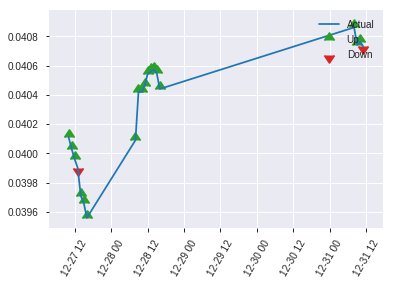


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19853759577851002
RMSE: 0.44557557807683984
LogLoss: 0.595144441416277
Mean Per-Class Error: 0.2755994005994006
AUC: 0.7727272727272727
pr_auc: 0.6875969622626721
Gini: 0.5454545454545454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47942203873371264: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   51   0.3864   (51.0/132.0)
1      15   76   0.1648   (15.0/91.0)
Total  96   127  0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479422     0.697248  126
max f2                       0.242292     0.78712   194
max f0point5                 0.602998     0.665635  57
max accuracy                 0.548751     0.721973  88
max precision                0.926877     1         0
max recall                   0.0043366    1         222
max specificity              0.926877     1         0
max absolute_mcc             0.479422     0.445476  126
max min_per_class_accuracy   0.528004     0.69697   103
max mean_per_class_accuracy  0.479422     0.724401  126

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 49.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.925357           1.6337    1.6337             0.666667         0.92633   0.666667                    0.92633             0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.92402            2.45055   1.96044            1                0.924467  0.8                         0.925585            0.021978        0.043956                   145.055   96.044
    3        0.0313901                   0.922309           1.22527   1.75039            0.5              0.923213  0.714286                    0.924907            0.010989        0.0549451                  22.5275   75.0392
    4        0.0403587                   0.91797            2.45055   1.90598            1                0.92041   0.777778                    0.923908            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.908492           2.45055   2.04212            1                0.914182  0.833333                    0.921477            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.800683           2.45055   2.23746            1                0.855105  0.913043                    0.889733            0.120879        0.230769                   145.055   123.746
    7        0.152466                    0.702686           1.55944   2.0181             0.636364         0.746536  0.823529                    0.843405            0.0769231       0.307692                   55.9441   101.81
    8        0.201794                    0.64181            1.33666   1.85153            0.545455         0.660812  0.755556                    0.798771            0.0659341       0.373626                   33.6663   85.1526
    9        0.300448                    0.580106           1.44805   1.71904            0.590909         0.606499  0.701493                    0.735637            0.142857        0.516484                   44.8052   71.9042
    10       0.399103                    0.548583           1.33666   1.62452            0.545455         0.559977  0.662921                    0.692215            0.131868        0.648352                   33.6663   62.4522
    11       0.502242                    0.509941           0.958911  1.48783            0.391304         0.530868  0.607143                    0.659082            0.0989011       0.747253                   -4.10893  48.7834
    12       0.600897                    0.463891           1.0025    1.40815            0.409091         0.487699  0.574627                    0.630944            0.0989011       0.846154                   0.24975   40.8152
    13       0.699552                    0.391991           0.445554  1.2724             0.181818         0.436318  0.519231                    0.603497            0.043956        0.89011                    -55.4446  27.2401
    14       0.798206                    0.286378           0.222777  1.14267            0.0909091        0.336945  0.466292                    0.570552            0.021978        0.912088                   -77.7223  14.2672
    15       0.896861                    0.218557           0.556943  1.07824            0.227273         0.257615  0.44                        0.536129            0.0549451       0.967033                   -44.3057  7.82418
    16       1                           0.0043366          0.319637  1                  0.130435         0.156538  0.408072                    0.496979            0

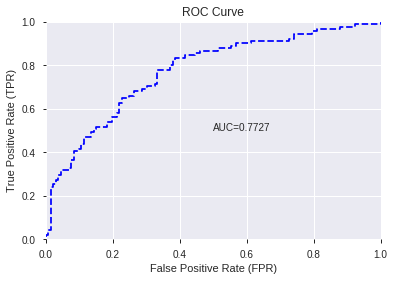

This function is available for GLM models only


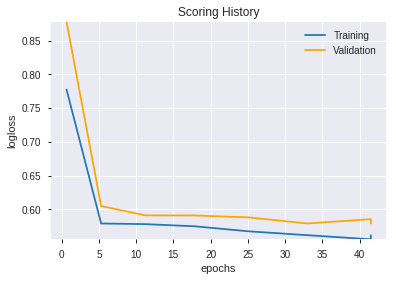

--2019-09-03 03:36:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_032915_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_032915_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'DIV',
 'CDLSHORTLINE',
 'CDLMARUBOZU',
 'ULTOSC',
 'ADOSC',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CCI_14',
 'CCI_20',
 'CDLBELTHOLD',
 'WILLR_12',
 'CCI_12',
 'WILLR_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CCI_8',
 'MINUS_DM_12',
 'MINUS_DM_8',
 'MOM_8',
 'CDLENGULFING',
 'MINUS_DM_14',
 'ROCR_8',
 'ROCR100_8',
 'ROCP_8',
 'STOCHRSI_fastd',
 'WILLR_30',
 'WILLR_20',
 'ROCR100_12',
 'ROCP_12',
 'ROC_8',
 'WILLR_24',
 'RSI_8',
 'ROC_12',
 'RSI_20',
 'MOM_12',
 'CMO_14',
 'WILLR_14',
 'RSI_24',
 'MINUS_DI_8',
 'RSI_12',
 'CMO_30',
 'ROCR_12',
 'RSI_14',
 'CMO_24',
 'CMO_12',
 'RSI_30',
 'CMO_20',
 'CMO_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_033636_model_1  0.770896  0.599228              0.269938  0.440082  0.193672

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.724516           1.000000    0.137707
1               ULTOSC             0.309482           0.427157    0.058823
2              WILLR_8             0.284420           0.392566    0.054059
3   CDLCLOSINGMARUBOZU             0.266371           0.367654    0.050629
4         STOCHF_fastd             0.256788           0.354427    0.048807
5          STOCH_slowk             0.256780           0.354417    0.048806
6         STOCHF_fastk             0.248224           0.342607    0.047180
7             WILLR_12             0.244984           0.338135    0.046564
8               TRANGE             0.214278           0.295753    0.040727
9                  SUB             0.209981           0.289823    0.039911
10              CCI_20             0.148751           0.205310    0.028273
11    CDLDRAGONFLYDOJI             0.141286           0.195007    0.026854
12           CDLTAKURI             0.141056           0.194690    0.026810
13              CCI_14             0.130328           0.179884    0.024771
14         CDLMARUBOZU             0.110725           0.152827    0.021045
15         CDLBELTHOLD             0.108169           0.149299    0.020560
16            WILLR_14             0.098682           0.136203    0.018756
17               CCI_8             0.084118           0.116103    0.015988
18              RSI_30             0.079985           0.110398    0.015203
19              MOM_12             0.079742           0.110063    0.015156
20              CMO_30             0.079174           0.109278    0.015048
21      STOCHRSI_fastd             0.075052           0.103589    0.014265
22               MOM_8             0.065541           0.090462    0.012457
23        CDLSHORTLINE             0.064803           0.089444    0.012317
24              CCI_12             0.059213           0.081728    0.011255
25            WILLR_20             0.056142           0.077489    0.010671
26               CMO_8             0.055889           0.077140    0.010623
27               RSI_8             0.053653           0.074053    0.010198
28         CDLLONGLINE             0.049338           0.068097    0.009378
29              CMO_12             0.047745           0.065899    0.009075
30              RSI_14             0.045338           0.062577    0.008617
31              CMO_14             0.044372           0.061244    0.008434
32            WILLR_24             0.040992           0.056579    0.007791
33              RSI_12             0.040858           0.056393    0.007766
34      STOCHRSI_fastk             0.026724           0.036885    0.005079
35              CMO_24             0.026481           0.036550    0.005033
36        CDLENGULFING             0.026074           0.035989    0.004956
37              RSI_24             0.025167           0.034736    0.004783
38                 DIV             0.023937           0.033039    0.004550
39         MINUS_DM_12             0.023402           0.032301    0.004448
40          MINUS_DI_8             0.019689           0.027175    0.003742
41              ROC_12             0.019264           0.026589    0.003662
42             ROCP_12             0.019043           0.026283    0.003619
43             ROCR_12             0.018941           0.026143    0.003600
44          ROCR100_12             0.018618           0.025697    0.003539
45          MINUS_DM_8             0.018474           0.025498    0.003511
46         MINUS_DM_14             0.014371           0.019835    0.002731
47            WILLR_30             0.013963           0.019273    0.002654
48              RSI_20             0.011753           0.016222    0.002234
49              CMO_20             0.009267           0.012791    0.001761
50           ROCR100_8             0.006279           0.008666    0.001193
51              ROCR_8             0.006231           0.008601    0.001184
52              ROCP_8             0.00

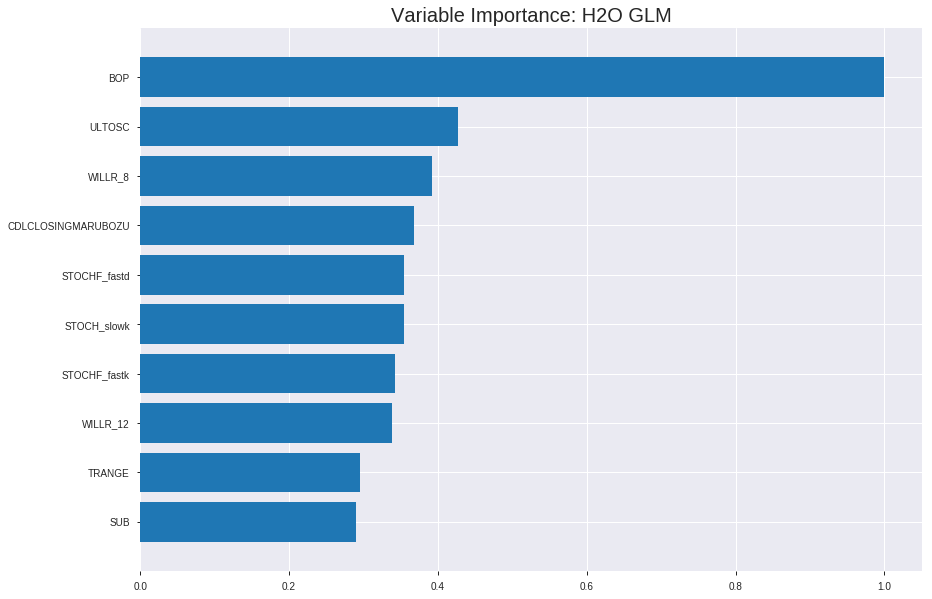

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_033636_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19086360199820393
RMSE: 0.43687939067688225
LogLoss: 0.560690603750627
Null degrees of freedom: 1559
Residual degrees of freedom: 1504
Null deviance: 2162.4550979057067
Residual deviance: 1749.3546837019562
AIC: 1861.3546837019562
AUC: 0.7800335669761447
pr_auc: 0.7711465601621748
Gini: 0.5600671339522894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3299354469941151: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      349  439   0.5571   (439.0/788.0)
1      75   697   0.0972   (75.0/772.0)
Total  424  1136  0.3295   (514.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329935     0.730608  276
max f2                       0.140121     0.844199  358
max f0point5                 0.522371     0.708995  185
max accuracy                 0.484542     0.713462  202
max precision                0.94667      1         0
max recall                   0.0798804    1         382
max specificity              0.94667      1         0
max absolute_mcc             0.484542     0.428533  202
max min_per_class_accuracy   0.510466     0.707254  192
max mean_per_class_accuracy  0.484542     0.713819  202

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.922448           2.02073   2.02073            1                0.932741  1                           0.932741            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.908746           1.89443   1.95758            0.9375           0.913159  0.96875                     0.92295             0.0194301       0.0401554                  89.443    95.7578
    3        0.0301282                   0.894971           1.7513    1.89174            0.866667         0.9014    0.93617                     0.916072            0.0168394       0.0569948                  75.1295   89.1743
    4        0.0403846                   0.87879            1.89443   1.89243            0.9375           0.886642  0.936508                    0.908598            0.0194301       0.0764249                  89.443    89.2425
    5        0.05                        0.866935           2.02073   1.9171             1                0.872878  0.948718                    0.901729            0.0194301       0.0958549                  102.073   91.7098
    6        0.1                         0.796298           1.76166   1.83938            0.871795         0.831979  0.910256                    0.866854            0.0880829       0.183938                   76.1658   83.9378
    7        0.15                        0.75357            1.60622   1.76166            0.794872         0.775363  0.871795                    0.836357            0.0803109       0.264249                   60.6218   76.1658
    8        0.2                         0.716105           1.37306   1.66451            0.679487         0.734758  0.823718                    0.810957            0.0686528       0.332902                   37.3057   66.4508
    9        0.3                         0.650114           1.38601   1.57168            0.685897         0.681478  0.777778                    0.767797            0.138601        0.471503                   38.601    57.1675
    10       0.4                         0.575              1.24352   1.48964            0.615385         0.612298  0.737179                    0.728922            0.124352        0.595855                   24.3523   48.9637
    11       0.5                         0.50838            1.12694   1.4171             0.557692         0.543506  0.701282                    0.691839            0.112694        0.708549                   12.6943   41.7098
    12       0.6                         0.430337           0.945596  1.33851            0.467949         0.469026  0.662393                    0.654704            0.0945596       0.803109                   -5.44041  33.8515
    13       0.7                         0.351655           0.699482  1.24722            0.346154         0.391128  0.617216                    0.61705             0.0699482       0.873057                   -30.0518  24.7224
    14       0.8                         0.266949           0.699482  1.17876            0.346154         0.310321  0.583333                    0.578709            0.0699482       0.943005                   -30.0518  17.8756
    15       0.9                         0.158218           0.349741  1.08664            0.173077         0.215842  0.537749                    0.53839             0.0349741       0.977979                   -65.0259  8.66436
    16       1                           0.00701418         0.220207  1                  0.108974         0.103205  0.494872                    0.494872         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20134768123974717
RMSE: 0.44871781916895964
LogLoss: 0.5875281878699834
Null degrees of freedom: 445
Residual degrees of freedom: 390
Null deviance: 617.6367436752857
Residual deviance: 524.0751435800252
AIC: 636.0751435800252
AUC: 0.7521541262135922
pr_auc: 0.6981915538372464
Gini: 0.5043082524271845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4092909919748858: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  104  0.4333   (104.0/240.0)
1      38   168  0.1845   (38.0/206.0)
Total  174  272  0.3184   (142.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409291     0.702929  238
max f2                       0.218951     0.827099  337
max f0point5                 0.52382      0.680412  166
max accuracy                 0.477452     0.704036  197
max precision                0.937037     1         0
max recall                   0.0774756    1         388
max specificity              0.937037     1         0
max absolute_mcc             0.477452     0.410328  197
max min_per_class_accuracy   0.491283     0.699029  188
max mean_per_class_accuracy  0.477452     0.705744  197

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.918919           1.73204   1.73204            0.8              0.927517   0.8                         0.927517            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.909228           2.16505   1.92449            1                0.913179   0.888889                    0.921145            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.87571            2.16505   2.0104             1                0.893942   0.928571                    0.91143             0.0242718       0.0631068                  116.505   101.04
    4        0.0403587                   0.862894           1.62379   1.92449            0.75             0.869696   0.888889                    0.902156            0.0145631       0.0776699                  62.3786   92.4488
    5        0.0515695                   0.838975           2.16505   1.97678            1                0.847836   0.913043                    0.890347            0.0242718       0.101942                   116.505   97.6783
    6        0.100897                    0.76593            1.47617   1.73204            0.681818         0.796686   0.8                         0.844557            0.0728155       0.174757                   47.6169   73.2039
    7        0.150224                    0.725615           1.27935   1.58339            0.590909         0.742436   0.731343                    0.811025            0.0631068       0.237864                   27.9347   58.3394
    8        0.201794                    0.690829           1.60025   1.5877             0.73913          0.708843   0.733333                    0.784912            0.0825243       0.320388                   60.0253   58.7702
    9        0.300448                    0.61042            1.47617   1.55108            0.681818         0.65001    0.716418                    0.740616            0.145631        0.466019                   47.6169   55.108
    10       0.401345                    0.548918           1.34714   1.49981            0.622222         0.581024   0.692737                    0.700495            0.135922        0.601942                   34.7141   49.981
    11       0.5                         0.478523           1.18094   1.43689            0.545455         0.51063    0.663677                    0.663033            0.116505        0.718447                   18.0936   43.6893
    12       0.600897                    0.415448           0.866019  1.34104            0.4              0.448268   0.619403                    0.626972            0.0873786       0.805825                   -13.3981  34.1038
    13       0.699552                    0.336078           0.688879  1.24907            0.318182         0.381722   0.576923                    0.592385            0.0679612       0.873786                   -31.1121  24.9066
    14       0.800448                    0.247388           0.577346  1.1644             0.266667         0.28787    0.537815                    0.554001            0.0582524       0.932039                   -42.2654  16.4396
    15       0.899103                    0.159972           0.393645  1.07982            0.181818         0.209106   0.498753                    0.516157            0.038835        0.970874                   -60.6355  7.98247
    16       1                           0.0146785          0.288673  1                  0.133333         0.0992658  0.461883                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 03:36:36  0.000 sec   2            .21E2     56            1.3607197925280605  1.369323636746806
     2019-09-03 03:36:36  0.013 sec   4            .13E2     56            1.350334720897791   1.3628511329094897
     2019-09-03 03:36:37  0.026 sec   6            .79E1     56            1.3372970562010982  1.3541983981497148
     2019-09-03 03:36:37  0.038 sec   8            .49E1     56            1.3212723718438202  1.3425889627005694
     2019-09-03 03:36:37  0.051 sec   10           .31E1     56            1.3019941055698003  1.3271684554532688
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 03:36:37  0.219 sec   36           .63E-2    56            1.1186345541172968  1.1755740941448547
     2019-09-03 03:36:37  0.238 sec   38           .39E-2    56            1.1164093409378455  1.1761958145514693
     2019-09-03 03:36:37  0.258 sec   40           .24E-2    56            1.1145084049784622  1.17697960262198
     2019-09-03 03:36:37  0.273 sec   42           .15E-2    56            1.1127735155204372  1.1775512360120801
     2019-09-03 03:36:37  0.286 sec   44           .93E-3    56            1.1111322107597463  1.1779113227716131


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.6875)

('auc', 0.7708957708957709)

('logloss', 0.5992276760697148)

('mean_per_class_error', 0.2699383949383949)

('rmse', 0.4400821912352284)

('mse', 0.19367233504240014)

glm prediction progress: |████████████████████████████████████████████████| 100%


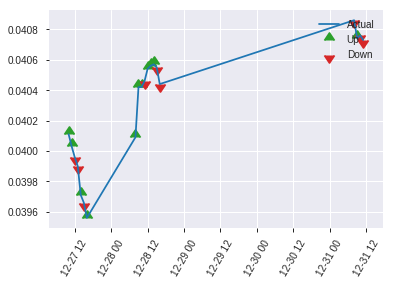


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19367233504240014
RMSE: 0.4400821912352284
LogLoss: 0.5992276760697148
Null degrees of freedom: 222
Residual degrees of freedom: 167
Null deviance: 308.326046881648
Residual deviance: 267.2555435270926
AIC: 379.2555435270926
AUC: 0.7708957708957709
pr_auc: 0.6811246778151852
Gini: 0.5417915417915418
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48654971408841463: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      97   35   0.2652   (35.0/132.0)
1      25   66   0.2747   (25.0/91.0)
Total  122  101  0.2691   (60.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48655      0.6875    100
max f2                       0.301635     0.8       160
max f0point5                 0.530244     0.677201  87
max accuracy                 0.530244     0.735426  87
max precision                0.796956     0.904762  20
max recall                   0.000421083  1         222
max specificity              0.9512       0.992424  0
max absolute_mcc             0.48655      0.454298  100
max min_per_class_accuracy   0.48655      0.725275  100
max mean_per_class_accuracy  0.48655      0.730062  100

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 46.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.931518           0.81685   0.81685            0.333333         0.942075   0.333333                    0.942075            0.010989        0.010989                   -18.315   -18.315
    2        0.0224215                   0.905874           2.45055   1.47033            1                0.916017   0.6                         0.931651            0.021978        0.032967                   145.055   47.033
    3        0.0313901                   0.888521           2.45055   1.75039            1                0.892547   0.714286                    0.920479            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.882934           2.45055   1.90598            1                0.887475   0.777778                    0.913145            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.859805           2.45055   2.04212            1                0.873333   0.833333                    0.903192            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.789659           2.22777   2.13091            0.909091         0.828348   0.869565                    0.867397            0.10989         0.21978                    122.777   113.091
    7        0.152466                    0.730449           1.78222   2.0181             0.727273         0.753732   0.823529                    0.830623            0.0879121       0.307692                   78.2218   101.81
    8        0.201794                    0.679872           1.33666   1.85153            0.545455         0.707549   0.755556                    0.800538            0.0659341       0.373626                   33.6663   85.1526
    9        0.300448                    0.618109           1.33666   1.68247            0.545455         0.652445   0.686567                    0.75191             0.131868        0.505495                   33.6663   68.2467
    10       0.399103                    0.526945           1.55944   1.65206            0.636364         0.565704   0.674157                    0.705882            0.153846        0.659341                   55.9441   65.2056
    11       0.502242                    0.43943            0.852365  1.48783            0.347826         0.485024   0.607143                    0.660527            0.0879121       0.747253                   -14.7635  48.7834
    12       0.600897                    0.375877           0.77972   1.37158            0.318182         0.407535   0.559701                    0.618991            0.0769231       0.824176                   -22.028   37.1576
    13       0.699552                    0.320404           0.668332  1.2724             0.272727         0.354146   0.519231                    0.581641            0.0659341       0.89011                    -33.1668  27.2401
    14       0.798206                    0.229765           0.445554  1.17021            0.181818         0.279733   0.477528                    0.544327            0.043956        0.934066                   -55.4446  17.0206
    15       0.896861                    0.126387           0.222777  1.06599            0.0909091        0.179238   0.435                       0.504167            0.021978        0.956044                   -77.7223  6.5989
    16       1                           0.000421083        0.426183  1                  0.173913         0.0764828  0.408072                    0.

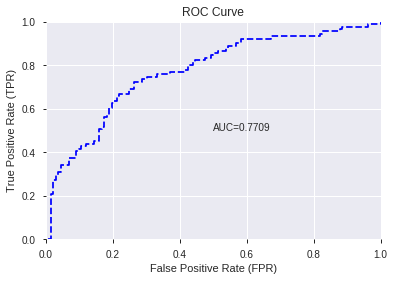

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


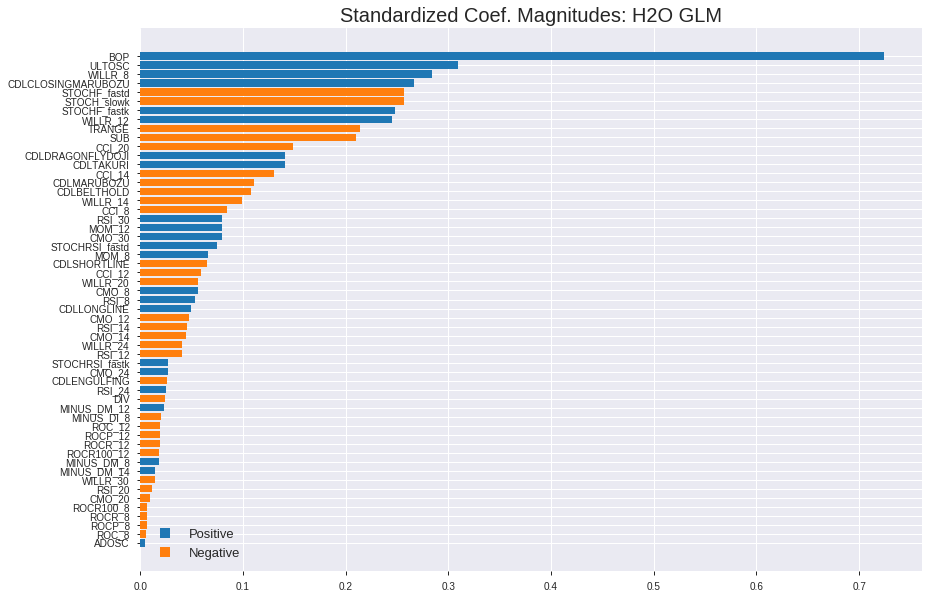

'log_likelihood'
--2019-09-03 03:36:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_033636_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_033636_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'ULTOSC',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastd',
 'STOCH_slowk',
 'STOCHF_fastk',
 'WILLR_12',
 'TRANGE',
 'SUB',
 'CCI_20',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CCI_14',
 'CDLMARUBOZU',
 'CDLBELTHOLD',
 'WILLR_14',
 'CCI_8',
 'RSI_30',
 'MOM_12',
 'CMO_30',
 'STOCHRSI_fastd',
 'MOM_8',
 'CDLSHORTLINE',
 'CCI_12',
 'WILLR_20',
 'CMO_8',
 'RSI_8',
 'CDLLONGLINE',
 'CMO_12',
 'RSI_14',
 'CMO_14',
 'WILLR_24',
 'RSI_12',
 'STOCHRSI_fastk',
 'CMO_24',
 'CDLENGULFING',
 'RSI_24',
 'DIV',
 'MINUS_DM_12',
 'MINUS_DI_8',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'MINUS_DM_8',
 'MINUS_DM_14',
 'WILLR_30',
 'RSI_20',
 'CMO_20',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'ADOSC']

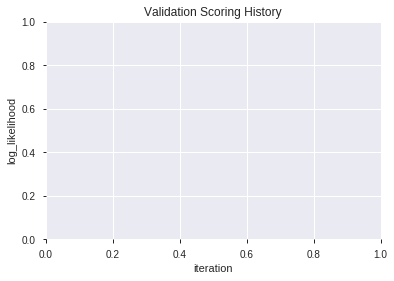

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_033653_model_4  0.746795  0.594090              0.325216  0.453154  0.205349
1  XGBoost_grid_1_AutoML_20190903_033653_model_3  0.740926  0.592394              0.311772  0.452198  0.204483
2  XGBoost_grid_1_AutoML_20190903_033653_model_7  0.737346  0.601741              0.313478  0.455969  0.207908
3  XGBoost_grid_1_AutoML_20190903_033653_model_2  0.733849  0.598753              0.315185  0.455562  0.207537
4               XGBoost_2_AutoML_20190903_033653  0.732268  0.597283              0.345280  0.455248  0.207251
5  XGBoost_grid_1_AutoML_20190903_033653_model_6  0.731102  0.599056              0.332418  0.456326  0.208233
6               XGBoost_3_AutoML_20190903_033653  0.731019  0.598934              0.318973  0.456308  0.208217
7               XGBoost_1_AutoML_20190903_033653  0.728188  0.604989              0.329962  0.457865  0.209641
8  XGBoost_grid_1_AutoML_20190903_033653_model_1  0.728022  0.598680              0.317266  0.455819  0.207771
9  XGBoost_grid_1_AutoML_20190903_033653_model_5  0.715118  0.628882              0.340368  0.468135  0.219150

variable  relative_importance  scaled_importance  percentage
0              BOP          2162.631348           1.000000    0.458229
1           TRANGE           371.041321           0.171569    0.078618
2              DIV           256.960846           0.118819    0.054446
3     STOCHF_fastk           220.552811           0.101984    0.046732
4           ULTOSC           164.007050           0.075837    0.034751
5       MINUS_DI_8           159.033417           0.073537    0.033697
6            CCI_8           131.341843           0.060732    0.027829
7           CCI_20           111.298203           0.051464    0.023582
8            ADOSC           108.238785           0.050050    0.022934
9   STOCHRSI_fastd            76.350502           0.035304    0.016178
10             SUB            73.563965           0.034016    0.015587
11  STOCHRSI_fastk            73.412430           0.033946    0.015555
12         WILLR_8            66.639435           0.030814    0.014120
13          CCI_14            62.049202           0.028692    0.013147
14          CCI_12            56.759865           0.026246    0.012027
15        WILLR_30            54.946629           0.025407    0.011642
16        WILLR_12            53.577202           0.024774    0.011352
17     STOCH_slowk            50.880939           0.023527    0.010781
18           CMO_8            44.920574           0.020771    0.009518
19          MOM_12            42.259613           0.019541    0.008954
20        WILLR_20            42.241501           0.019532    0.008950
21      MINUS_DM_8            41.857643           0.019355    0.008869
22          CMO_30            37.521832           0.017350    0.007950
23           MOM_8            37.278854           0.017238    0.007899
24        WILLR_14            36.527672           0.016890    0.007740
25          ROC_12            32.099785           0.014843    0.006801
26     MINUS_DM_14            31.361828           0.014502    0.006645
27        WILLR_24            28.990005           0.013405    0.006143
28          CMO_24            26.455818           0.012233    0.005606
29     MINUS_DM_12            25.933807           0.011992    0.005495
30          CMO_20            21.533989           0.009957    0.004563
31           ROC_8            12.128161           0.005608    0.002570
32          CMO_14             5.150208           0.002381    0.001091

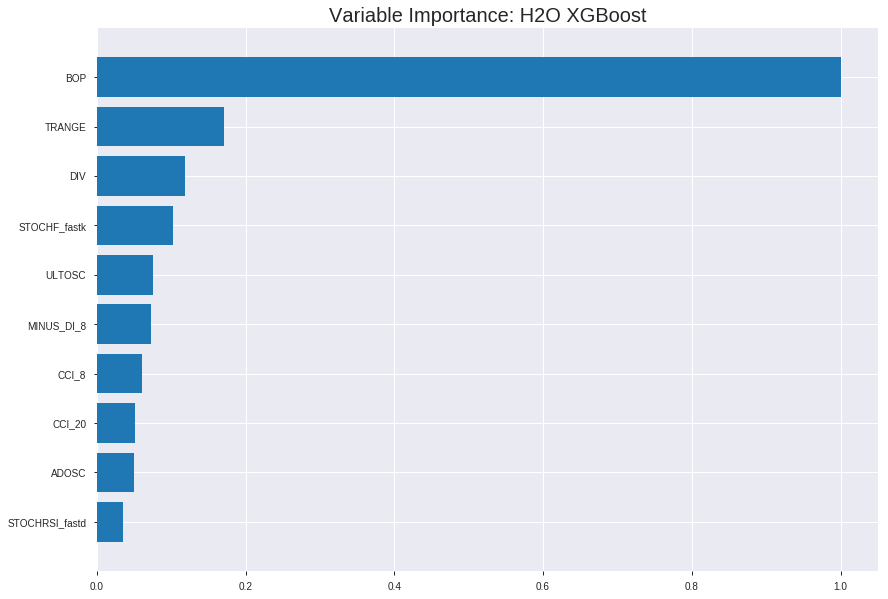

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_033653_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17250573301676939
RMSE: 0.41533809482970546
LogLoss: 0.5214843228432285
Mean Per-Class Error: 0.2402455222114095
AUC: 0.830747317272034
pr_auc: 0.8203338202139137
Gini: 0.661494634544068
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41628531614939374: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      477  311  0.3947   (311.0/788.0)
1      103  669  0.1334   (103.0/772.0)
Total  580  980  0.2654   (414.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416285     0.763699  240
max f2                       0.261932     0.859122  317
max f0point5                 0.550814     0.757616  175
max accuracy                 0.535857     0.759615  183
max precision                0.875558     1         0
max recall                   0.128354     1         379
max specificity              0.875558     1         0
max absolute_mcc             0.531213     0.519605  185
max min_per_class_accuracy   0.540959     0.757614  180
max mean_per_class_accuracy  0.531213     0.759754  185

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.855393           2.02073    2.02073            1                0.864964  1                           0.864964            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.835602           2.02073    2.02073            1                0.845119  1                           0.855041            0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.830078           1.88601    1.97773            0.933333         0.832923  0.978723                    0.847982            0.0181347       0.0595855                  88.601    97.7731
    4        0.0403846                   0.82143            1.76813    1.9245             0.875            0.826541  0.952381                    0.842537            0.0181347       0.0777202                  76.8135   92.45
    5        0.05                        0.810942           1.88601    1.9171             0.933333         0.816193  0.948718                    0.837471            0.0181347       0.0958549                  88.601    91.7098
    6        0.1                         0.77212            1.86528    1.89119            0.923077         0.793601  0.935897                    0.815536            0.0932642       0.189119                   86.5285   89.1192
    7        0.15                        0.738862           1.73575    1.83938            0.858974         0.756287  0.910256                    0.795786            0.0867876       0.275907                   73.5751   83.9378
    8        0.2                         0.709557           1.70984    1.80699            0.846154         0.72356   0.894231                    0.77773             0.0854922       0.361399                   70.9845   80.6995
    9        0.3                         0.656849           1.46373    1.69257            0.724359         0.686444  0.837607                    0.747301            0.146373        0.507772                   46.3731   69.2573
    10       0.4                         0.603575           1.28238    1.59003            0.634615         0.631147  0.786859                    0.718262            0.128238        0.63601                    28.2383   59.0026
    11       0.5                         0.538495           1.25648    1.52332            0.621795         0.57068   0.753846                    0.688746            0.125648        0.761658                   25.6477   52.3316
    12       0.6                         0.439201           0.738342   1.39249            0.365385         0.490411  0.689103                    0.65569             0.0738342       0.835492                   -26.1658  39.2487
    13       0.7                         0.345912           0.738342   1.29904            0.365385         0.39411   0.642857                    0.618322            0.0738342       0.909326                   -26.1658  29.9038
    14       0.8                         0.255604           0.544041   1.20466            0.269231         0.30256   0.596154                    0.578851            0.0544041       0.963731                   -45.5959  20.4663
    15       0.9                         0.162854           0.272021   1.10104            0.134615         0.208258  0.544872                    0.537674            0.0272021       0.990933                   -72.7979  10.1036
    16       1                           0.0845642          0.0906736  1                  0.0448718        0.124166  0.494872                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20493755499072913
RMSE: 0.4527002926779804
LogLoss: 0.5922305649312136
Mean Per-Class Error: 0.31302588996763747
AUC: 0.7389360841423949
pr_auc: 0.6788764879618362
Gini: 0.47787216828478973
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21201668679714203: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      72   168  0.7      (168.0/240.0)
1      5    201  0.0243   (5.0/206.0)
Total  77   369  0.3879   (173.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212017     0.69913   332
max f2                       0.192429     0.845833  339
max f0point5                 0.478348     0.651618  211
max accuracy                 0.478348     0.681614  211
max precision                0.867211     1         0
max recall                   0.121277     1         381
max specificity              0.867211     1         0
max absolute_mcc             0.443918     0.37708   228
max min_per_class_accuracy   0.515476     0.670833  190
max mean_per_class_accuracy  0.46873      0.686974  217

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.842874           1.73204    1.73204            0.8              0.853579  0.8                         0.853579            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.830463           1.62379    1.68393            0.75             0.837468  0.777778                    0.846419            0.0145631       0.0339806                  62.3786   68.3927
    3        0.0313901                   0.816427           1.73204    1.70111            0.8              0.825493  0.785714                    0.838945            0.0194175       0.0533981                  73.2039   70.111
    4        0.0403587                   0.808124           2.16505    1.80421            1                0.811732  0.833333                    0.832898            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.800798           2.16505    1.88265            1                0.805088  0.869565                    0.826852            0.0242718       0.0970874                  116.505   88.2651
    6        0.100897                    0.761669           1.57458    1.73204            0.727273         0.780064  0.8                         0.803978            0.0776699       0.174757                   57.4581   73.2039
    7        0.150224                    0.717674           1.57458    1.68034            0.727273         0.738295  0.776119                    0.78241             0.0776699       0.252427                   57.4581   68.0336
    8        0.201794                    0.678227           1.22372    1.56365            0.565217         0.695675  0.722222                    0.760245            0.0631068       0.315534                   22.3723   56.3646
    9        0.300448                    0.628534           1.18094    1.43798            0.545455         0.650354  0.664179                    0.724161            0.116505        0.432039                   18.0936   43.798
    10       0.401345                    0.576817           1.29903    1.40305            0.6              0.600685  0.648045                    0.69312             0.131068        0.563107                   29.9029   40.3048
    11       0.5                         0.508612           1.23014    1.36893            0.568182         0.537655  0.632287                    0.662445            0.121359        0.684466                   23.0141   36.8932
    12       0.600897                    0.429145           1.05847    1.3168             0.488889         0.470016  0.608209                    0.630134            0.106796        0.791262                   5.84682   31.6802
    13       0.699552                    0.341707           0.738085   1.23519            0.340909         0.38438   0.570513                    0.595477            0.0728155       0.864078                   -26.1915  23.5188
    14       0.800448                    0.249395           0.817907   1.18259            0.377778         0.288932  0.546218                    0.556837            0.0825243       0.946602                   -18.2093  18.259
    15       0.899103                    0.150469           0.442851   1.10142            0.204545         0.188542  0.508728                    0.516425            0.0436893       0.990291                   -55.7149  10.1421
    16       1                           0.0880316          0.0962244  1                  0.0444444        0.122202  0.461883                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:37:00  3.024 sec   0                  0.5              0.693147            0.5             0                  1                0.505128                         0.5                0.693147              0.5               0                    1                  0.538117
    2019-09-03 03:37:00  3.137 sec   5                  0.476213         0.646397            0.799561        0.774681           1.9399           0.287821                         0.483227           0.659889              0.704207          0.643847             2.0104             0.378924
    2019-09-03 03:37:00  3.203 sec   10                 0.460895         0.616557            0.802179        0.781003           1.89443          0.277564                         0.474309           0.641893              0.708354          0.637148             1.92449            0.367713
    2019-09-03 03:37:00  3.261 sec   15                 0.450388         0.595687            0.803187        0.78545            1.74517          0.303846                         0.467311           0.627287              0.717172          0.652842             1.73204            0.374439
    2019-09-03 03:37:01  3.320 sec   20                 0.443167         0.580898            0.805312        0.785492           1.90846          0.303846                         0.462803           0.617404              0.722189          0.658233             1.73204            0.376682
    2019-09-03 03:37:01  3.380 sec   25                 0.438224         0.570501            0.806311        0.790989           1.76813          0.301923                         0.460017           0.611021              0.726173          0.667251             1.73204            0.374439
    2019-09-03 03:37:01  3.438 sec   30                 0.433595         0.560785            0.810439        0.795355           1.89443          0.253846                         0.457275           0.604906              0.732878          0.675955             1.73204            0.376682
    2019-09-03 03:37:01  3.495 sec   35                 0.429714         0.552323            0.813107        0.798952           1.89443          0.287179                         0.455427           0.600378              0.734678          0.673249             1.73204            0.374439
    2019-09-03 03:37:01  3.558 sec   40                 0.426583         0.545526            0.815609        0.801815           2.02073          0.259615                         0.454057           0.59704               0.737116          0.674296             1.73204            0.374439
    2019-09-03 03:37:01  3.620 sec   45                 0.424267         0.540302            0.817036        0.801569           2.02073          0.276282                         0.452694           0.593748              0.740665          0.676382             1.73204            0.374439
    2019-09-03 03:37:01  3.687 sec   50                 0.421669         0.534804            0.821353        0.80844            2.02073          0.274359                         0.453055           0.594077              0.738815          0.673926             1.73204            0.372197
    2019-09-03 03:37:01  3.757 sec   55                 0.419416         0.529878            0.823797        0.810867           2.02073          0.271795                         0.45325            0.593967              0.737722          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2162.63134765625       1.0                    0.45822857807743933
TRANGE        371.04132080078125     0.1715693806079788     0.07861799331762112
DIV           256.9608459472656      0.11881860781577347    0.0544460817085628
STOCHF_fastk  220.5528106689453      0.10198354467948005    0.04673177466577515
ULTOSC        164.00704956054688     0.07583680396489646    0.03475059084677202
---           ---                    ---                    ---
CMO_24        26.45581817626953      0.012233161331422021   0.005605584122289428
MINUS_DM_12   25.933807373046875     0.011991783713462129   0.005494977999631947
CMO_20        21.53398895263672      0.009957309171521149   0.004562723623143581
ROC_8         12.128161430358887     0.005608057722599264   0.0025697723160028637
CMO_14        5.15020751953125       0.0023814542062903063  0.001091250374704944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6610169491525424)

('auc', 0.7467948717948718)

('logloss', 0.5940896832365321)

('mean_per_class_error', 0.3103146853146853)

('rmse', 0.4531541699749677)

('mse', 0.20534870176570194)

xgboost prediction progress: |████████████████████████████████████████████| 100%


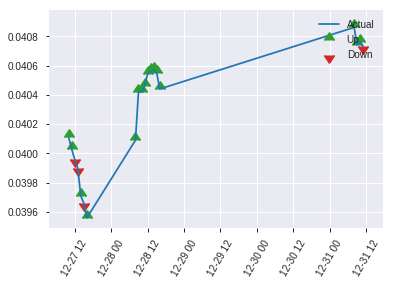


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20534870176570194
RMSE: 0.4531541699749677
LogLoss: 0.5940896832365321
Mean Per-Class Error: 0.3103146853146853
AUC: 0.7467948717948718
pr_auc: 0.6802509321859527
Gini: 0.4935897435897436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3420723080635071: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   67   0.5076   (67.0/132.0)
1      13   78   0.1429   (13.0/91.0)
Total  78   145  0.3587   (80.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342072     0.661017  144
max f2                       0.243062     0.797774  174
max f0point5                 0.647386     0.660377  69
max accuracy                 0.647386     0.717489  69
max precision                0.857585     1         0
max recall                   0.109391     1         218
max specificity              0.857585     1         0
max absolute_mcc             0.647386     0.401769  69
max min_per_class_accuracy   0.552725     0.648352  101
max mean_per_class_accuracy  0.647386     0.689685  69

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 47.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.845783           2.45055   2.45055            1                0.853271  1                           0.853271            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.827265           2.45055   2.45055            1                0.833538  1                           0.845378            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.82005            2.45055   2.45055            1                0.823718  1                           0.839189            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.809102           2.45055   2.45055            1                0.815215  1                           0.833862            0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.783122           1.6337    2.24634            0.666667         0.795394  0.916667                    0.824245            0.021978        0.120879                   63.37     124.634
    6        0.103139                    0.745227           2.005     2.13091            0.818182         0.759066  0.869565                    0.793072            0.0989011       0.21978                    100.5     113.091
    7        0.152466                    0.723001           1.33666   1.87395            0.545455         0.734465  0.764706                    0.774111            0.0659341       0.285714                   33.6663   87.395
    8        0.201794                    0.696905           1.33666   1.74261            0.545455         0.707489  0.711111                    0.757826            0.0659341       0.351648                   33.6663   74.2613
    9        0.300448                    0.650161           1.67083   1.71904            0.681818         0.673413  0.701493                    0.730108            0.164835        0.516484                   67.0829   71.9042
    10       0.399103                    0.590753           0.77972   1.48685            0.318182         0.61833   0.606742                    0.702477            0.0769231       0.593407                   -22.028   48.685
    11       0.502242                    0.510688           0.639274  1.31279            0.26087          0.555809  0.535714                    0.672358            0.0659341       0.659341                   -36.0726  31.2794
    12       0.600897                    0.405526           1.44805   1.335              0.590909         0.453997  0.544776                    0.636508            0.142857        0.802198                   44.8052   33.5001
    13       0.699552                    0.299318           0.891109  1.2724             0.363636         0.343821  0.519231                    0.595231            0.0879121       0.89011                    -10.8891  27.2401
    14       0.798206                    0.229343           0.556943  1.18397            0.227273         0.267731  0.483146                    0.554754            0.0549451       0.945055                   -44.3057  18.3973
    15       0.896861                    0.14397            0.222777  1.07824            0.0909091        0.189074  0.44                        0.514529            0.021978        0.967033                   -77.7223  7.82418
    16       1                           0.109391           0.319637  1                  0.130435         0.123254  0.408072                    0.474173           

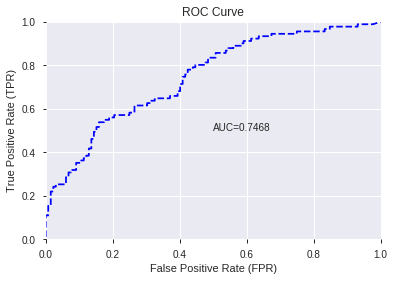

This function is available for GLM models only


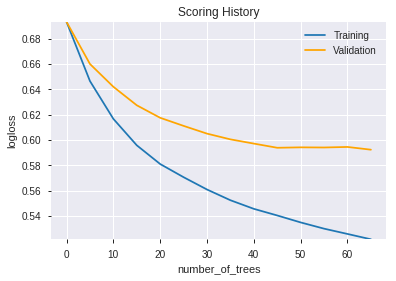

--2019-09-03 03:37:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_033653_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_033653_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'STOCHF_fastk',
 'ULTOSC',
 'MINUS_DI_8',
 'CCI_8',
 'CCI_20',
 'ADOSC',
 'STOCHRSI_fastd',
 'SUB',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CCI_14',
 'CCI_12',
 'WILLR_30',
 'WILLR_12',
 'STOCH_slowk',
 'CMO_8',
 'MOM_12',
 'WILLR_20',
 'MINUS_DM_8',
 'CMO_30',
 'MOM_8',
 'WILLR_14',
 'ROC_12',
 'MINUS_DM_14',
 'WILLR_24',
 'CMO_24',
 'MINUS_DM_12',
 'CMO_20',
 'ROC_8',
 'CMO_14']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

63

['BBANDS_middleband_14_7_5',
 'MA_20_3',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_lowerband_24_2_4',
 'BBANDS_middleband_30_0_2',
 'BOP',
 'aroonup_8',
 'CCI_8',
 'MACDFIX_hist_8',
 'PLUS_DI_8',
 'TRIX_8',
 'WILLR_8',
 'CCI_12',
 'MFI_12',
 'PLUS_DI_12',
 'aroondown_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'MFI_20',
 'MINUS_DI_20',
 'MINUS_DM_20',
 'MOM_20',
 'ROCP_20',
 'aroondown_24',
 'AROONOSC_24',
 'MFI_24',
 'MINUS_DI_24',
 'MINUS_DM_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'CMO_30',
 'PLUS_DI_30',
 'PLUS_DM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR100_30',
 'MACD_hist',
 'MACDEXT',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ADOSC',
 'ATR_8',
 'NATR_8',
 'ATR_12',
 'NATR_20',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'BETA_12',
 'LINEARREG_ANGLE_12',
 'LINEARREG_14',
 'STDDEV_14',
 'VAR_14',
 'LINEARREG_SLOPE_20']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_033822_model_8  0.759907  0.622486              0.274684  0.461306  0.212803
1  DeepLearning_grid_1_AutoML_20190903_033822_model_9  0.734515  0.614560              0.308941  0.459616  0.211247
2  DeepLearning_grid_1_AutoML_20190903_033822_model_7  0.719780  0.693498              0.317266  0.496397  0.246410
3  DeepLearning_grid_1_AutoML_20190903_033822_model_6  0.693057  0.673178              0.352481  0.490291  0.240385
4               DeepLearning_1_AutoML_20190903_033822  0.689227  0.678318              0.358558  0.484805  0.235036
5  DeepLearning_grid_1_AutoML_20190903_033822_model_3  0.684815  1.389969              0.416292  0.623898  0.389248
6  DeepLearning_grid_1_AutoML_20190903_033822_model_5  0.683733  0.683279              0.402473  0.495169  0.245192
7  DeepLearning_grid_1_AutoML_20190903_033822_model_2  0.666583  2.302211              0.400974  0.639789  0.409330
8  DeepLearning_grid_1_AutoML_20190903_033822_model_1  0.639361  2.924701              0.427281  0.678241  0.460010
9  DeepLearning_grid_1_AutoML_20190903_033822_model_4  0.582959  3.380699              0.461747  0.692284  0.479258

variable  relative_importance  scaled_importance  percentage
0                 BOP             1.000000           1.000000    0.042936
1              TRANGE             0.820205           0.820205    0.035217
2        STOCHF_fastd             0.474913           0.474913    0.020391
3         CDLLONGLINE             0.472957           0.472957    0.020307
4             WILLR_8             0.457027           0.457027    0.019623
..                ...                  ...                ...         ...
58         ROCR100_24             0.304053           0.304053    0.013055
59  LINEARREG_ANGLE_8             0.303075           0.303075    0.013013
60             ROC_14             0.301708           0.301708    0.012954
61            ROCP_24             0.295677           0.295677    0.012695
62            ROCR_24             0.293474           0.293474    0.012601

[63 rows x 4 columns]

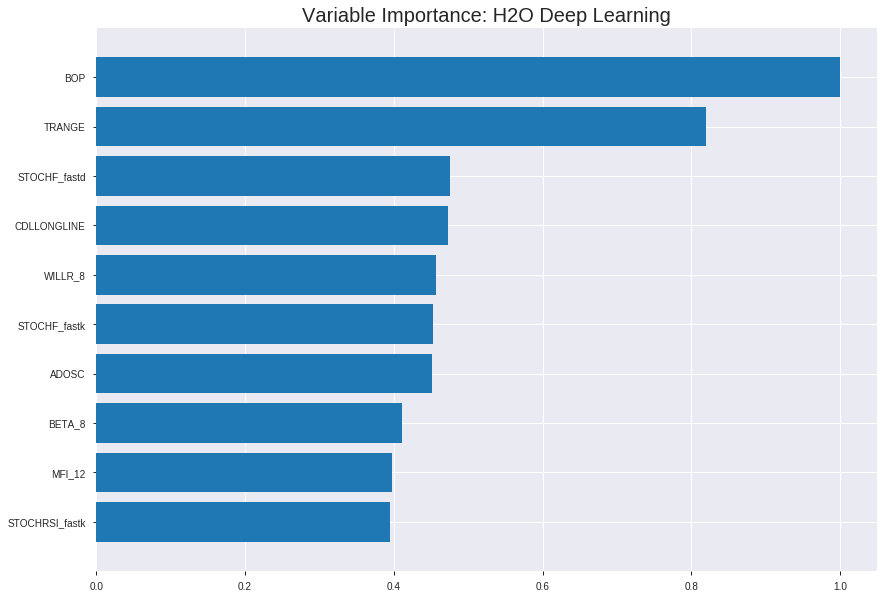

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_033822_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19063818894717352
RMSE: 0.43662133359144684
LogLoss: 0.5605996357211782
Mean Per-Class Error: 0.28688093422056227
AUC: 0.7851129967649456
pr_auc: 0.7661535436228065
Gini: 0.5702259935298912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36772255004515275: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      355  433   0.5495   (433.0/788.0)
1      66   706   0.0855   (66.0/772.0)
Total  421  1139  0.3199   (499.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367723     0.73888   256
max f2                       0.22409      0.849271  316
max f0point5                 0.55884      0.713883  155
max accuracy                 0.547781     0.712821  162
max precision                0.900724     1         0
max recall                   0.0793676    1         374
max specificity              0.900724     1         0
max absolute_mcc             0.520635     0.426835  178
max min_per_class_accuracy   0.534104     0.708122  171
max mean_per_class_accuracy  0.520635     0.713119  178

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 48.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.845006           2.02073   2.02073            1                0.872872   1                           0.872872            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.825266           1.76813   1.89443            0.875            0.833223   0.9375                      0.853047            0.0181347       0.0388601                  76.8135   89.443
    3        0.0301282                   0.81688            2.02073   1.93474            1                0.821474   0.957447                    0.842971            0.0194301       0.0582902                  102.073   93.4737
    4        0.0403846                   0.799006           1.76813   1.89243            0.875            0.807491   0.936508                    0.83396             0.0181347       0.0764249                  76.8135   89.2425
    5        0.05                        0.789563           1.7513    1.86528            0.866667         0.794503   0.923077                    0.826372            0.0168394       0.0932642                  75.1295   86.5285
    6        0.1                         0.724623           1.63212   1.7487             0.807692         0.757453   0.865385                    0.791913            0.0816062       0.17487                    63.2124   74.8705
    7        0.15                        0.685958           1.60622   1.70121            0.794872         0.704302   0.84188                     0.762709            0.0803109       0.255181                   60.6218   70.1209
    8        0.2                         0.661551           1.68394   1.69689            0.833333         0.672222   0.839744                    0.740088            0.0841969       0.339378                   68.3938   69.6891
    9        0.3                         0.620755           1.28238   1.55872            0.634615         0.641835   0.771368                    0.707337            0.128238        0.467617                   28.2383   55.8722
    10       0.4                         0.576011           1.32124   1.49935            0.653846         0.598559   0.741987                    0.680142            0.132124        0.599741                   32.1244   49.9352
    11       0.5                         0.533373           1.12694   1.42487            0.557692         0.555318   0.705128                    0.655177            0.112694        0.712435                   12.6943   42.487
    12       0.6                         0.479983           0.958549  1.34715            0.474359         0.507843   0.666667                    0.630622            0.0958549       0.80829                    -4.14508  34.715
    13       0.7                         0.398083           0.816062  1.27128            0.403846         0.445775   0.629121                    0.604215            0.0816062       0.889896                   -18.3938  27.1281
    14       0.8                         0.270134           0.544041  1.18038            0.269231         0.335378   0.584135                    0.57061             0.0544041       0.944301                   -45.5959  18.0376
    15       0.9                         0.139183           0.414508  1.09528            0.205128         0.205845   0.542023                    0.530081            0.0414508       0.985751                   -58.5492  9.52792
    16       1                           0.00624573         0.142487  1                  0.0705128        0.0829543  0.494872                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20394427818901106
RMSE: 0.45160190233103653
LogLoss: 0.5916242008679651
Mean Per-Class Error: 0.3154733009708738
AUC: 0.7470974919093851
pr_auc: 0.6940254290028536
Gini: 0.49419498381877025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4279796390216973: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  119  0.4958   (119.0/240.0)
1      32   174  0.1553   (32.0/206.0)
Total  153  293  0.3386   (151.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42798      0.697395  256
max f2                       0.203744     0.833333  342
max f0point5                 0.57453      0.656325  137
max accuracy                 0.525514     0.681614  177
max precision                0.826433     0.9       9
max recall                   0.047964     1         394
max specificity              0.885127     0.995833  0
max absolute_mcc             0.451756     0.375222  239
max min_per_class_accuracy   0.515718     0.675     188
max mean_per_class_accuracy  0.474351     0.684527  225

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.851086           1.73204   1.73204            0.8              0.866286   0.8                         0.866286            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.826998           2.16505   1.92449            1                0.840075   0.888889                    0.854637            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.793538           1.29903   1.70111            0.6              0.807663   0.785714                    0.837861            0.0145631       0.0533981                  29.9029   70.111
    4        0.0403587                   0.783505           2.16505   1.80421            1                0.790282   0.833333                    0.827288            0.0194175       0.0728155                  116.505   80.4207
    5        0.0515695                   0.768667           1.73204   1.78852            0.8              0.775331   0.826087                    0.815993            0.0194175       0.092233                   73.2039   78.8518
    6        0.100897                    0.684853           1.86981   1.82826            0.863636         0.733619   0.844444                    0.775721            0.092233        0.184466                   86.9815   82.8263
    7        0.150224                    0.652715           1.37776   1.68034            0.636364         0.665751   0.776119                    0.739612            0.0679612       0.252427                   37.7758   68.0336
    8        0.201794                    0.63405            1.50612   1.63581            0.695652         0.64257    0.755556                    0.714812            0.0776699       0.330097                   50.6121   63.5814
    9        0.300448                    0.591683           1.42696   1.56724            0.659091         0.612383   0.723881                    0.681179            0.140777        0.470874                   42.6964   56.7237
    10       0.401345                    0.546235           1.10658   1.45143            0.511111         0.572391   0.670391                    0.65383             0.11165         0.582524                   10.658    45.1429
    11       0.5                         0.509262           1.13173   1.38835            0.522727         0.527377   0.641256                    0.62888             0.11165         0.694175                   13.173    38.835
    12       0.600897                    0.465702           0.962244  1.3168             0.444444         0.486606   0.608209                    0.60499             0.0970874       0.791262                   -3.77562  31.6802
    13       0.699552                    0.405635           0.688879  1.22825            0.318182         0.433511   0.567308                    0.580807            0.0679612       0.859223                   -31.1121  22.8249
    14       0.800448                    0.277216           0.769795  1.17046            0.355556         0.333883   0.540616                    0.549682            0.0776699       0.936893                   -23.0205  17.046
    15       0.899103                    0.153477           0.442851  1.09062            0.204545         0.217329   0.503741                    0.513215            0.0436893       0.980583                   -55.7149  9.0623
    16       1                           0.0137153          0.192449  1                  0.0888889        0.0939796  0.461883                    0.4


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:43:18  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:43:19  1 min  5.056 sec  663 obs/sec       0.596795  1             931        0.473147         0.646331            0.104433       0.706365        0.672599           1.51554          0.375641                         0.492005           0.688287              0.026064         0.669579          0.605906             2.16505            0.378924
    2019-09-03 03:43:28  1 min 13.881 sec  1013 obs/sec      6.09551   10            9509       0.452073         0.595084            0.182433       0.768227        0.740819           1.89443          0.304487                         0.462537           0.616175              0.139236         0.735669          0.697455             2.16505            0.383408
    2019-09-03 03:43:37  1 min 22.441 sec  1165 obs/sec      12.7769   21            19932      0.436621         0.5606              0.237367       0.785113        0.766154           2.02073          0.319872                         0.451602           0.591624              0.179454         0.747097          0.694025             1.73204            0.338565
    2019-09-03 03:43:45  1 min 30.958 sec  1263 obs/sec      20.0365   33            31257      0.443252         0.57682             0.214028       0.795454        0.77421            2.02073          0.301923                         0.476537           0.658961              0.0863417        0.737247          0.688398             2.16505            0.403587
    2019-09-03 03:43:54  1 min 39.791 sec  1331 obs/sec      27.934    46            43577      0.438086         0.562249            0.232241       0.810135        0.790132           2.02073          0.285256                         0.456456           0.59952               0.161719         0.740665          0.69654              2.16505            0.325112
    2019-09-03 03:44:03  1 min 48.869 sec  1385 obs/sec      36.3699   60            56737      0.427342         0.542729            0.269438       0.825291        0.809767           2.02073          0.277564                         0.452721           0.594895              0.175383         0.753378          0.716582             2.16505            0.327354
    2019-09-03 03:44:04  1 min 49.753 sec  1384 obs/sec      36.3699   60            56737      0.436621         0.5606              0.237367       0.785113        0.766154           2.02073          0.319872                         0.451602           0.591624              0.179454         0.747097          0.694025             1.73204            0.338565

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.0429363029387553
TRANGE             0.8202052116394043     0.8202052116394043   0.03521657943889536
STOCHF_fastd       0.47491273283958435    0.47491273283958435  0.020390996966672553
CDLLONGLINE        0.4729567766189575     0.4729567766189575   0.020307015437848776
WILLR_8            0.4570268988609314     0.4570268988609314   0.019623045380652827
---                ---                    ---                  ---
ROCR100_24         0.3040526509284973     0.3040526509284973   0.013054896729597577
LINEARREG_ANGLE_8  0.3030751943588257     0.3030751943588257   0.01301292835821268
ROC_14             0.3017076551914215     0.3017076551914215   0.012954211282240401
ROCP_24            0.2956768572330475     0.2956768572330475   0.012695271114137227
ROCR_24            0.2934736907482147     0.2934736907482147   0.012600675290519935


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.6740331491712707)

('auc', 0.7599067599067599)

('logloss', 0.6224857329105009)

('mean_per_class_error', 0.2746836496836498)

('rmse', 0.46130585450029793)

('mse', 0.21280309139625006)

deeplearning prediction progress: |███████████████████████████████████████| 100%


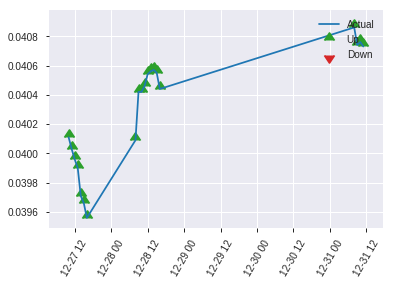


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21280309139625006
RMSE: 0.46130585450029793
LogLoss: 0.6224857329105009
Mean Per-Class Error: 0.2746836496836498
AUC: 0.7599067599067599
pr_auc: 0.6903724058973101
Gini: 0.5198135198135199
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5187837855817795: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      103  29   0.2197   (29.0/132.0)
1      30   61   0.3297   (30.0/91.0)
Total  133  90   0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518784     0.674033  89
max f2                       0.347443     0.793796  183
max f0point5                 0.541055     0.706052  63
max accuracy                 0.541055     0.744395  63
max precision                0.819958     1         0
max recall                   0.00864992   1         222
max specificity              0.819958     1         0
max absolute_mcc             0.541055     0.461561  63
max min_per_class_accuracy   0.514551     0.704545  103
max mean_per_class_accuracy  0.518784     0.725316  89

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 46.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.746369           2.45055   2.45055            1                0.782355  1                           0.782355            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.712311           2.45055   2.45055            1                0.727391  1                           0.76037             0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.666316           2.45055   2.45055            1                0.693551  1                           0.741279            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.653739           2.45055   2.45055            1                0.658417  1                           0.722865            0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.63369            2.45055   2.45055            1                0.642254  1                           0.702712            0.032967        0.131868                   145.055   145.055
    6        0.103139                    0.605438           1.11389   1.81128            0.454545         0.618084  0.73913                     0.662238            0.0549451       0.186813                   11.3886   81.1276
    7        0.152466                    0.581608           1.78222   1.80187            0.727273         0.590392  0.735294                    0.638994            0.0879121       0.274725                   78.2218   80.1875
    8        0.201794                    0.56443            2.22777   1.90598            0.909091         0.572374  0.777778                    0.622709            0.10989         0.384615                   122.777   90.5983
    9        0.300448                    0.536765           1.55944   1.79219            0.636364         0.549009  0.731343                    0.598509            0.153846        0.538462                   55.9441   79.2193
    10       0.399103                    0.518877           1.22527   1.65206            0.5              0.52498   0.674157                    0.580333            0.120879        0.659341                   22.5275   65.2056
    11       0.502242                    0.512528           0.852365  1.48783            0.347826         0.515846  0.607143                    0.56709             0.0879121       0.747253                   -14.7635  48.7834
    12       0.600897                    0.499544           0.334166  1.29843            0.136364         0.508191  0.529851                    0.55742             0.032967        0.78022                    -66.5834  29.8425
    13       0.699552                    0.451151           0.77972   1.22527            0.318182         0.480522  0.5                         0.546576            0.0769231       0.857143                   -22.028   22.5275
    14       0.798206                    0.365115           0.668332  1.15644            0.272727         0.404123  0.47191                     0.528969            0.0659341       0.923077                   -33.1668  15.6439
    15       0.896861                    0.232034           0.445554  1.07824            0.181818         0.312667  0.44                        0.505176            0.043956        0.967033                   -55.4446  7.82418
    16       1                           0.00864992         0.319637  1                  0.130435         0.130914  0.408072                    0.466575         

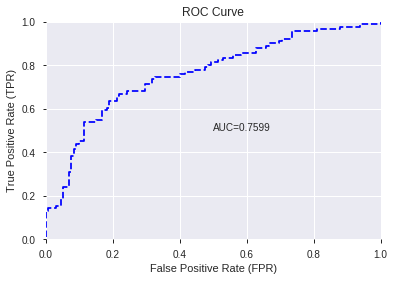

This function is available for GLM models only


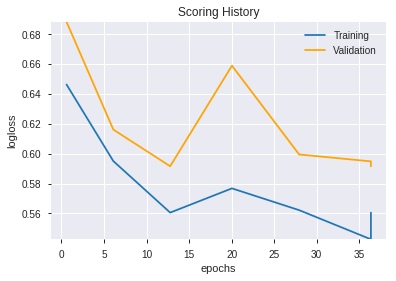

--2019-09-03 03:45:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_033822_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_033822_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'STOCHF_fastd',
 'CDLLONGLINE',
 'WILLR_8',
 'STOCHF_fastk',
 'ADOSC',
 'BETA_8',
 'MFI_12',
 'STOCHRSI_fastk',
 'aroonup_8',
 'HT_PHASOR_quadrature',
 'HT_PHASOR_inphase',
 'aroondown_24',
 'BETA_12',
 'PLUS_DM_30',
 'PLUS_DI_12',
 'CDLSPINNINGTOP',
 'MFI_20',
 'PLUS_DI_8',
 'ROCP_30',
 'STDDEV_14',
 'PLUS_DM_14',
 'MINUS_DI_24',
 'aroondown_14',
 'BBANDS_middleband_14_7_5',
 'BBANDS_middleband_30_0_2',
 'ATR_8',
 'MFI_24',
 'CCI_12',
 'AROONOSC_24',
 'CCI_8',
 'NATR_20',
 'ROC_30',
 'BBANDS_lowerband_24_2_4',
 'LINEARREG_ANGLE_12',
 'MINUS_DM_24',
 'CMO_30',
 'ROCR100_30',
 'CDLBELTHOLD',
 'MACD_hist',
 'MA_20_3',
 'ATR_12',
 'PLUS_DI_30',
 'VAR_14',
 'BBANDS_lowerband_20_3_5',
 'ROCR100_14',
 'LINEARREG_14',
 'MACDEXT',
 'NATR_8',
 'MACDFIX_hist_8',
 'LINEARREG_SLOPE_20',
 'ROCR_14',
 'MINUS_DM_20',
 'MOM_20',
 'TRIX_8',
 'MINUS_DI_20',
 'ROCP_20',
 'ROCR100_24',
 'LINEARREG_ANGLE_8',
 'ROC_14',
 'ROCP_24',
 'ROCR_24']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_034540_model_1  0.739427  0.641099              0.312354  0.466054  0.217207

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.738283           1.000000    0.097501
1                WILLR_8             0.544324           0.737284    0.071886
2           STOCHF_fastd             0.486059           0.658364    0.064191
3                 TRANGE             0.460678           0.623985    0.060839
4           STOCHF_fastk             0.311057           0.421325    0.041079
..                   ...                  ...                ...         ...
58               BETA_12             0.010330           0.013992    0.001364
59  HT_PHASOR_quadrature             0.007367           0.009978    0.000973
60        CDLSPINNINGTOP             0.006539           0.008856    0.000864
61                VAR_14             0.003488           0.004725    0.000461
62                ATR_12             0.003107           0.004208    0.000410

[63 rows x 4 columns]

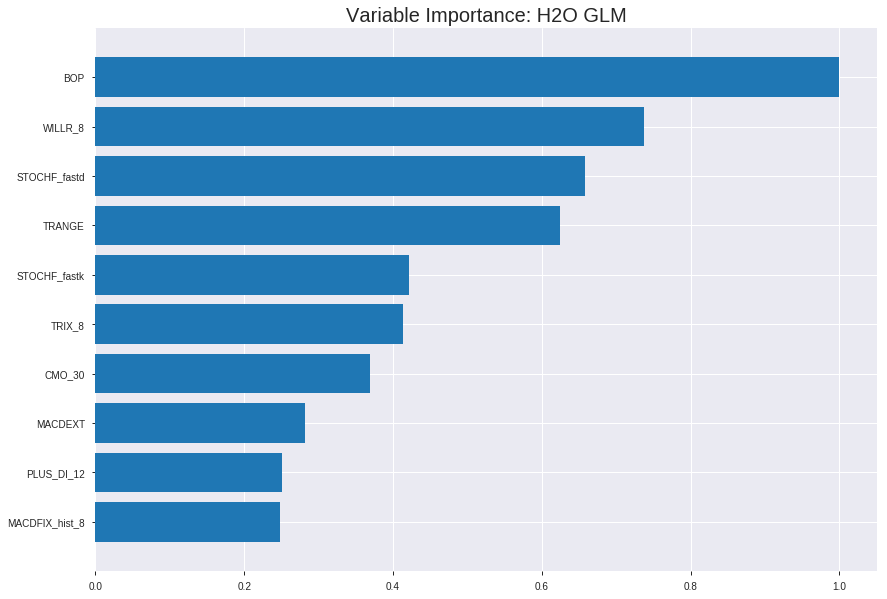

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_034540_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1920070094569569
RMSE: 0.43818604434299013
LogLoss: 0.5653988836740874
Null degrees of freedom: 1559
Residual degrees of freedom: 1496
Null deviance: 2162.4550979057067
Residual deviance: 1764.0445170631529
AIC: 1892.0445170631529
AUC: 0.7772431682491254
pr_auc: 0.7529083948308191
Gini: 0.5544863364982509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.377969644398295: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      418  370   0.4695   (370.0/788.0)
1      105  667   0.136    (105.0/772.0)
Total  523  1037  0.3045   (475.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37797      0.737424  249
max f2                       0.239438     0.84499   310
max f0point5                 0.564472     0.714696  167
max accuracy                 0.537964     0.712179  179
max precision                0.927545     1         0
max recall                   0.0514795    1         388
max specificity              0.927545     1         0
max absolute_mcc             0.537964     0.424576  179
max min_per_class_accuracy   0.517666     0.705584  189
max mean_per_class_accuracy  0.537964     0.71188   179

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.896871           1.89443   1.89443            0.9375           0.911511  0.9375                      0.911511            0.0194301       0.0194301                  89.443    89.443
    2        0.0205128                   0.87422            1.64184   1.76813            0.8125           0.882937  0.875                       0.897224            0.0168394       0.0362694                  64.1839   76.8135
    3        0.0301282                   0.862466           1.88601   1.80575            0.933333         0.867887  0.893617                    0.887861            0.0181347       0.0544041                  88.601    80.5755
    4        0.0403846                   0.850449           1.89443   1.82828            0.9375           0.857037  0.904762                    0.880032            0.0194301       0.0738342                  89.443    82.8275
    5        0.05                        0.839344           1.61658   1.78756            0.8              0.84654   0.884615                    0.873591            0.015544        0.0893782                  61.658    78.7565
    6        0.1                         0.796226           1.63212   1.70984            0.807692         0.817101  0.846154                    0.845346            0.0816062       0.170984                   63.2124   70.9845
    7        0.15                        0.76066            1.5544    1.65803            0.769231         0.776866  0.820513                    0.822519            0.0777202       0.248705                   55.4404   65.8031
    8        0.2                         0.731465           1.47668   1.61269            0.730769         0.745102  0.798077                    0.803165            0.0738342       0.322539                   47.6684   61.2694
    9        0.3                         0.660088           1.47668   1.56736            0.730769         0.694199  0.775641                    0.766843            0.147668        0.470207                   47.6684   56.7358
    10       0.4                         0.590717           1.28238   1.49611            0.634615         0.625965  0.740385                    0.731623            0.128238        0.598446                   28.2383   49.6114
    11       0.5                         0.513669           1.10104   1.4171             0.544872         0.551809  0.701282                    0.695661            0.110104        0.708549                   10.1036   41.7098
    12       0.6                         0.429095           0.854922  1.3234             0.423077         0.473064  0.654915                    0.658561            0.0854922       0.794041                   -14.5078  32.3402
    13       0.7                         0.340281           0.906736  1.26388            0.448718         0.388071  0.625458                    0.61992             0.0906736       0.884715                   -9.32642  26.3879
    14       0.8                         0.254204           0.608808  1.18199            0.301282         0.297148  0.584936                    0.579573            0.0608808       0.945596                   -39.1192  18.1995
    15       0.9                         0.164881           0.336788  1.08808            0.166667         0.207118  0.538462                    0.538189            0.0336788       0.979275                   -66.3212  8.80829
    16       1                           0.00178395         0.207254  1                  0.102564         0.105014  0.494872                    0.494872          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19800048281342597
RMSE: 0.44497245174665134
LogLoss: 0.5787810664129395
Null degrees of freedom: 445
Residual degrees of freedom: 382
Null deviance: 617.6367436752857
Residual deviance: 516.272711240342
AIC: 644.272711240342
AUC: 0.7599413430420712
pr_auc: 0.7057530137646686
Gini: 0.5198826860841423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4159704204480099: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  91   0.3792   (91.0/240.0)
1      41   165  0.199    (41.0/206.0)
Total  190  256  0.296    (132.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41597      0.714286  233
max f2                       0.149799     0.829268  363
max f0point5                 0.50622      0.675542  188
max accuracy                 0.431899     0.706278  226
max precision                0.862447     0.888889  8
max recall                   0.112904     1         378
max specificity              0.906901     0.995833  0
max absolute_mcc             0.41597      0.425259  233
max min_per_class_accuracy   0.488717     0.694175  199
max mean_per_class_accuracy  0.431899     0.71161   226

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 46.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.880348           1.73204   1.73204            0.8              0.894847  0.8                         0.894847            0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.859082           2.16505   1.92449            1                0.868132  0.888889                    0.882973            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.836792           1.73204   1.85576            0.8              0.848708  0.857143                    0.870736            0.0194175       0.0582524                  73.2039   85.5756
    4        0.0403587                   0.824835           1.08252   1.68393            0.5              0.831476  0.777778                    0.862011            0.00970874      0.0679612                  8.25243   68.3927
    5        0.0515695                   0.809327           2.16505   1.78852            1                0.81766   0.826087                    0.85237             0.0242718       0.092233                   116.505   78.8518
    6        0.100897                    0.76244            1.86981   1.82826            0.863636         0.781909  0.844444                    0.817922            0.092233        0.184466                   86.9815   82.8263
    7        0.150224                    0.714362           1.67299   1.77728            0.772727         0.739272  0.820896                    0.792097            0.0825243       0.26699                    67.2992   77.7279
    8        0.201794                    0.67374            1.41199   1.68393            0.652174         0.690637  0.777778                    0.766168            0.0728155       0.339806                   41.1988   68.3927
    9        0.300448                    0.600954           1.23014   1.53492            0.568182         0.637096  0.708955                    0.723786            0.121359        0.461165                   23.0141   53.4922
    10       0.401345                    0.541339           1.34714   1.48771            0.622222         0.574361  0.687151                    0.686221            0.135922        0.597087                   34.7141   48.7715
    11       0.5                         0.474126           1.08252   1.40777            0.5              0.507449  0.650224                    0.650948            0.106796        0.703883                   8.25243   40.7767
    12       0.600897                    0.399769           1.10658   1.35719            0.511111         0.434516  0.626866                    0.614606            0.11165         0.815534                   10.658    35.7195
    13       0.699552                    0.316295           0.738085  1.26988            0.340909         0.358275  0.586538                    0.578457            0.0728155       0.88835                    -26.1915  26.9884
    14       0.800448                    0.24284            0.336785  1.15227            0.155556         0.271981  0.532213                    0.539826            0.0339806       0.92233                    -66.3215  15.2267
    15       0.899103                    0.163701           0.590468  1.09062            0.272727         0.206871  0.503741                    0.503292            0.0582524       0.980583                   -40.9532  9.0623
    16       1                           0.0102549          0.192449  1                  0.0888889        0.103661  0.461883                    0.462971          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 03:45:40  0.000 sec   2            .21E2     64            1.3706220947272996  1.3736907274352113
     2019-09-03 03:45:40  0.016 sec   4            .13E2     64            1.3629418165203118  1.3680171118053177
     2019-09-03 03:45:40  0.032 sec   6            .79E1     64            1.3523301888041912  1.3599079053823835
     2019-09-03 03:45:40  0.046 sec   8            .49E1     64            1.3383436998681697  1.3487041694650344
     2019-09-03 03:45:41  0.061 sec   10           .31E1     64            1.3207560576134592  1.3338724667378903
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 03:45:41  0.314 sec   40           .24E-2    64            1.1295360381507826  1.1577357113108273
     2019-09-03 03:45:41  0.328 sec   42           .15E-2    64            1.1285687937028803  1.157974766770037
     2019-09-03 03:45:41  0.344 sec   44           .93E-3    64            1.1277809658994313  1.1582345686024094
     2019-09-03 03:45:41  0.358 sec   46           .58E-3    64            1.127122707140463   1.1585991099999626
     2019-09-03 03:45:41  0.378 sec   48           .36E-3    64            1.1265588439672185  1.1590794849028343


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6995515695067265)

('F1', 0.6572769953051644)

('auc', 0.7394272394272394)

('logloss', 0.6410993060467489)

('mean_per_class_error', 0.30914918414918413)

('rmse', 0.4660542218715096)

('mse', 0.21720653772425827)

glm prediction progress: |████████████████████████████████████████████████| 100%


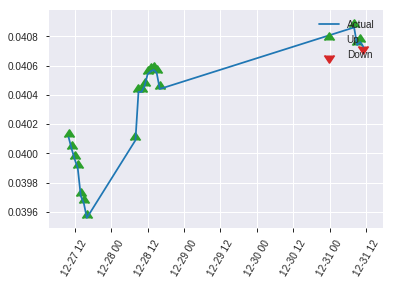


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21720653772425827
RMSE: 0.4660542218715096
LogLoss: 0.6410993060467489
Null degrees of freedom: 222
Residual degrees of freedom: 159
Null deviance: 308.326046881648
Residual deviance: 285.93029049685015
AIC: 413.93029049685015
AUC: 0.7394272394272394
pr_auc: 0.651561268215832
Gini: 0.47885447885447885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5112905730415946: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   52   0.3939   (52.0/132.0)
1      21   70   0.2308   (21.0/91.0)
Total  101  122  0.3274   (73.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511291     0.657277  121
max f2                       0.340443     0.79096   166
max f0point5                 0.724097     0.634675  57
max accuracy                 0.724097     0.699552  57
max precision                0.939104     1         0
max recall                   0.000831292  1         222
max specificity              0.939104     1         0
max absolute_mcc             0.573767     0.376046  103
max min_per_class_accuracy   0.573767     0.689394  103
max mean_per_class_accuracy  0.573767     0.690851  103

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.927118           2.45055   2.45055            1                0.932295   1                           0.932295            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.913501           2.45055   2.45055            1                0.920444   1                           0.927554            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.883079           1.22527   2.10047            0.5              0.902086   0.857143                    0.920278            0.010989        0.0659341                  22.5275   110.047
    4        0.0403587                   0.874245           1.22527   1.90598            0.5              0.876084   0.777778                    0.910457            0.010989        0.0769231                  22.5275   90.5983
    5        0.0538117                   0.867683           2.45055   2.04212            1                0.870358   0.833333                    0.900432            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.823152           1.55944   1.81128            0.636364         0.845051   0.73913                     0.873946            0.0769231       0.186813                   55.9441   81.1276
    7        0.152466                    0.800958           2.005     1.87395            0.818182         0.809735   0.764706                    0.853172            0.0989011       0.285714                   100.5     87.395
    8        0.201794                    0.765452           1.33666   1.74261            0.545455         0.778329   0.711111                    0.834877            0.0659341       0.351648                   33.6663   74.2613
    9        0.300448                    0.699018           1.33666   1.60932            0.545455         0.729289   0.656716                    0.800206            0.131868        0.483516                   33.6663   60.9316
    10       0.399103                    0.63231            1.22527   1.51438            0.5              0.657334   0.617978                    0.764889            0.120879        0.604396                   22.5275   51.4384
    11       0.502242                    0.554881           1.06546   1.42219            0.434783         0.590019   0.580357                    0.728979            0.10989         0.714286                   6.54563   42.2194
    12       0.600897                    0.468031           0.668332  1.29843            0.272727         0.508014   0.529851                    0.692701            0.0659341       0.78022                    -33.1668  29.8425
    13       0.699552                    0.39618            0.891109  1.24098            0.363636         0.434226   0.50641                     0.656249            0.0879121       0.868132                   -10.8891  24.0983
    14       0.798206                    0.270173           0.668332  1.17021            0.272727         0.338315   0.477528                    0.616954            0.0659341       0.934066                   -33.1668  17.0206
    15       0.896861                    0.180309           0.445554  1.09049            0.181818         0.220922   0.445                       0.57339             0.043956        0.978022                   -55.4446  9.04945
    16       1                           0.000831292        0.213091  1                  0.0869565        0.0988987  0.408072                    

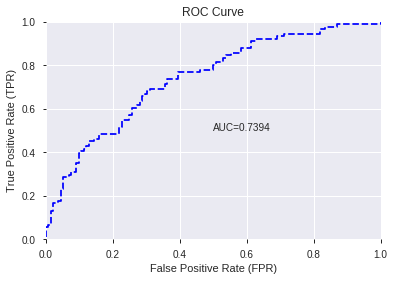

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


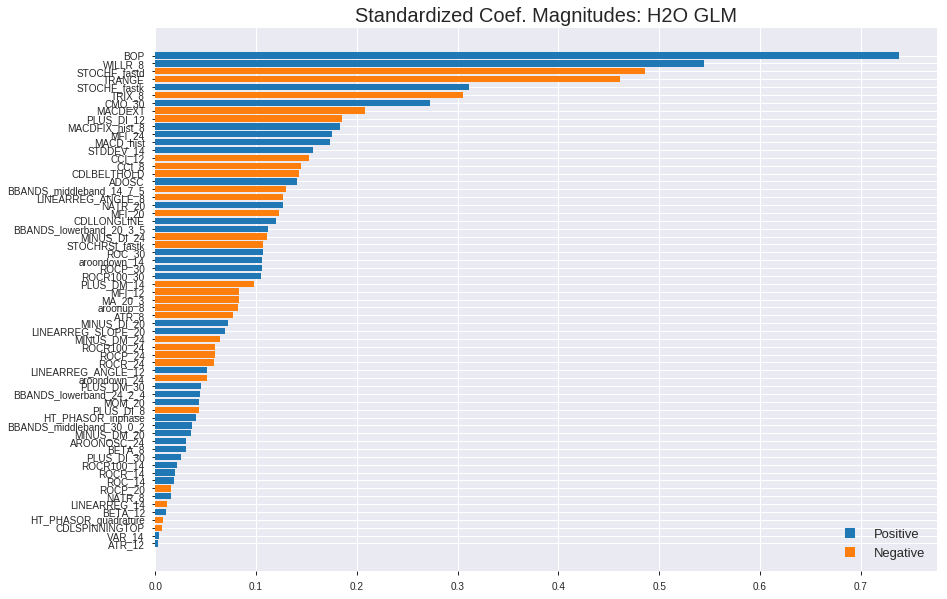

'log_likelihood'
--2019-09-03 03:45:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_034540_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_034540_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'WILLR_8',
 'STOCHF_fastd',
 'TRANGE',
 'STOCHF_fastk',
 'TRIX_8',
 'CMO_30',
 'MACDEXT',
 'PLUS_DI_12',
 'MACDFIX_hist_8',
 'MFI_24',
 'MACD_hist',
 'STDDEV_14',
 'CCI_12',
 'CCI_8',
 'CDLBELTHOLD',
 'ADOSC',
 'BBANDS_middleband_14_7_5',
 'LINEARREG_ANGLE_8',
 'NATR_20',
 'MFI_20',
 'CDLLONGLINE',
 'BBANDS_lowerband_20_3_5',
 'MINUS_DI_24',
 'STOCHRSI_fastk',
 'ROC_30',
 'aroondown_14',
 'ROCP_30',
 'ROCR100_30',
 'PLUS_DM_14',
 'MFI_12',
 'MA_20_3',
 'aroonup_8',
 'ATR_8',
 'MINUS_DI_20',
 'LINEARREG_SLOPE_20',
 'MINUS_DM_24',
 'ROCR100_24',
 'ROCP_24',
 'ROCR_24',
 'LINEARREG_ANGLE_12',
 'aroondown_24',
 'PLUS_DM_30',
 'BBANDS_lowerband_24_2_4',
 'MOM_20',
 'PLUS_DI_8',
 'HT_PHASOR_inphase',
 'BBANDS_middleband_30_0_2',
 'MINUS_DM_20',
 'AROONOSC_24',
 'BETA_8',
 'PLUS_DI_30',
 'ROCR100_14',
 'ROCR_14',
 'ROC_14',
 'ROCP_20',
 'NATR_8',
 'LINEARREG_14',
 'BETA_12',
 'HT_PHASOR_quadrature',
 'CDLSPINNINGTOP',
 'VAR_14',
 'ATR_12']

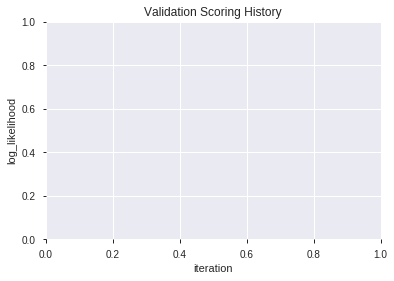

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_034557_model_3  0.752331  0.604308              0.286047  0.458251  0.209994
1  XGBoost_grid_1_AutoML_20190903_034557_model_7  0.751082  0.608348              0.294372  0.460457  0.212020
2  XGBoost_grid_1_AutoML_20190903_034557_model_4  0.750416  0.604761              0.328630  0.458316  0.210053
3  XGBoost_grid_1_AutoML_20190903_034557_model_1  0.748252  0.595553              0.332418  0.455620  0.207589
4               XGBoost_3_AutoML_20190903_034557  0.745588  0.597357              0.295704  0.454565  0.206629
5               XGBoost_2_AutoML_20190903_034557  0.742924  0.607578              0.303655  0.459402  0.211050
6  XGBoost_grid_1_AutoML_20190903_034557_model_6  0.735015  0.601835              0.333541  0.456882  0.208741
7               XGBoost_1_AutoML_20190903_034557  0.730353  0.617317              0.315768  0.464203  0.215485
8  XGBoost_grid_1_AutoML_20190903_034557_model_2  0.729104  0.613861              0.324634  0.461459  0.212945
9  XGBoost_grid_1_AutoML_20190903_034557_model_5  0.693556  0.662208              0.351149  0.481958  0.232284

variable  relative_importance  scaled_importance  percentage
0              BOP          1570.098877           1.000000    0.209513
1     STOCHF_fastk           598.221375           0.381009    0.079826
2           TRANGE           520.435852           0.331467    0.069447
3          WILLR_8           265.334595           0.168992    0.035406
4            ADOSC           252.526276           0.160835    0.033697
..             ...                  ...                ...         ...
57         ROCP_24            17.763754           0.011314    0.002370
58         ROCR_24            16.382244           0.010434    0.002186
59     CDLBELTHOLD            15.451349           0.009841    0.002062
60      ROCR100_24            13.050779           0.008312    0.001741
61  CDLSPINNINGTOP             7.087727           0.004514    0.000946

[62 rows x 4 columns]

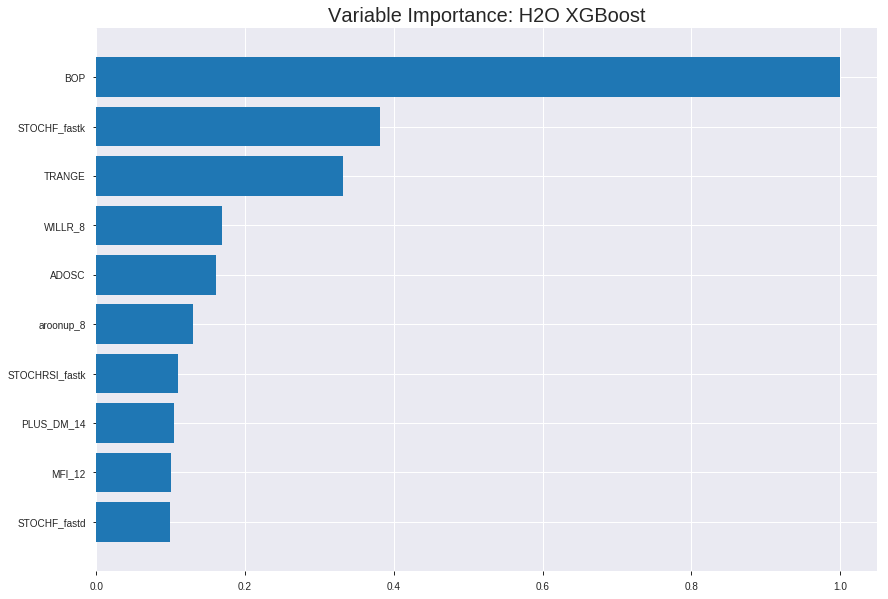

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_034557_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1308098896362409
RMSE: 0.36167649859541734
LogLoss: 0.424990450912204
Mean Per-Class Error: 0.15269850871886592
AUC: 0.9290046947739408
pr_auc: 0.9299418201971462
Gini: 0.8580093895478815
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47510751336812973: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      608  180  0.2284   (180.0/788.0)
1      76   696  0.0984   (76.0/772.0)
Total  684  876  0.1641   (256.0/1560.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475108     0.84466   211
max f2                       0.305729     0.903157  281
max f0point5                 0.607715     0.861682  146
max accuracy                 0.534813     0.847436  181
max precision                0.936539     1         0
max recall                   0.190757     1         331
max specificity              0.936539     1         0
max absolute_mcc             0.534813     0.694953  181
max min_per_class_accuracy   0.528563     0.841969  184
max mean_per_class_accuracy  0.534813     0.847301  181

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102564                   0.901728           2.02073    2.02073            1                0.914875  1                           0.914875            0.0207254       0.0207254                  102.073   102.073
    2        0.0205128                   0.886435           2.02073    2.02073            1                0.892786  1                           0.90383             0.0207254       0.0414508                  102.073   102.073
    3        0.0301282                   0.870065           2.02073    2.02073            1                0.876394  1                           0.895074            0.0194301       0.0608808                  102.073   102.073
    4        0.0403846                   0.858977           2.02073    2.02073            1                0.864129  1                           0.887215            0.0207254       0.0816062                  102.073   102.073
    5        0.05                        0.847864           2.02073    2.02073            1                0.854295  1                           0.880884            0.0194301       0.101036                   102.073   102.073
    6        0.1                         0.797534           2.02073    2.02073            1                0.82166   1                           0.851272            0.101036        0.202073                   102.073   102.073
    7        0.15                        0.757415           1.99482    2.01209            0.987179         0.777895  0.995726                    0.826813            0.0997409       0.301813                   99.4819   101.209
    8        0.2                         0.721895           1.96891    2.0013             0.974359         0.741364  0.990385                    0.805451            0.0984456       0.400259                   96.8912   100.13
    9        0.3                         0.660926           1.80052    1.93437            0.891026         0.690196  0.957265                    0.767033            0.180052        0.580311                   80.0518   93.437
    10       0.4                         0.593082           1.43782    1.81023            0.711538         0.625073  0.895833                    0.731543            0.143782        0.724093                   43.7824   81.0233
    11       0.5                         0.523826           1.23057    1.6943             0.608974         0.559073  0.838462                    0.697049            0.123057        0.84715                    23.057    69.4301
    12       0.6                         0.443951           0.751295   1.53713            0.371795         0.485005  0.760684                    0.661708            0.0751295       0.92228                    -24.8705  53.7133
    13       0.7                         0.329883           0.544041   1.39526            0.269231         0.393873  0.690476                    0.623446            0.0544041       0.976684                   -45.5959  39.5263
    14       0.8                         0.226686           0.181347   1.24352            0.0897436        0.274475  0.615385                    0.579824            0.0181347       0.994819                   -81.8653  24.3523
    15       0.9                         0.147966           0.0518135  1.11111            0.025641         0.184192  0.549858                    0.535865            0.00518135      1                          -94.8187  11.1111
    16       1                           0.052723           0          1                  0                0.109021  0.494872                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19910767834841347
RMSE: 0.44621483429892095
LogLoss: 0.5820867892163063
Mean Per-Class Error: 0.2876415857605178
AUC: 0.761963996763754
pr_auc: 0.7092475065464869
Gini: 0.5239279935275081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2831581085920334: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   148  0.6167   (148.0/240.0)
1      17   189  0.0825   (17.0/206.0)
Total  109  337  0.37     (165.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283158     0.696133  300
max f2                       0.175384     0.82648   350
max f0point5                 0.58745      0.688235  144
max accuracy                 0.517095     0.713004  189
max precision                0.90452      1         0
max recall                   0.11061      1         385
max specificity              0.90452      1         0
max absolute_mcc             0.517095     0.423997  189
max min_per_class_accuracy   0.512182     0.708738  192
max mean_per_class_accuracy  0.517095     0.712358  189

Gains/Lift Table: Avg response rate: 46.19 %, avg score: 47.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.863142           1.73204   1.73204            0.8              0.88367   0.8                         0.88367             0.0194175       0.0194175                  73.2039   73.2039
    2        0.0201794                   0.833903           2.16505   1.92449            1                0.851638  0.888889                    0.869434            0.0194175       0.038835                   116.505   92.4488
    3        0.0313901                   0.820693           0.866019  1.54646            0.4              0.825438  0.714286                    0.853721            0.00970874      0.0485437                  -13.3981  54.6463
    4        0.0403587                   0.814202           1.62379   1.56365            0.75             0.817502  0.722222                    0.845672            0.0145631       0.0631068                  62.3786   56.3646
    5        0.0515695                   0.792255           2.16505   1.69439            1                0.805108  0.782609                    0.836854            0.0242718       0.0873786                  116.505   69.4386
    6        0.100897                    0.738077           1.96823   1.82826            0.909091         0.760598  0.844444                    0.799573            0.0970874       0.184466                   96.8226   82.8263
    7        0.150224                    0.696127           1.67299   1.77728            0.772727         0.714479  0.820896                    0.771632            0.0825243       0.26699                    67.2992   77.7279
    8        0.201794                    0.672273           1.50612   1.70798            0.695652         0.684789  0.788889                    0.749439            0.0776699       0.34466                    50.6121   70.7983
    9        0.300448                    0.614249           1.42696   1.61571            0.659091         0.640771  0.746269                    0.713757            0.140777        0.485437                   42.6964   61.5708
    10       0.401345                    0.567517           1.25092   1.524              0.577778         0.591105  0.703911                    0.682922            0.126214        0.61165                    25.0917   52.4001
    11       0.5                         0.502892           1.03332   1.42718            0.477273         0.53277   0.659193                    0.653296            0.101942        0.713592                   3.33186   42.7184
    12       0.600897                    0.433244           0.769795  1.3168             0.355556         0.466312  0.608209                    0.621899            0.0776699       0.791262                   -23.0205  31.6802
    13       0.699552                    0.345253           0.688879  1.22825            0.318182         0.386578  0.567308                    0.588713            0.0679612       0.859223                   -31.1121  22.8249
    14       0.800448                    0.239509           0.817907  1.17652            0.377778         0.291909  0.543417                    0.551301            0.0825243       0.941748                   -18.2093  17.6525
    15       0.899103                    0.158543           0.393645  1.09062            0.181818         0.196919  0.503741                    0.512416            0.038835        0.980583                   -60.6355  9.0623
    16       1                           0.0682629          0.192449  1                  0.0888889        0.11951   0.461883                    0.472773          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:46:03  2.157 sec   0                  0.5              0.693147            0.5             0                  1                0.505128                         0.5                0.693147              0.5               0                    1                  0.538117
    2019-09-03 03:46:04  2.280 sec   5                  0.474886         0.64384             0.826025        0.817245           2.02073          0.275641                         0.483775           0.66099               0.718093          0.663312             1.80421            0.376682
    2019-09-03 03:46:04  2.355 sec   10                 0.453813         0.603313            0.851499        0.846403           2.02073          0.255769                         0.472202           0.63801               0.73574           0.677915             1.73204            0.381166
    2019-09-03 03:46:04  2.436 sec   15                 0.436149         0.569359            0.865811        0.861917           2.02073          0.250641                         0.463544           0.620361              0.745297          0.70177              2.16505            0.372197
    2019-09-03 03:46:04  2.515 sec   20                 0.422516         0.542987            0.877463        0.875124           2.02073          0.221795                         0.458771           0.609996              0.74462           0.699936             2.16505            0.365471
    2019-09-03 03:46:04  2.586 sec   25                 0.411771         0.521673            0.882264        0.880033           2.02073          0.230128                         0.454211           0.600297              0.751588          0.708488             2.16505            0.367713
    2019-09-03 03:46:04  2.661 sec   30                 0.40262          0.50339             0.888728        0.887012           2.02073          0.209615                         0.451941           0.594884              0.753894          0.711234             2.16505            0.376682
    2019-09-03 03:46:04  2.736 sec   35                 0.396812         0.491587            0.893238        0.890983           2.02073          0.205128                         0.450515           0.591065              0.754854          0.712649             2.16505            0.365471
    2019-09-03 03:46:04  2.815 sec   40                 0.3899           0.478257            0.900923        0.900204           2.02073          0.191026                         0.450042           0.589713              0.755441          0.714644             2.16505            0.334081
    2019-09-03 03:46:04  2.901 sec   45                 0.384341         0.46739             0.906824        0.907189           2.02073          0.190385                         0.447925           0.585269              0.760225          0.718218             1.73204            0.356502
    2019-09-03 03:46:04  2.982 sec   50                 0.377263         0.454378            0.915619        0.916361           2.02073          0.166667                         0.447478           0.584213              0.76073           0.718482             2.16505            0.334081
    2019-09-03 03:46:04  3.068 sec   55                 0.371774         0.443793            0.919993        0.920899           2.02073          0.175641                         0.448079           0.585919              0.758859          0

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             1570.098876953125      1.0                   0.20951305185960648
STOCHF_fastk    598.2213745117188      0.3810087270889619    0.07982630119755232
TRANGE          520.4358520507812      0.33146692841454645   0.06944664776266134
WILLR_8         265.3345947265625      0.1689922836206729    0.03540608908209136
ADOSC           252.52627563476562     0.16083463235437034   0.03369695466928194
---             ---                    ---                   ---
ROCP_24         17.76375389099121      0.011313780394176758  0.002370384658453354
ROCR_24         16.382244110107422     0.010433893272949912  0.0021860368223931537
CDLBELTHOLD     15.451349258422852     0.009841003955373281  0.0020618187720527147
ROCR100_24      13.050779342651367     0.00831207482166806   0.0017414881631730693
CDLSPINNINGTOP  7.087727069854736      0.004514191541623744  0.0009457820465644123


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.6630434782608695)

('auc', 0.7523310023310024)

('logloss', 0.6043082322529871)

('mean_per_class_error', 0.28359140859140863)

('rmse', 0.4582506107938065)

('mse', 0.20999362229289673)

xgboost prediction progress: |████████████████████████████████████████████| 100%


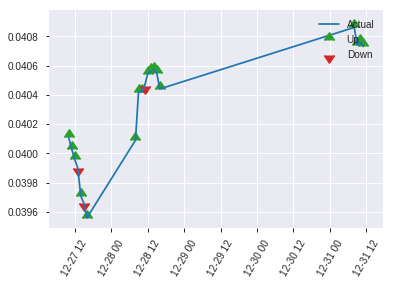


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20999362229289673
RMSE: 0.4582506107938065
LogLoss: 0.6043082322529871
Mean Per-Class Error: 0.28359140859140863
AUC: 0.7523310023310024
pr_auc: 0.6611621919007207
Gini: 0.5046620046620047
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6129552125930786: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      100  32   0.2424   (32.0/132.0)
1      30   61   0.3297   (30.0/91.0)
Total  130  93   0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.612955     0.663043  92
max f2                       0.21617      0.803571  195
max f0point5                 0.634879     0.672854  84
max accuracy                 0.634879     0.730942  84
max precision                0.890509     1         0
max recall                   0.178729     1         204
max specificity              0.890509     1         0
max absolute_mcc             0.634879     0.437989  84
max min_per_class_accuracy   0.584518     0.692308  102
max mean_per_class_accuracy  0.634879     0.716409  84

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 51.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.874277           1.6337    1.6337             0.666667         0.883771  0.666667                    0.883771            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.858775           2.45055   1.96044            1                0.867106  0.8                         0.877105            0.021978        0.043956                   145.055   96.044
    3        0.0313901                   0.848769           1.22527   1.75039            0.5              0.850501  0.714286                    0.869504            0.010989        0.0549451                  22.5275   75.0392
    4        0.0403587                   0.846154           2.45055   1.90598            1                0.847868  0.777778                    0.864696            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.844594           2.45055   2.04212            1                0.845579  0.833333                    0.859917            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.797298           2.005     2.02437            0.818182         0.815007  0.826087                    0.838438            0.0989011       0.208791                   100.5     102.437
    7        0.152466                    0.76409            1.78222   1.94602            0.727273         0.780476  0.794118                    0.819685            0.0879121       0.296703                   78.2218   94.6025
    8        0.201794                    0.737499           1.33666   1.79707            0.545455         0.751058  0.733333                    0.80291             0.0659341       0.362637                   33.6663   79.707
    9        0.300448                    0.689129           1.44805   1.68247            0.590909         0.710565  0.686567                    0.772588            0.142857        0.505495                   44.8052   68.2467
    10       0.399103                    0.619557           1.44805   1.62452            0.590909         0.647557  0.662921                    0.741681            0.142857        0.648352                   44.8052   62.4522
    11       0.502242                    0.563182           0.532728  1.40031            0.217391         0.589127  0.571429                    0.710353            0.0549451       0.703297                   -46.7272  40.0314
    12       0.600897                    0.449536           0.891109  1.31671            0.363636         0.503141  0.537313                    0.676333            0.0879121       0.791209                   -10.8891  31.6713
    13       0.699552                    0.351135           0.668332  1.22527            0.272727         0.394629  0.5                         0.636606            0.0659341       0.857143                   -33.1668  22.5275
    14       0.798206                    0.283902           0.556943  1.14267            0.227273         0.316287  0.466292                    0.597016            0.0549451       0.912088                   -44.3057  14.2672
    15       0.896861                    0.183485           0.77972   1.10275            0.318182         0.239574  0.45                        0.557697            0.0769231       0.989011                   -22.028   10.2747
    16       1                           0.0593114          0.106546  1                  0.0434783        0.140663  0.408072                    0.514685            0

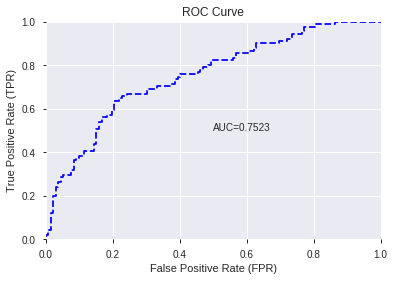

This function is available for GLM models only


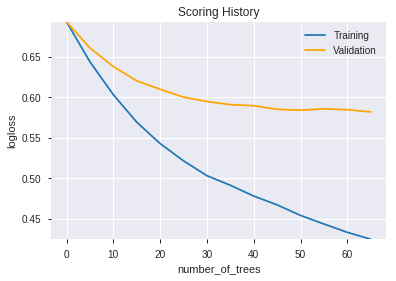

--2019-09-03 03:46:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.236
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.236|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_034557_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_034557_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9b94',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'WILLR_8',
 'ADOSC',
 'aroonup_8',
 'STOCHRSI_fastk',
 'PLUS_DM_14',
 'MFI_12',
 'STOCHF_fastd',
 'HT_PHASOR_inphase',
 'ROC_30',
 'PLUS_DI_8',
 'CCI_8',
 'CCI_12',
 'HT_PHASOR_quadrature',
 'MFI_20',
 'BETA_8',
 'MFI_24',
 'MOM_20',
 'ROCP_30',
 'LINEARREG_ANGLE_12',
 'BBANDS_middleband_30_0_2',
 'MINUS_DM_24',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_30',
 'MA_20_3',
 'CMO_30',
 'STDDEV_14',
 'LINEARREG_SLOPE_20',
 'AROONOSC_24',
 'ROCP_20',
 'PLUS_DI_12',
 'MACDEXT',
 'NATR_20',
 'PLUS_DM_30',
 'BBANDS_lowerband_20_3_5',
 'ATR_12',
 'MACD_hist',
 'BETA_12',
 'MINUS_DI_24',
 'MINUS_DM_20',
 'ATR_8',
 'CDLLONGLINE',
 'ROC_14',
 'aroondown_24',
 'NATR_8',
 'MINUS_DI_20',
 'BBANDS_middleband_14_7_5',
 'BBANDS_lowerband_24_2_4',
 'MACDFIX_hist_8',
 'LINEARREG_14',
 'ROCR100_30',
 'aroondown_14',
 'ROCR_14',
 'TRIX_8',
 'VAR_14',
 'ROCP_24',
 'ROCR_24',
 'CDLBELTHOLD',
 'ROCR100_24',
 'CDLSPINNINGTOP']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.744
GLM             0.735
XGBoost         0.731
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.691    0.700
DLF          0.726  0.709    0.713
Fwe          0.722  0.735    0.717
RFE          0.744  0.700    0.731
XGBF         0.722  0.709    0.713





F1


DeepLearning    0.697
GLM             0.688
XGBoost         0.667
dtype: float64

DeepLearning    GLM  XGBoost
All          0.628  0.635    0.667
DLF          0.664  0.667    0.664
Fwe          0.697  0.688    0.661
RFE          0.674  0.657    0.663
XGBF         0.661  0.667    0.664





auc


DeepLearning    0.773
GLM             0.771
XGBoost         0.760
dtype: float64

DeepLearning    GLM  XGBoost
All          0.711  0.715    0.760
DLF          0.753  0.748    0.756
Fwe          0.773  0.771    0.747
RFE          0.760  0.739    0.752
XGBF         0.756  0.748    0.756





logloss


DeepLearning    0.629
GLM             0.690
XGBoost         0.604
dtype: float64

DeepLearning    GLM  XGBoost
All          0.629  0.690    0.604
DLF          0.598  0.625    0.590
Fwe          0.595  0.599    0.594
RFE          0.622  0.641    0.604
XGBF         0.621  0.625    0.590





mean_per_class_error


DeepLearning    0.332
GLM             0.335
XGBoost         0.310
dtype: float64

DeepLearning    GLM  XGBoost
All          0.332  0.335    0.299
DLF          0.306  0.303    0.300
Fwe          0.276  0.270    0.310
RFE          0.275  0.309    0.284
XGBF         0.314  0.303    0.300





rmse


DeepLearning    0.465
GLM             0.484
XGBoost         0.458
dtype: float64

DeepLearning    GLM  XGBoost
All          0.465  0.484    0.458
DLF          0.448  0.455    0.452
Fwe          0.446  0.440    0.453
RFE          0.461  0.466    0.458
XGBF         0.458  0.455    0.452





mse


DeepLearning    0.216
GLM             0.235
XGBoost         0.210
dtype: float64

DeepLearning    GLM  XGBoost
All          0.216  0.235    0.210
DLF          0.200  0.207    0.204
Fwe          0.199  0.194    0.205
RFE          0.213  0.217    0.210
XGBF         0.210  0.207    0.204

{'F1':       DeepLearning    GLM  XGBoost
 All          0.628    NaN      NaN
 DLF          0.664    NaN      NaN
 DLF            NaN  0.667      NaN
 DLF            NaN    NaN    0.664
 All            NaN  0.635      NaN
 All            NaN    NaN    0.667
 XGBF         0.661    NaN      NaN
 XGBF           NaN  0.667      NaN
 XGBF           NaN    NaN    0.664
 Fwe          0.697    NaN      NaN
 Fwe            NaN  0.688      NaN
 Fwe            NaN    NaN    0.661
 RFE          0.674    NaN      NaN
 RFE            NaN  0.657      NaN
 RFE            NaN    NaN    0.663,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.726    NaN      NaN
 DLF            NaN  0.709      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.691      NaN
 All            NaN    NaN    0.700
 XGBF         0.722    NaN      NaN
 XGBF           NaN  0.709      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.722    NaN      NaN
 Fwe     